# Doodle - clasificador 

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras import layers
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Reshape, Dense, Input, Lambda, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import concatenate, merge, Input, UpSampling2D, MaxPooling2D, GlobalAveragePooling3D, Conv2DTranspose
from keras import backend as K
from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
from keras.applications import VGG16, VGG19, InceptionV3, Xception, MobileNet
from keras import metrics
from keras.utils import to_categorical
from keras.metrics import top_k_categorical_accuracy,categorical_accuracy,categorical_crossentropy

import glob
import os
import re
import ast
import cv2
from tqdm import tqdm
from dask import bag
from PIL import Image, ImageDraw 
import keras
import tensorflow as tf
import keras.backend as K

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.color import rgb2gray
from skimage import exposure

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

C:\Users\roberto\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
path = "D:/MBIT-2017-18-Master-Deep-Learning/Reto Doodle Kaggle - clasificación/train_simplified/"

In [4]:
classfiles = os.listdir(path)
numstonames = {i: v[:-4].replace(" ", "_") for i, v in enumerate(classfiles)} #adds underscores

num_classes = 340    #340 max 
imheight, imwidth = 32, 32  
ims_per_class = 300  #max?

In [5]:
# faster conversion function
def draw_it(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth))
    
    return np.array(image)/255.

In [6]:
class_paths = glob.glob(path + "*.csv")

x_train = []
y_train = []

for i,c in enumerate(tqdm(class_paths[0: num_classes])):
    train = pd.read_csv(c, usecols=['drawing', 'recognized'], nrows=75000, engine='python')
    train = train[train.recognized == True].head(ims_per_class)
    train = train.sample(n=ims_per_class)

    labelarray = np.full((train.shape[0], 1), i)
    imagebag = bag.from_sequence(train.drawing.values).map(draw_it)
    trainarray = np.array(imagebag.compute())  # PARALLELIZA
    trainarray = np.reshape(trainarray, (ims_per_class, -1)) 
       
    x_train.append(trainarray)
    y_train.append(labelarray)

100%|████████████████████████████████████████████████████████████████████████████████| 340/340 [09:39<00:00,  1.71s/it]


In [7]:
y_train = np.reshape(y_train, (ims_per_class * num_classes, 1))
y_train = keras.utils.to_categorical(y_train, num_classes)
x_train = np.reshape(x_train, (ims_per_class * num_classes, imheight, imwidth, 1))   
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)
print(y_train.shape, "\n", y_val.shape, "\n",
      x_train.shape, "\n", x_val.shape) 

(76500, 340) 
 (25500, 340) 
 (76500, 32, 32, 1) 
 (25500, 32, 32, 1)


298


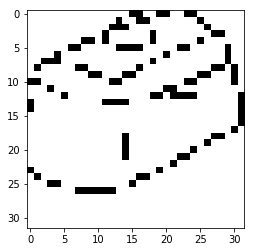

In [12]:
plt.imshow(np.reshape(x_train[1],(32,32)),cmap=plt.cm.gray)
print(np.argmax(y_train[5]))

In [13]:
batch_size = 256
epochs = 50
inChannel = 1
input_img = Input(shape = (imheight, imwidth, inChannel))


In [14]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [16]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = 'rmsprop')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
__________

In [17]:
autoencoder_train = autoencoder.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_val, x_val))

Train on 76500 samples, validate on 25500 samples
Epoch 1/50
76500/76500 [==============================] - ETA: 41:29 - loss: 0.31 - ETA: 37:10 - loss: 0.28 - ETA: 35:41 - loss: 0.25 - ETA: 34:48 - loss: 0.24 - ETA: 34:15 - loss: 0.23 - ETA: 33:52 - loss: 0.22 - ETA: 33:34 - loss: 0.21 - ETA: 33:20 - loss: 0.20 - ETA: 33:10 - loss: 0.19 - ETA: 33:03 - loss: 0.19 - ETA: 32:59 - loss: 0.18 - ETA: 32:48 - loss: 0.18 - ETA: 32:45 - loss: 0.17 - ETA: 32:40 - loss: 0.17 - ETA: 32:30 - loss: 0.17 - ETA: 32:28 - loss: 0.16 - ETA: 32:18 - loss: 0.16 - ETA: 32:07 - loss: 0.16 - ETA: 32:07 - loss: 0.16 - ETA: 32:03 - loss: 0.15 - ETA: 32:04 - loss: 0.15 - ETA: 32:09 - loss: 0.15 - ETA: 32:09 - loss: 0.15 - ETA: 32:01 - loss: 0.14 - ETA: 32:03 - loss: 0.14 - ETA: 31:59 - loss: 0.14 - ETA: 31:53 - loss: 0.14 - ETA: 31:48 - loss: 0.14 - ETA: 31:41 - loss: 0.14 - ETA: 31:37 - loss: 0.14 - ETA: 31:38 - loss: 0.13 - ETA: 31:28 - loss: 0.13 - ETA: 31:18 - loss: 0.13 - ETA: 31:08 - loss: 0.13 - ETA: 30:

76500/76500 [==============================] - ETA: 33:39 - loss: 0.03 - ETA: 33:31 - loss: 0.03 - ETA: 33:23 - loss: 0.03 - ETA: 33:11 - loss: 0.03 - ETA: 33:02 - loss: 0.03 - ETA: 32:54 - loss: 0.03 - ETA: 32:47 - loss: 0.03 - ETA: 32:37 - loss: 0.03 - ETA: 32:29 - loss: 0.04 - ETA: 32:23 - loss: 0.04 - ETA: 32:16 - loss: 0.04 - ETA: 32:08 - loss: 0.04 - ETA: 31:59 - loss: 0.04 - ETA: 31:53 - loss: 0.03 - ETA: 31:46 - loss: 0.03 - ETA: 31:40 - loss: 0.03 - ETA: 31:33 - loss: 0.03 - ETA: 31:29 - loss: 0.03 - ETA: 31:24 - loss: 0.03 - ETA: 31:18 - loss: 0.03 - ETA: 31:12 - loss: 0.03 - ETA: 31:05 - loss: 0.03 - ETA: 31:00 - loss: 0.03 - ETA: 30:54 - loss: 0.03 - ETA: 30:46 - loss: 0.03 - ETA: 30:39 - loss: 0.03 - ETA: 30:31 - loss: 0.03 - ETA: 30:23 - loss: 0.03 - ETA: 30:16 - loss: 0.03 - ETA: 30:08 - loss: 0.03 - ETA: 30:01 - loss: 0.03 - ETA: 29:53 - loss: 0.03 - ETA: 29:46 - loss: 0.03 - ETA: 29:38 - loss: 0.03 - ETA: 29:31 - loss: 0.03 - ETA: 29:23 - loss: 0.03 - ETA: 29:16 - loss

76500/76500 [==============================] - ETA: 32:49 - loss: 0.02 - ETA: 32:57 - loss: 0.02 - ETA: 32:47 - loss: 0.02 - ETA: 32:35 - loss: 0.02 - ETA: 32:26 - loss: 0.02 - ETA: 32:17 - loss: 0.02 - ETA: 32:09 - loss: 0.02 - ETA: 32:00 - loss: 0.02 - ETA: 31:51 - loss: 0.02 - ETA: 31:45 - loss: 0.02 - ETA: 31:40 - loss: 0.02 - ETA: 31:34 - loss: 0.02 - ETA: 31:26 - loss: 0.02 - ETA: 31:20 - loss: 0.02 - ETA: 31:13 - loss: 0.02 - ETA: 31:05 - loss: 0.02 - ETA: 30:58 - loss: 0.02 - ETA: 30:51 - loss: 0.02 - ETA: 30:46 - loss: 0.02 - ETA: 30:39 - loss: 0.02 - ETA: 30:32 - loss: 0.02 - ETA: 30:26 - loss: 0.02 - ETA: 30:19 - loss: 0.02 - ETA: 30:13 - loss: 0.02 - ETA: 30:06 - loss: 0.02 - ETA: 30:00 - loss: 0.02 - ETA: 29:53 - loss: 0.02 - ETA: 29:46 - loss: 0.02 - ETA: 29:39 - loss: 0.02 - ETA: 29:32 - loss: 0.02 - ETA: 29:25 - loss: 0.02 - ETA: 29:17 - loss: 0.02 - ETA: 29:11 - loss: 0.02 - ETA: 29:04 - loss: 0.02 - ETA: 28:57 - loss: 0.02 - ETA: 28:50 - loss: 0.02 - ETA: 28:43 - loss

76500/76500 [==============================] - ETA: 32:56 - loss: 0.01 - ETA: 32:39 - loss: 0.01 - ETA: 32:30 - loss: 0.01 - ETA: 32:23 - loss: 0.01 - ETA: 32:17 - loss: 0.01 - ETA: 32:13 - loss: 0.01 - ETA: 32:03 - loss: 0.01 - ETA: 31:56 - loss: 0.02 - ETA: 31:47 - loss: 0.02 - ETA: 31:40 - loss: 0.02 - ETA: 31:33 - loss: 0.01 - ETA: 31:27 - loss: 0.01 - ETA: 31:19 - loss: 0.01 - ETA: 31:13 - loss: 0.01 - ETA: 31:07 - loss: 0.01 - ETA: 31:00 - loss: 0.01 - ETA: 30:53 - loss: 0.01 - ETA: 30:47 - loss: 0.01 - ETA: 30:41 - loss: 0.01 - ETA: 30:34 - loss: 0.01 - ETA: 30:28 - loss: 0.01 - ETA: 30:21 - loss: 0.01 - ETA: 30:15 - loss: 0.01 - ETA: 30:08 - loss: 0.01 - ETA: 30:01 - loss: 0.01 - ETA: 29:54 - loss: 0.01 - ETA: 29:48 - loss: 0.01 - ETA: 29:41 - loss: 0.01 - ETA: 29:34 - loss: 0.01 - ETA: 29:27 - loss: 0.01 - ETA: 29:21 - loss: 0.01 - ETA: 29:14 - loss: 0.01 - ETA: 29:07 - loss: 0.01 - ETA: 29:01 - loss: 0.01 - ETA: 28:54 - loss: 0.01 - ETA: 28:47 - loss: 0.01 - ETA: 28:40 - loss

76500/76500 [==============================] - ETA: 33:03 - loss: 0.01 - ETA: 32:44 - loss: 0.01 - ETA: 32:30 - loss: 0.01 - ETA: 32:23 - loss: 0.01 - ETA: 32:16 - loss: 0.01 - ETA: 32:08 - loss: 0.01 - ETA: 32:00 - loss: 0.01 - ETA: 31:52 - loss: 0.01 - ETA: 31:45 - loss: 0.01 - ETA: 31:39 - loss: 0.01 - ETA: 31:32 - loss: 0.01 - ETA: 31:24 - loss: 0.01 - ETA: 31:18 - loss: 0.01 - ETA: 31:11 - loss: 0.01 - ETA: 31:05 - loss: 0.01 - ETA: 30:59 - loss: 0.01 - ETA: 30:53 - loss: 0.01 - ETA: 30:45 - loss: 0.01 - ETA: 30:39 - loss: 0.01 - ETA: 30:33 - loss: 0.01 - ETA: 30:26 - loss: 0.01 - ETA: 30:20 - loss: 0.01 - ETA: 30:14 - loss: 0.01 - ETA: 30:07 - loss: 0.01 - ETA: 30:00 - loss: 0.01 - ETA: 29:53 - loss: 0.01 - ETA: 29:47 - loss: 0.01 - ETA: 29:40 - loss: 0.01 - ETA: 29:33 - loss: 0.01 - ETA: 29:26 - loss: 0.01 - ETA: 29:19 - loss: 0.01 - ETA: 29:13 - loss: 0.01 - ETA: 29:06 - loss: 0.01 - ETA: 28:59 - loss: 0.01 - ETA: 28:53 - loss: 0.01 - ETA: 28:46 - loss: 0.01 - ETA: 28:39 - loss

76500/76500 [==============================] - ETA: 32:53 - loss: 0.00 - ETA: 32:42 - loss: 0.00 - ETA: 32:30 - loss: 0.00 - ETA: 32:25 - loss: 0.00 - ETA: 32:22 - loss: 0.01 - ETA: 32:14 - loss: 0.01 - ETA: 32:05 - loss: 0.01 - ETA: 31:58 - loss: 0.01 - ETA: 31:49 - loss: 0.01 - ETA: 31:44 - loss: 0.01 - ETA: 31:38 - loss: 0.01 - ETA: 31:31 - loss: 0.01 - ETA: 31:25 - loss: 0.01 - ETA: 31:18 - loss: 0.01 - ETA: 31:11 - loss: 0.01 - ETA: 31:04 - loss: 0.01 - ETA: 30:57 - loss: 0.01 - ETA: 30:50 - loss: 0.01 - ETA: 30:44 - loss: 0.01 - ETA: 30:39 - loss: 0.01 - ETA: 30:32 - loss: 0.01 - ETA: 30:24 - loss: 0.01 - ETA: 30:18 - loss: 0.01 - ETA: 30:11 - loss: 0.01 - ETA: 30:04 - loss: 0.01 - ETA: 29:57 - loss: 0.01 - ETA: 29:56 - loss: 0.01 - ETA: 29:55 - loss: 0.01 - ETA: 29:53 - loss: 0.01 - ETA: 29:49 - loss: 0.01 - ETA: 29:45 - loss: 0.01 - ETA: 29:41 - loss: 0.01 - ETA: 29:35 - loss: 0.01 - ETA: 29:31 - loss: 0.01 - ETA: 29:27 - loss: 0.01 - ETA: 29:22 - loss: 0.01 - ETA: 29:19 - loss

76500/76500 [==============================] - ETA: 32:59 - loss: 0.00 - ETA: 32:49 - loss: 0.00 - ETA: 32:38 - loss: 0.00 - ETA: 32:29 - loss: 0.00 - ETA: 32:23 - loss: 0.00 - ETA: 32:16 - loss: 0.00 - ETA: 32:10 - loss: 0.00 - ETA: 32:01 - loss: 0.00 - ETA: 31:53 - loss: 0.00 - ETA: 31:45 - loss: 0.00 - ETA: 31:37 - loss: 0.00 - ETA: 31:29 - loss: 0.00 - ETA: 31:22 - loss: 0.00 - ETA: 31:16 - loss: 0.00 - ETA: 31:10 - loss: 0.00 - ETA: 31:05 - loss: 0.00 - ETA: 30:57 - loss: 0.00 - ETA: 30:50 - loss: 0.00 - ETA: 30:43 - loss: 0.00 - ETA: 30:36 - loss: 0.00 - ETA: 30:29 - loss: 0.00 - ETA: 30:22 - loss: 0.00 - ETA: 30:15 - loss: 0.00 - ETA: 30:08 - loss: 0.00 - ETA: 30:01 - loss: 0.00 - ETA: 29:54 - loss: 0.00 - ETA: 29:47 - loss: 0.00 - ETA: 29:41 - loss: 0.00 - ETA: 29:34 - loss: 0.00 - ETA: 29:27 - loss: 0.00 - ETA: 29:21 - loss: 0.00 - ETA: 29:14 - loss: 0.00 - ETA: 29:08 - loss: 0.00 - ETA: 29:01 - loss: 0.00 - ETA: 28:54 - loss: 0.00 - ETA: 28:48 - loss: 0.00 - ETA: 28:41 - loss

76500/76500 [==============================] - ETA: 34:23 - loss: 0.00 - ETA: 33:54 - loss: 0.00 - ETA: 33:37 - loss: 0.00 - ETA: 33:20 - loss: 0.00 - ETA: 33:07 - loss: 0.00 - ETA: 33:00 - loss: 0.00 - ETA: 32:50 - loss: 0.00 - ETA: 32:42 - loss: 0.00 - ETA: 32:33 - loss: 0.00 - ETA: 32:39 - loss: 0.01 - ETA: 32:47 - loss: 0.01 - ETA: 32:45 - loss: 0.01 - ETA: 32:35 - loss: 0.01 - ETA: 32:25 - loss: 0.01 - ETA: 32:14 - loss: 0.01 - ETA: 32:05 - loss: 0.01 - ETA: 31:56 - loss: 0.01 - ETA: 31:46 - loss: 0.00 - ETA: 31:38 - loss: 0.00 - ETA: 31:32 - loss: 0.00 - ETA: 31:29 - loss: 0.00 - ETA: 31:21 - loss: 0.00 - ETA: 31:14 - loss: 0.00 - ETA: 31:06 - loss: 0.00 - ETA: 30:58 - loss: 0.00 - ETA: 30:50 - loss: 0.00 - ETA: 30:41 - loss: 0.00 - ETA: 30:34 - loss: 0.00 - ETA: 30:27 - loss: 0.00 - ETA: 30:19 - loss: 0.00 - ETA: 30:11 - loss: 0.00 - ETA: 30:04 - loss: 0.00 - ETA: 29:56 - loss: 0.00 - ETA: 29:48 - loss: 0.00 - ETA: 29:41 - loss: 0.00 - ETA: 29:33 - loss: 0.00 - ETA: 29:26 - loss

76500/76500 [==============================] - ETA: 33:09 - loss: 0.00 - ETA: 33:02 - loss: 0.00 - ETA: 32:56 - loss: 0.00 - ETA: 32:46 - loss: 0.00 - ETA: 32:43 - loss: 0.00 - ETA: 32:34 - loss: 0.00 - ETA: 32:26 - loss: 0.00 - ETA: 32:23 - loss: 0.00 - ETA: 32:27 - loss: 0.00 - ETA: 32:25 - loss: 0.00 - ETA: 32:17 - loss: 0.00 - ETA: 32:16 - loss: 0.00 - ETA: 32:10 - loss: 0.00 - ETA: 32:09 - loss: 0.00 - ETA: 32:06 - loss: 0.00 - ETA: 31:58 - loss: 0.00 - ETA: 31:49 - loss: 0.00 - ETA: 31:40 - loss: 0.00 - ETA: 31:31 - loss: 0.00 - ETA: 31:26 - loss: 0.00 - ETA: 31:18 - loss: 0.00 - ETA: 31:11 - loss: 0.00 - ETA: 31:06 - loss: 0.00 - ETA: 31:03 - loss: 0.00 - ETA: 30:59 - loss: 0.00 - ETA: 30:52 - loss: 0.00 - ETA: 30:44 - loss: 0.00 - ETA: 30:37 - loss: 0.00 - ETA: 30:31 - loss: 0.00 - ETA: 30:24 - loss: 0.00 - ETA: 30:16 - loss: 0.00 - ETA: 30:08 - loss: 0.00 - ETA: 30:05 - loss: 0.00 - ETA: 30:00 - loss: 0.00 - ETA: 29:54 - loss: 0.00 - ETA: 29:48 - loss: 0.00 - ETA: 29:41 - loss

76500/76500 [==============================] - ETA: 33:15 - loss: 0.01 - ETA: 33:10 - loss: 0.00 - ETA: 33:01 - loss: 0.00 - ETA: 33:13 - loss: 0.00 - ETA: 33:13 - loss: 0.00 - ETA: 33:18 - loss: 0.00 - ETA: 33:10 - loss: 0.00 - ETA: 33:05 - loss: 0.00 - ETA: 33:05 - loss: 0.00 - ETA: 33:03 - loss: 0.00 - ETA: 32:57 - loss: 0.00 - ETA: 32:45 - loss: 0.00 - ETA: 32:33 - loss: 0.00 - ETA: 32:24 - loss: 0.00 - ETA: 32:14 - loss: 0.00 - ETA: 32:04 - loss: 0.00 - ETA: 31:55 - loss: 0.00 - ETA: 31:45 - loss: 0.00 - ETA: 31:37 - loss: 0.00 - ETA: 31:31 - loss: 0.00 - ETA: 31:23 - loss: 0.00 - ETA: 31:15 - loss: 0.00 - ETA: 31:07 - loss: 0.00 - ETA: 30:59 - loss: 0.00 - ETA: 30:52 - loss: 0.00 - ETA: 30:44 - loss: 0.00 - ETA: 30:36 - loss: 0.00 - ETA: 30:28 - loss: 0.00 - ETA: 30:20 - loss: 0.00 - ETA: 30:13 - loss: 0.00 - ETA: 30:05 - loss: 0.00 - ETA: 29:58 - loss: 0.00 - ETA: 29:50 - loss: 0.00 - ETA: 29:43 - loss: 0.00 - ETA: 29:36 - loss: 0.00 - ETA: 29:29 - loss: 0.00 - ETA: 29:22 - loss

76500/76500 [==============================] - ETA: 33:04 - loss: 0.00 - ETA: 32:47 - loss: 0.00 - ETA: 32:39 - loss: 0.00 - ETA: 32:36 - loss: 0.00 - ETA: 32:28 - loss: 0.00 - ETA: 32:21 - loss: 0.00 - ETA: 32:12 - loss: 0.00 - ETA: 32:10 - loss: 0.00 - ETA: 32:05 - loss: 0.00 - ETA: 31:55 - loss: 0.00 - ETA: 31:47 - loss: 0.00 - ETA: 31:40 - loss: 0.00 - ETA: 31:34 - loss: 0.00 - ETA: 31:27 - loss: 0.00 - ETA: 31:20 - loss: 0.00 - ETA: 31:14 - loss: 0.00 - ETA: 31:07 - loss: 0.00 - ETA: 30:59 - loss: 0.00 - ETA: 30:53 - loss: 0.00 - ETA: 30:47 - loss: 0.00 - ETA: 30:41 - loss: 0.00 - ETA: 30:33 - loss: 0.00 - ETA: 30:26 - loss: 0.00 - ETA: 30:19 - loss: 0.00 - ETA: 30:12 - loss: 0.00 - ETA: 30:05 - loss: 0.00 - ETA: 29:58 - loss: 0.00 - ETA: 29:51 - loss: 0.00 - ETA: 29:44 - loss: 0.00 - ETA: 29:37 - loss: 0.00 - ETA: 29:30 - loss: 0.00 - ETA: 29:22 - loss: 0.00 - ETA: 29:15 - loss: 0.00 - ETA: 29:08 - loss: 0.00 - ETA: 29:01 - loss: 0.00 - ETA: 28:55 - loss: 0.00 - ETA: 28:48 - loss

76500/76500 [==============================] - ETA: 32:44 - loss: 0.00 - ETA: 33:02 - loss: 0.00 - ETA: 32:48 - loss: 0.00 - ETA: 32:37 - loss: 0.00 - ETA: 32:26 - loss: 0.00 - ETA: 32:16 - loss: 0.00 - ETA: 32:05 - loss: 0.00 - ETA: 31:58 - loss: 0.00 - ETA: 31:52 - loss: 0.00 - ETA: 31:45 - loss: 0.00 - ETA: 31:38 - loss: 0.00 - ETA: 31:31 - loss: 0.00 - ETA: 31:23 - loss: 0.00 - ETA: 31:17 - loss: 0.00 - ETA: 31:11 - loss: 0.00 - ETA: 31:03 - loss: 0.00 - ETA: 30:56 - loss: 0.00 - ETA: 30:50 - loss: 0.00 - ETA: 30:44 - loss: 0.00 - ETA: 30:37 - loss: 0.00 - ETA: 30:30 - loss: 0.00 - ETA: 30:24 - loss: 0.00 - ETA: 30:19 - loss: 0.00 - ETA: 30:12 - loss: 0.00 - ETA: 30:05 - loss: 0.00 - ETA: 29:58 - loss: 0.00 - ETA: 29:51 - loss: 0.00 - ETA: 29:44 - loss: 0.00 - ETA: 29:37 - loss: 0.00 - ETA: 29:31 - loss: 0.00 - ETA: 29:24 - loss: 0.00 - ETA: 29:18 - loss: 0.00 - ETA: 29:11 - loss: 0.00 - ETA: 29:05 - loss: 0.00 - ETA: 28:58 - loss: 0.00 - ETA: 28:51 - loss: 0.00 - ETA: 28:45 - loss

76500/76500 [==============================] - ETA: 33:06 - loss: 0.00 - ETA: 32:49 - loss: 0.00 - ETA: 32:40 - loss: 0.00 - ETA: 32:25 - loss: 0.00 - ETA: 32:22 - loss: 0.00 - ETA: 32:15 - loss: 0.00 - ETA: 32:07 - loss: 0.00 - ETA: 31:57 - loss: 0.00 - ETA: 31:50 - loss: 0.00 - ETA: 31:43 - loss: 0.00 - ETA: 31:38 - loss: 0.00 - ETA: 31:32 - loss: 0.00 - ETA: 31:26 - loss: 0.00 - ETA: 31:19 - loss: 0.00 - ETA: 31:11 - loss: 0.00 - ETA: 31:04 - loss: 0.00 - ETA: 30:57 - loss: 0.00 - ETA: 30:50 - loss: 0.00 - ETA: 30:44 - loss: 0.00 - ETA: 30:37 - loss: 0.00 - ETA: 30:30 - loss: 0.00 - ETA: 30:24 - loss: 0.00 - ETA: 30:18 - loss: 0.00 - ETA: 30:11 - loss: 0.00 - ETA: 30:04 - loss: 0.00 - ETA: 29:57 - loss: 0.00 - ETA: 29:50 - loss: 0.00 - ETA: 29:43 - loss: 0.00 - ETA: 29:36 - loss: 0.00 - ETA: 29:30 - loss: 0.00 - ETA: 29:23 - loss: 0.00 - ETA: 29:16 - loss: 0.00 - ETA: 29:09 - loss: 0.00 - ETA: 29:03 - loss: 0.00 - ETA: 28:56 - loss: 0.00 - ETA: 28:49 - loss: 0.00 - ETA: 28:42 - loss

76500/76500 [==============================] - ETA: 32:58 - loss: 0.00 - ETA: 32:44 - loss: 0.00 - ETA: 32:34 - loss: 0.00 - ETA: 32:22 - loss: 0.00 - ETA: 32:20 - loss: 0.00 - ETA: 32:11 - loss: 0.00 - ETA: 32:01 - loss: 0.00 - ETA: 31:53 - loss: 0.00 - ETA: 31:46 - loss: 0.00 - ETA: 31:39 - loss: 0.00 - ETA: 31:31 - loss: 0.00 - ETA: 31:24 - loss: 0.00 - ETA: 31:18 - loss: 0.00 - ETA: 31:10 - loss: 0.00 - ETA: 31:04 - loss: 0.00 - ETA: 30:58 - loss: 0.00 - ETA: 30:52 - loss: 0.00 - ETA: 30:46 - loss: 0.00 - ETA: 30:40 - loss: 0.00 - ETA: 30:34 - loss: 0.00 - ETA: 30:28 - loss: 0.00 - ETA: 30:22 - loss: 0.00 - ETA: 30:14 - loss: 0.00 - ETA: 30:08 - loss: 0.00 - ETA: 30:01 - loss: 0.00 - ETA: 29:54 - loss: 0.00 - ETA: 29:48 - loss: 0.00 - ETA: 29:41 - loss: 0.00 - ETA: 29:35 - loss: 0.00 - ETA: 29:29 - loss: 0.00 - ETA: 29:21 - loss: 0.00 - ETA: 29:14 - loss: 0.00 - ETA: 29:07 - loss: 0.00 - ETA: 29:01 - loss: 0.00 - ETA: 28:54 - loss: 0.00 - ETA: 28:47 - loss: 0.00 - ETA: 28:41 - loss

76500/76500 [==============================] - ETA: 32:51 - loss: 0.00 - ETA: 32:52 - loss: 0.00 - ETA: 32:35 - loss: 0.00 - ETA: 32:25 - loss: 0.00 - ETA: 32:22 - loss: 0.00 - ETA: 32:13 - loss: 0.00 - ETA: 32:03 - loss: 0.00 - ETA: 31:55 - loss: 0.00 - ETA: 31:46 - loss: 0.00 - ETA: 31:38 - loss: 0.00 - ETA: 31:30 - loss: 0.00 - ETA: 31:23 - loss: 0.00 - ETA: 31:17 - loss: 0.00 - ETA: 31:10 - loss: 0.00 - ETA: 31:04 - loss: 0.00 - ETA: 30:57 - loss: 0.00 - ETA: 30:50 - loss: 0.00 - ETA: 30:43 - loss: 0.00 - ETA: 30:38 - loss: 0.00 - ETA: 30:32 - loss: 0.00 - ETA: 30:26 - loss: 0.00 - ETA: 30:19 - loss: 0.00 - ETA: 30:12 - loss: 0.00 - ETA: 30:06 - loss: 0.00 - ETA: 29:59 - loss: 0.00 - ETA: 29:52 - loss: 0.00 - ETA: 29:45 - loss: 0.00 - ETA: 29:39 - loss: 0.00 - ETA: 29:32 - loss: 0.00 - ETA: 29:25 - loss: 0.00 - ETA: 29:19 - loss: 0.00 - ETA: 29:12 - loss: 0.00 - ETA: 29:08 - loss: 0.00 - ETA: 29:03 - loss: 0.00 - ETA: 28:58 - loss: 0.00 - ETA: 28:53 - loss: 0.00 - ETA: 28:49 - loss

76500/76500 [==============================] - ETA: 32:42 - loss: 0.00 - ETA: 32:32 - loss: 0.00 - ETA: 32:32 - loss: 0.00 - ETA: 32:29 - loss: 0.00 - ETA: 32:20 - loss: 0.00 - ETA: 32:14 - loss: 0.00 - ETA: 32:07 - loss: 0.00 - ETA: 31:58 - loss: 0.00 - ETA: 31:49 - loss: 0.00 - ETA: 31:42 - loss: 0.00 - ETA: 31:34 - loss: 0.00 - ETA: 31:29 - loss: 0.00 - ETA: 31:21 - loss: 0.00 - ETA: 31:14 - loss: 0.00 - ETA: 31:07 - loss: 0.00 - ETA: 31:00 - loss: 0.00 - ETA: 30:53 - loss: 0.00 - ETA: 30:46 - loss: 0.00 - ETA: 30:40 - loss: 0.00 - ETA: 30:32 - loss: 0.00 - ETA: 30:26 - loss: 0.00 - ETA: 30:18 - loss: 0.00 - ETA: 30:12 - loss: 0.00 - ETA: 30:05 - loss: 0.00 - ETA: 29:59 - loss: 0.00 - ETA: 29:53 - loss: 0.00 - ETA: 29:46 - loss: 0.00 - ETA: 29:40 - loss: 0.00 - ETA: 29:33 - loss: 0.00 - ETA: 29:26 - loss: 0.00 - ETA: 29:20 - loss: 0.00 - ETA: 29:13 - loss: 0.00 - ETA: 29:06 - loss: 0.00 - ETA: 28:59 - loss: 0.00 - ETA: 28:52 - loss: 0.00 - ETA: 28:46 - loss: 0.00 - ETA: 28:40 - loss

 3584/76500 [>.............................] - ETA: 33:45 - loss: 0.00 - ETA: 33:23 - loss: 0.00 - ETA: 33:09 - loss: 0.00 - ETA: 32:58 - loss: 0.00 - ETA: 32:46 - loss: 0.00 - ETA: 32:39 - loss: 0.00 - ETA: 32:30 - loss: 0.00 - ETA: 32:22 - loss: 0.00 - ETA: 32:16 - loss: 0.00 - ETA: 32:09 - loss: 0.00 - ETA: 32:05 - loss: 0.00 - ETA: 31:57 - loss: 0.00 - ETA: 31:50 - loss: 0.00 - ETA: 31:51 - loss: 0.0015

KeyboardInterrupt: 

In [49]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [18]:
autoencoder.save_weights('autoencoder_doodle_v1.h5')

In [19]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

In [20]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(1000, activation='relu')(flat)
    den = Dropout(0.15)(den)
    den = Dense(500, activation='relu')(den)
    den = Dropout(0.15)(den)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [21]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [22]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

In [23]:
autoencoder.get_weights()[0][1]

array([[[-4.64876704e-02, -6.47387281e-02, -1.83328211e-01,
         -4.03705835e-02,  8.43158960e-02, -6.47706017e-02,
         -2.89662387e-02, -1.97874140e-02,  2.48409994e-02,
         -1.32269755e-01, -1.59407943e-01, -9.75257754e-02,
          1.36031881e-01, -6.84899539e-02, -1.97748303e-01,
          1.02623194e-01,  2.36136645e-01, -1.79381687e-02,
          8.84099677e-02,  7.51896203e-02,  8.41778517e-02,
         -1.18936069e-01,  1.10727474e-01,  1.27863809e-01,
         -1.27512708e-01,  6.80501163e-02,  5.44157811e-02,
         -1.82845618e-03, -2.92328149e-01,  1.96303148e-02,
          1.75257355e-01, -9.02636722e-02]],

       [[ 1.95664726e-02, -2.39267185e-01, -1.72025621e-01,
         -1.07063256e-01, -7.55773038e-02,  8.28736201e-02,
         -3.24385911e-02,  1.31202623e-01,  5.98315150e-02,
         -8.64475667e-02,  1.52793005e-02, -3.47941518e-01,
          1.46879673e-01,  1.04262166e-01, -1.18972547e-01,
          1.53723970e-01,  1.42767802e-01,  1.07448630

In [24]:
full_model.get_weights()[0][1]

array([[[-4.64876704e-02, -6.47387281e-02, -1.83328211e-01,
         -4.03705835e-02,  8.43158960e-02, -6.47706017e-02,
         -2.89662387e-02, -1.97874140e-02,  2.48409994e-02,
         -1.32269755e-01, -1.59407943e-01, -9.75257754e-02,
          1.36031881e-01, -6.84899539e-02, -1.97748303e-01,
          1.02623194e-01,  2.36136645e-01, -1.79381687e-02,
          8.84099677e-02,  7.51896203e-02,  8.41778517e-02,
         -1.18936069e-01,  1.10727474e-01,  1.27863809e-01,
         -1.27512708e-01,  6.80501163e-02,  5.44157811e-02,
         -1.82845618e-03, -2.92328149e-01,  1.96303148e-02,
          1.75257355e-01, -9.02636722e-02]],

       [[ 1.95664726e-02, -2.39267185e-01, -1.72025621e-01,
         -1.07063256e-01, -7.55773038e-02,  8.28736201e-02,
         -3.24385911e-02,  1.31202623e-01,  5.98315150e-02,
         -8.64475667e-02,  1.52793005e-02, -3.47941518e-01,
          1.46879673e-01,  1.04262166e-01, -1.18972547e-01,
          1.53723970e-01,  1.42767802e-01,  1.07448630

In [25]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

In [28]:
full_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=[categorical_accuracy])

In [29]:
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_16 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 64)        18496     
__________

In [31]:
train_model = full_model.fit(x_train, y_train, batch_size=256,epochs=50,verbose=1,validation_data=(x_val, y_val))

Train on 76500 samples, validate on 25500 samples
Epoch 1/50


37120/76500 [=============>................] - ETA: 9:13 - loss: 5.5155 - categorical_accuracy: 0.01 - ETA: 9:08 - loss: 5.4930 - categorical_accuracy: 0.02 - ETA: 9:03 - loss: 5.4667 - categorical_accuracy: 0.02 - ETA: 8:59 - loss: 5.5115 - categorical_accuracy: 0.02 - ETA: 8:59 - loss: 5.4987 - categorical_accuracy: 0.02 - ETA: 8:56 - loss: 5.5044 - categorical_accuracy: 0.01 - ETA: 8:53 - loss: 5.4813 - categorical_accuracy: 0.01 - ETA: 8:52 - loss: 5.4776 - categorical_accuracy: 0.01 - ETA: 8:50 - loss: 5.4669 - categorical_accuracy: 0.02 - ETA: 8:48 - loss: 5.4609 - categorical_accuracy: 0.02 - ETA: 8:45 - loss: 5.4506 - categorical_accuracy: 0.02 - ETA: 8:44 - loss: 5.4428 - categorical_accuracy: 0.02 - ETA: 8:42 - loss: 5.4467 - categorical_accuracy: 0.02 - ETA: 8:40 - loss: 5.4406 - categorical_accuracy: 0.02 - ETA: 8:38 - loss: 5.4349 - categorical_accuracy: 0.02 - ETA: 8:36 - loss: 5.4200 - categorical_accuracy: 0.02 - ETA: 8:34 - loss: 5.4162 - categorical_accuracy: 0.02 - E

74496/76500 [============================>.] - ETA: 4:41 - loss: 4.9854 - categorical_accuracy: 0.04 - ETA: 4:39 - loss: 4.9825 - categorical_accuracy: 0.04 - ETA: 4:37 - loss: 4.9807 - categorical_accuracy: 0.04 - ETA: 4:35 - loss: 4.9787 - categorical_accuracy: 0.04 - ETA: 4:33 - loss: 4.9767 - categorical_accuracy: 0.04 - ETA: 4:31 - loss: 4.9745 - categorical_accuracy: 0.04 - ETA: 4:30 - loss: 4.9722 - categorical_accuracy: 0.04 - ETA: 4:28 - loss: 4.9699 - categorical_accuracy: 0.04 - ETA: 4:26 - loss: 4.9678 - categorical_accuracy: 0.04 - ETA: 4:24 - loss: 4.9656 - categorical_accuracy: 0.04 - ETA: 4:22 - loss: 4.9631 - categorical_accuracy: 0.05 - ETA: 4:20 - loss: 4.9601 - categorical_accuracy: 0.05 - ETA: 4:18 - loss: 4.9573 - categorical_accuracy: 0.05 - ETA: 4:17 - loss: 4.9545 - categorical_accuracy: 0.05 - ETA: 4:15 - loss: 4.9523 - categorical_accuracy: 0.05 - ETA: 4:13 - loss: 4.9497 - categorical_accuracy: 0.05 - ETA: 4:11 - loss: 4.9475 - categorical_accuracy: 0.05 - E

76500/76500 [==============================] - ETA: 12s - loss: 4.7051 - categorical_accuracy: 0.071 - ETA: 10s - loss: 4.7031 - categorical_accuracy: 0.071 - ETA: 8s - loss: 4.7011 - categorical_accuracy: 0.071 - ETA: 7s - loss: 4.6993 - categorical_accuracy: 0.07 - ETA: 5s - loss: 4.6973 - categorical_accuracy: 0.07 - ETA: 3s - loss: 4.6962 - categorical_accuracy: 0.07 - ETA: 1s - loss: 4.6942 - categorical_accuracy: 0.07 - 698s 9ms/step - loss: 4.6928 - categorical_accuracy: 0.0728 - val_loss: 4.0728 - val_categorical_accuracy: 0.1452
Epoch 2/50


37376/76500 [=============>................] - ETA: 9:14 - loss: 4.0764 - categorical_accuracy: 0.17 - ETA: 9:02 - loss: 4.0109 - categorical_accuracy: 0.16 - ETA: 9:00 - loss: 4.0383 - categorical_accuracy: 0.15 - ETA: 9:00 - loss: 4.0234 - categorical_accuracy: 0.14 - ETA: 8:59 - loss: 4.0307 - categorical_accuracy: 0.13 - ETA: 8:55 - loss: 4.0430 - categorical_accuracy: 0.14 - ETA: 8:55 - loss: 4.0197 - categorical_accuracy: 0.14 - ETA: 8:54 - loss: 4.0173 - categorical_accuracy: 0.14 - ETA: 8:52 - loss: 3.9985 - categorical_accuracy: 0.14 - ETA: 8:51 - loss: 4.0093 - categorical_accuracy: 0.14 - ETA: 8:48 - loss: 3.9928 - categorical_accuracy: 0.14 - ETA: 8:46 - loss: 3.9961 - categorical_accuracy: 0.14 - ETA: 8:44 - loss: 3.9871 - categorical_accuracy: 0.14 - ETA: 8:42 - loss: 3.9874 - categorical_accuracy: 0.13 - ETA: 8:40 - loss: 3.9888 - categorical_accuracy: 0.13 - ETA: 8:39 - loss: 3.9881 - categorical_accuracy: 0.13 - ETA: 8:37 - loss: 3.9720 - categorical_accuracy: 0.13 - E

74752/76500 [============================>.] - ETA: 4:43 - loss: 3.9439 - categorical_accuracy: 0.14 - ETA: 4:41 - loss: 3.9423 - categorical_accuracy: 0.15 - ETA: 4:39 - loss: 3.9415 - categorical_accuracy: 0.15 - ETA: 4:37 - loss: 3.9423 - categorical_accuracy: 0.15 - ETA: 4:35 - loss: 3.9416 - categorical_accuracy: 0.15 - ETA: 4:34 - loss: 3.9415 - categorical_accuracy: 0.15 - ETA: 4:32 - loss: 3.9414 - categorical_accuracy: 0.15 - ETA: 4:30 - loss: 3.9415 - categorical_accuracy: 0.15 - ETA: 4:28 - loss: 3.9415 - categorical_accuracy: 0.15 - ETA: 4:26 - loss: 3.9415 - categorical_accuracy: 0.15 - ETA: 4:24 - loss: 3.9417 - categorical_accuracy: 0.15 - ETA: 4:22 - loss: 3.9410 - categorical_accuracy: 0.15 - ETA: 4:20 - loss: 3.9405 - categorical_accuracy: 0.15 - ETA: 4:18 - loss: 3.9416 - categorical_accuracy: 0.15 - ETA: 4:17 - loss: 3.9410 - categorical_accuracy: 0.15 - ETA: 4:15 - loss: 3.9400 - categorical_accuracy: 0.15 - ETA: 4:13 - loss: 3.9399 - categorical_accuracy: 0.15 - E

76500/76500 [==============================] - ETA: 10s - loss: 3.8904 - categorical_accuracy: 0.158 - ETA: 9s - loss: 3.8897 - categorical_accuracy: 0.159 - ETA: 7s - loss: 3.8887 - categorical_accuracy: 0.15 - ETA: 5s - loss: 3.8883 - categorical_accuracy: 0.15 - ETA: 3s - loss: 3.8877 - categorical_accuracy: 0.15 - ETA: 1s - loss: 3.8870 - categorical_accuracy: 0.15 - 709s 9ms/step - loss: 3.8863 - categorical_accuracy: 0.1594 - val_loss: 3.6993 - val_categorical_accuracy: 0.1971
Epoch 3/50


37376/76500 [=============>................] - ETA: 9:04 - loss: 3.4795 - categorical_accuracy: 0.19 - ETA: 9:16 - loss: 3.5771 - categorical_accuracy: 0.18 - ETA: 9:16 - loss: 3.4564 - categorical_accuracy: 0.21 - ETA: 9:11 - loss: 3.4494 - categorical_accuracy: 0.21 - ETA: 9:09 - loss: 3.4409 - categorical_accuracy: 0.22 - ETA: 9:08 - loss: 3.4218 - categorical_accuracy: 0.22 - ETA: 9:06 - loss: 3.4029 - categorical_accuracy: 0.22 - ETA: 9:03 - loss: 3.3977 - categorical_accuracy: 0.23 - ETA: 9:00 - loss: 3.4019 - categorical_accuracy: 0.22 - ETA: 8:57 - loss: 3.4071 - categorical_accuracy: 0.22 - ETA: 8:54 - loss: 3.4174 - categorical_accuracy: 0.22 - ETA: 8:52 - loss: 3.4161 - categorical_accuracy: 0.22 - ETA: 8:51 - loss: 3.4091 - categorical_accuracy: 0.22 - ETA: 8:50 - loss: 3.4007 - categorical_accuracy: 0.22 - ETA: 8:48 - loss: 3.4023 - categorical_accuracy: 0.22 - ETA: 8:47 - loss: 3.3997 - categorical_accuracy: 0.22 - ETA: 8:45 - loss: 3.4056 - categorical_accuracy: 0.23 - E

74752/76500 [============================>.] - ETA: 4:43 - loss: 3.4554 - categorical_accuracy: 0.21 - ETA: 4:41 - loss: 3.4554 - categorical_accuracy: 0.21 - ETA: 4:39 - loss: 3.4563 - categorical_accuracy: 0.21 - ETA: 4:37 - loss: 3.4569 - categorical_accuracy: 0.21 - ETA: 4:35 - loss: 3.4560 - categorical_accuracy: 0.21 - ETA: 4:33 - loss: 3.4566 - categorical_accuracy: 0.21 - ETA: 4:31 - loss: 3.4575 - categorical_accuracy: 0.21 - ETA: 4:29 - loss: 3.4574 - categorical_accuracy: 0.21 - ETA: 4:27 - loss: 3.4564 - categorical_accuracy: 0.21 - ETA: 4:26 - loss: 3.4565 - categorical_accuracy: 0.21 - ETA: 4:24 - loss: 3.4577 - categorical_accuracy: 0.21 - ETA: 4:22 - loss: 3.4582 - categorical_accuracy: 0.21 - ETA: 4:20 - loss: 3.4576 - categorical_accuracy: 0.21 - ETA: 4:18 - loss: 3.4578 - categorical_accuracy: 0.21 - ETA: 4:16 - loss: 3.4570 - categorical_accuracy: 0.21 - ETA: 4:14 - loss: 3.4575 - categorical_accuracy: 0.21 - ETA: 4:12 - loss: 3.4582 - categorical_accuracy: 0.21 - E

76500/76500 [==============================] - ETA: 10s - loss: 3.4559 - categorical_accuracy: 0.219 - ETA: 8s - loss: 3.4557 - categorical_accuracy: 0.219 - ETA: 7s - loss: 3.4550 - categorical_accuracy: 0.21 - ETA: 5s - loss: 3.4546 - categorical_accuracy: 0.21 - ETA: 3s - loss: 3.4539 - categorical_accuracy: 0.21 - ETA: 1s - loss: 3.4533 - categorical_accuracy: 0.22 - 711s 9ms/step - loss: 3.4539 - categorical_accuracy: 0.2199 - val_loss: 3.5050 - val_categorical_accuracy: 0.2279
Epoch 4/50


37376/76500 [=============>................] - ETA: 9:30 - loss: 3.0954 - categorical_accuracy: 0.29 - ETA: 9:25 - loss: 3.0579 - categorical_accuracy: 0.27 - ETA: 9:22 - loss: 3.0801 - categorical_accuracy: 0.28 - ETA: 9:20 - loss: 3.0547 - categorical_accuracy: 0.29 - ETA: 9:20 - loss: 3.0654 - categorical_accuracy: 0.28 - ETA: 9:16 - loss: 3.1072 - categorical_accuracy: 0.28 - ETA: 9:15 - loss: 3.0959 - categorical_accuracy: 0.27 - ETA: 9:12 - loss: 3.1000 - categorical_accuracy: 0.27 - ETA: 9:12 - loss: 3.1040 - categorical_accuracy: 0.27 - ETA: 9:09 - loss: 3.0946 - categorical_accuracy: 0.27 - ETA: 9:07 - loss: 3.0845 - categorical_accuracy: 0.27 - ETA: 9:04 - loss: 3.0742 - categorical_accuracy: 0.27 - ETA: 9:04 - loss: 3.0916 - categorical_accuracy: 0.27 - ETA: 9:04 - loss: 3.0951 - categorical_accuracy: 0.27 - ETA: 9:02 - loss: 3.0905 - categorical_accuracy: 0.27 - ETA: 9:00 - loss: 3.0793 - categorical_accuracy: 0.27 - ETA: 8:59 - loss: 3.0689 - categorical_accuracy: 0.27 - E

74752/76500 [============================>.] - ETA: 4:54 - loss: 3.0993 - categorical_accuracy: 0.27 - ETA: 4:52 - loss: 3.1003 - categorical_accuracy: 0.27 - ETA: 4:50 - loss: 3.1016 - categorical_accuracy: 0.27 - ETA: 4:48 - loss: 3.1027 - categorical_accuracy: 0.27 - ETA: 4:46 - loss: 3.1036 - categorical_accuracy: 0.27 - ETA: 4:44 - loss: 3.1031 - categorical_accuracy: 0.27 - ETA: 4:42 - loss: 3.1036 - categorical_accuracy: 0.27 - ETA: 4:40 - loss: 3.1032 - categorical_accuracy: 0.27 - ETA: 4:38 - loss: 3.1036 - categorical_accuracy: 0.27 - ETA: 4:36 - loss: 3.1039 - categorical_accuracy: 0.27 - ETA: 4:34 - loss: 3.1045 - categorical_accuracy: 0.27 - ETA: 4:32 - loss: 3.1052 - categorical_accuracy: 0.27 - ETA: 4:30 - loss: 3.1064 - categorical_accuracy: 0.27 - ETA: 4:28 - loss: 3.1058 - categorical_accuracy: 0.27 - ETA: 4:27 - loss: 3.1058 - categorical_accuracy: 0.27 - ETA: 4:25 - loss: 3.1069 - categorical_accuracy: 0.27 - ETA: 4:23 - loss: 3.1075 - categorical_accuracy: 0.27 - E

76500/76500 [==============================] - ETA: 11s - loss: 3.1468 - categorical_accuracy: 0.266 - ETA: 9s - loss: 3.1466 - categorical_accuracy: 0.266 - ETA: 7s - loss: 3.1464 - categorical_accuracy: 0.26 - ETA: 5s - loss: 3.1461 - categorical_accuracy: 0.26 - ETA: 3s - loss: 3.1459 - categorical_accuracy: 0.26 - ETA: 1s - loss: 3.1464 - categorical_accuracy: 0.26 - 730s 10ms/step - loss: 3.1465 - categorical_accuracy: 0.2669 - val_loss: 3.3826 - val_categorical_accuracy: 0.2498
Epoch 5/50


37376/76500 [=============>................] - ETA: 10:00 - loss: 2.5319 - categorical_accuracy: 0.367 - ETA: 9:57 - loss: 2.5591 - categorical_accuracy: 0.363 - ETA: 9:56 - loss: 2.6227 - categorical_accuracy: 0.35 - ETA: 9:57 - loss: 2.6614 - categorical_accuracy: 0.34 - ETA: 9:59 - loss: 2.6679 - categorical_accuracy: 0.34 - ETA: 9:53 - loss: 2.6746 - categorical_accuracy: 0.35 - ETA: 9:52 - loss: 2.6885 - categorical_accuracy: 0.34 - ETA: 9:53 - loss: 2.7099 - categorical_accuracy: 0.33 - ETA: 9:51 - loss: 2.6954 - categorical_accuracy: 0.34 - ETA: 9:49 - loss: 2.7029 - categorical_accuracy: 0.33 - ETA: 9:44 - loss: 2.7258 - categorical_accuracy: 0.33 - ETA: 9:40 - loss: 2.7345 - categorical_accuracy: 0.33 - ETA: 9:36 - loss: 2.7339 - categorical_accuracy: 0.33 - ETA: 9:35 - loss: 2.7578 - categorical_accuracy: 0.33 - ETA: 9:34 - loss: 2.7518 - categorical_accuracy: 0.33 - ETA: 9:33 - loss: 2.7538 - categorical_accuracy: 0.33 - ETA: 9:31 - loss: 2.7395 - categorical_accuracy: 0.34 

74752/76500 [============================>.] - ETA: 4:51 - loss: 2.8477 - categorical_accuracy: 0.31 - ETA: 4:49 - loss: 2.8478 - categorical_accuracy: 0.31 - ETA: 4:47 - loss: 2.8489 - categorical_accuracy: 0.31 - ETA: 4:45 - loss: 2.8498 - categorical_accuracy: 0.31 - ETA: 4:43 - loss: 2.8504 - categorical_accuracy: 0.31 - ETA: 4:41 - loss: 2.8507 - categorical_accuracy: 0.31 - ETA: 4:39 - loss: 2.8517 - categorical_accuracy: 0.31 - ETA: 4:37 - loss: 2.8514 - categorical_accuracy: 0.31 - ETA: 4:35 - loss: 2.8512 - categorical_accuracy: 0.31 - ETA: 4:33 - loss: 2.8521 - categorical_accuracy: 0.31 - ETA: 4:31 - loss: 2.8515 - categorical_accuracy: 0.31 - ETA: 4:29 - loss: 2.8535 - categorical_accuracy: 0.31 - ETA: 4:27 - loss: 2.8534 - categorical_accuracy: 0.31 - ETA: 4:25 - loss: 2.8535 - categorical_accuracy: 0.31 - ETA: 4:23 - loss: 2.8545 - categorical_accuracy: 0.31 - ETA: 4:21 - loss: 2.8545 - categorical_accuracy: 0.31 - ETA: 4:19 - loss: 2.8555 - categorical_accuracy: 0.31 - E

76500/76500 [==============================] - ETA: 11s - loss: 2.8902 - categorical_accuracy: 0.309 - ETA: 9s - loss: 2.8903 - categorical_accuracy: 0.309 - ETA: 7s - loss: 2.8912 - categorical_accuracy: 0.30 - ETA: 5s - loss: 2.8914 - categorical_accuracy: 0.30 - ETA: 3s - loss: 2.8912 - categorical_accuracy: 0.30 - ETA: 1s - loss: 2.8918 - categorical_accuracy: 0.30 - 724s 9ms/step - loss: 2.8915 - categorical_accuracy: 0.3097 - val_loss: 3.3716 - val_categorical_accuracy: 0.2527
Epoch 6/50


37376/76500 [=============>................] - ETA: 9:25 - loss: 2.7193 - categorical_accuracy: 0.34 - ETA: 9:20 - loss: 2.5622 - categorical_accuracy: 0.37 - ETA: 9:17 - loss: 2.5568 - categorical_accuracy: 0.36 - ETA: 9:13 - loss: 2.5587 - categorical_accuracy: 0.37 - ETA: 9:11 - loss: 2.5583 - categorical_accuracy: 0.37 - ETA: 9:08 - loss: 2.5474 - categorical_accuracy: 0.37 - ETA: 9:06 - loss: 2.5509 - categorical_accuracy: 0.37 - ETA: 9:06 - loss: 2.5162 - categorical_accuracy: 0.38 - ETA: 9:03 - loss: 2.5360 - categorical_accuracy: 0.38 - ETA: 8:59 - loss: 2.5395 - categorical_accuracy: 0.37 - ETA: 8:56 - loss: 2.5394 - categorical_accuracy: 0.37 - ETA: 8:53 - loss: 2.5317 - categorical_accuracy: 0.37 - ETA: 8:51 - loss: 2.5322 - categorical_accuracy: 0.38 - ETA: 8:48 - loss: 2.5357 - categorical_accuracy: 0.37 - ETA: 8:47 - loss: 2.5389 - categorical_accuracy: 0.37 - ETA: 8:44 - loss: 2.5409 - categorical_accuracy: 0.37 - ETA: 8:42 - loss: 2.5354 - categorical_accuracy: 0.37 - E

74752/76500 [============================>.] - ETA: 4:41 - loss: 2.6294 - categorical_accuracy: 0.35 - ETA: 4:39 - loss: 2.6295 - categorical_accuracy: 0.35 - ETA: 4:37 - loss: 2.6299 - categorical_accuracy: 0.35 - ETA: 4:35 - loss: 2.6313 - categorical_accuracy: 0.35 - ETA: 4:33 - loss: 2.6326 - categorical_accuracy: 0.35 - ETA: 4:31 - loss: 2.6324 - categorical_accuracy: 0.35 - ETA: 4:30 - loss: 2.6325 - categorical_accuracy: 0.35 - ETA: 4:28 - loss: 2.6334 - categorical_accuracy: 0.35 - ETA: 4:26 - loss: 2.6330 - categorical_accuracy: 0.35 - ETA: 4:24 - loss: 2.6319 - categorical_accuracy: 0.35 - ETA: 4:22 - loss: 2.6328 - categorical_accuracy: 0.35 - ETA: 4:20 - loss: 2.6344 - categorical_accuracy: 0.35 - ETA: 4:18 - loss: 2.6348 - categorical_accuracy: 0.35 - ETA: 4:17 - loss: 2.6362 - categorical_accuracy: 0.35 - ETA: 4:15 - loss: 2.6368 - categorical_accuracy: 0.35 - ETA: 4:13 - loss: 2.6375 - categorical_accuracy: 0.35 - ETA: 4:11 - loss: 2.6359 - categorical_accuracy: 0.35 - E

76500/76500 [==============================] - ETA: 10s - loss: 2.6909 - categorical_accuracy: 0.345 - ETA: 8s - loss: 2.6904 - categorical_accuracy: 0.345 - ETA: 7s - loss: 2.6908 - categorical_accuracy: 0.34 - ETA: 5s - loss: 2.6911 - categorical_accuracy: 0.34 - ETA: 3s - loss: 2.6913 - categorical_accuracy: 0.34 - ETA: 1s - loss: 2.6913 - categorical_accuracy: 0.34 - 702s 9ms/step - loss: 2.6910 - categorical_accuracy: 0.3453 - val_loss: 3.3398 - val_categorical_accuracy: 0.2604
Epoch 7/50


37376/76500 [=============>................] - ETA: 9:15 - loss: 2.4794 - categorical_accuracy: 0.39 - ETA: 9:20 - loss: 2.4784 - categorical_accuracy: 0.39 - ETA: 9:16 - loss: 2.4520 - categorical_accuracy: 0.38 - ETA: 9:15 - loss: 2.4194 - categorical_accuracy: 0.39 - ETA: 9:14 - loss: 2.3623 - categorical_accuracy: 0.40 - ETA: 9:10 - loss: 2.4010 - categorical_accuracy: 0.40 - ETA: 9:08 - loss: 2.3920 - categorical_accuracy: 0.40 - ETA: 9:06 - loss: 2.3931 - categorical_accuracy: 0.40 - ETA: 9:04 - loss: 2.3920 - categorical_accuracy: 0.40 - ETA: 9:03 - loss: 2.3870 - categorical_accuracy: 0.41 - ETA: 9:01 - loss: 2.3784 - categorical_accuracy: 0.41 - ETA: 8:58 - loss: 2.3722 - categorical_accuracy: 0.41 - ETA: 8:55 - loss: 2.3689 - categorical_accuracy: 0.41 - ETA: 8:53 - loss: 2.3552 - categorical_accuracy: 0.41 - ETA: 8:50 - loss: 2.3496 - categorical_accuracy: 0.41 - ETA: 8:47 - loss: 2.3344 - categorical_accuracy: 0.41 - ETA: 8:45 - loss: 2.3355 - categorical_accuracy: 0.41 - E

74752/76500 [============================>.] - ETA: 4:40 - loss: 2.4610 - categorical_accuracy: 0.38 - ETA: 4:39 - loss: 2.4616 - categorical_accuracy: 0.38 - ETA: 4:37 - loss: 2.4620 - categorical_accuracy: 0.38 - ETA: 4:35 - loss: 2.4643 - categorical_accuracy: 0.38 - ETA: 4:33 - loss: 2.4644 - categorical_accuracy: 0.38 - ETA: 4:31 - loss: 2.4651 - categorical_accuracy: 0.38 - ETA: 4:29 - loss: 2.4665 - categorical_accuracy: 0.38 - ETA: 4:27 - loss: 2.4656 - categorical_accuracy: 0.38 - ETA: 4:25 - loss: 2.4657 - categorical_accuracy: 0.38 - ETA: 4:24 - loss: 2.4657 - categorical_accuracy: 0.38 - ETA: 4:22 - loss: 2.4667 - categorical_accuracy: 0.38 - ETA: 4:20 - loss: 2.4667 - categorical_accuracy: 0.38 - ETA: 4:18 - loss: 2.4661 - categorical_accuracy: 0.38 - ETA: 4:16 - loss: 2.4651 - categorical_accuracy: 0.38 - ETA: 4:14 - loss: 2.4658 - categorical_accuracy: 0.38 - ETA: 4:12 - loss: 2.4662 - categorical_accuracy: 0.38 - ETA: 4:10 - loss: 2.4662 - categorical_accuracy: 0.38 - E

76500/76500 [==============================] - ETA: 10s - loss: 2.5229 - categorical_accuracy: 0.374 - ETA: 8s - loss: 2.5231 - categorical_accuracy: 0.374 - ETA: 7s - loss: 2.5234 - categorical_accuracy: 0.37 - ETA: 5s - loss: 2.5233 - categorical_accuracy: 0.37 - ETA: 3s - loss: 2.5234 - categorical_accuracy: 0.37 - ETA: 1s - loss: 2.5236 - categorical_accuracy: 0.37 - 699s 9ms/step - loss: 2.5235 - categorical_accuracy: 0.3745 - val_loss: 3.3840 - val_categorical_accuracy: 0.2643
Epoch 8/50


37376/76500 [=============>................] - ETA: 9:06 - loss: 2.2814 - categorical_accuracy: 0.43 - ETA: 9:04 - loss: 2.3259 - categorical_accuracy: 0.41 - ETA: 9:01 - loss: 2.2976 - categorical_accuracy: 0.43 - ETA: 9:00 - loss: 2.2565 - categorical_accuracy: 0.45 - ETA: 8:58 - loss: 2.2201 - categorical_accuracy: 0.45 - ETA: 8:55 - loss: 2.2045 - categorical_accuracy: 0.45 - ETA: 8:53 - loss: 2.1806 - categorical_accuracy: 0.46 - ETA: 8:52 - loss: 2.2044 - categorical_accuracy: 0.45 - ETA: 8:51 - loss: 2.1817 - categorical_accuracy: 0.46 - ETA: 8:48 - loss: 2.1803 - categorical_accuracy: 0.45 - ETA: 8:46 - loss: 2.1821 - categorical_accuracy: 0.45 - ETA: 8:44 - loss: 2.1710 - categorical_accuracy: 0.45 - ETA: 8:43 - loss: 2.1808 - categorical_accuracy: 0.45 - ETA: 8:40 - loss: 2.1734 - categorical_accuracy: 0.45 - ETA: 8:39 - loss: 2.1790 - categorical_accuracy: 0.45 - ETA: 8:38 - loss: 2.1737 - categorical_accuracy: 0.44 - ETA: 8:37 - loss: 2.1753 - categorical_accuracy: 0.44 - E

74752/76500 [============================>.] - ETA: 4:39 - loss: 2.2542 - categorical_accuracy: 0.43 - ETA: 4:37 - loss: 2.2547 - categorical_accuracy: 0.43 - ETA: 4:35 - loss: 2.2550 - categorical_accuracy: 0.43 - ETA: 4:33 - loss: 2.2560 - categorical_accuracy: 0.43 - ETA: 4:31 - loss: 2.2568 - categorical_accuracy: 0.42 - ETA: 4:29 - loss: 2.2576 - categorical_accuracy: 0.42 - ETA: 4:27 - loss: 2.2575 - categorical_accuracy: 0.42 - ETA: 4:26 - loss: 2.2597 - categorical_accuracy: 0.42 - ETA: 4:24 - loss: 2.2608 - categorical_accuracy: 0.42 - ETA: 4:22 - loss: 2.2616 - categorical_accuracy: 0.42 - ETA: 4:20 - loss: 2.2643 - categorical_accuracy: 0.42 - ETA: 4:18 - loss: 2.2662 - categorical_accuracy: 0.42 - ETA: 4:16 - loss: 2.2678 - categorical_accuracy: 0.42 - ETA: 4:15 - loss: 2.2686 - categorical_accuracy: 0.42 - ETA: 4:13 - loss: 2.2702 - categorical_accuracy: 0.42 - ETA: 4:11 - loss: 2.2719 - categorical_accuracy: 0.42 - ETA: 4:09 - loss: 2.2733 - categorical_accuracy: 0.42 - E

76500/76500 [==============================] - ETA: 10s - loss: 2.3478 - categorical_accuracy: 0.409 - ETA: 8s - loss: 2.3486 - categorical_accuracy: 0.409 - ETA: 7s - loss: 2.3492 - categorical_accuracy: 0.40 - ETA: 5s - loss: 2.3489 - categorical_accuracy: 0.40 - ETA: 3s - loss: 2.3491 - categorical_accuracy: 0.40 - ETA: 1s - loss: 2.3503 - categorical_accuracy: 0.40 - 698s 9ms/step - loss: 2.3504 - categorical_accuracy: 0.4096 - val_loss: 3.4518 - val_categorical_accuracy: 0.2592
Epoch 9/50


37376/76500 [=============>................] - ETA: 9:06 - loss: 2.1254 - categorical_accuracy: 0.47 - ETA: 9:04 - loss: 2.0739 - categorical_accuracy: 0.47 - ETA: 9:03 - loss: 2.0878 - categorical_accuracy: 0.47 - ETA: 9:00 - loss: 2.0557 - categorical_accuracy: 0.47 - ETA: 8:59 - loss: 2.0524 - categorical_accuracy: 0.47 - ETA: 8:57 - loss: 2.0629 - categorical_accuracy: 0.47 - ETA: 8:55 - loss: 2.0491 - categorical_accuracy: 0.47 - ETA: 8:52 - loss: 2.0363 - categorical_accuracy: 0.47 - ETA: 8:50 - loss: 1.9981 - categorical_accuracy: 0.47 - ETA: 8:48 - loss: 2.0159 - categorical_accuracy: 0.47 - ETA: 8:47 - loss: 2.0175 - categorical_accuracy: 0.47 - ETA: 8:44 - loss: 2.0156 - categorical_accuracy: 0.47 - ETA: 8:43 - loss: 2.0317 - categorical_accuracy: 0.47 - ETA: 8:42 - loss: 2.0143 - categorical_accuracy: 0.47 - ETA: 8:40 - loss: 2.0035 - categorical_accuracy: 0.47 - ETA: 8:37 - loss: 1.9979 - categorical_accuracy: 0.47 - ETA: 8:35 - loss: 1.9982 - categorical_accuracy: 0.47 - E

74752/76500 [============================>.] - ETA: 4:47 - loss: 2.1222 - categorical_accuracy: 0.45 - ETA: 4:46 - loss: 2.1231 - categorical_accuracy: 0.45 - ETA: 4:44 - loss: 2.1240 - categorical_accuracy: 0.45 - ETA: 4:42 - loss: 2.1256 - categorical_accuracy: 0.44 - ETA: 4:40 - loss: 2.1260 - categorical_accuracy: 0.44 - ETA: 4:39 - loss: 2.1274 - categorical_accuracy: 0.44 - ETA: 4:37 - loss: 2.1288 - categorical_accuracy: 0.44 - ETA: 4:35 - loss: 2.1278 - categorical_accuracy: 0.44 - ETA: 4:34 - loss: 2.1302 - categorical_accuracy: 0.44 - ETA: 4:32 - loss: 2.1302 - categorical_accuracy: 0.44 - ETA: 4:31 - loss: 2.1307 - categorical_accuracy: 0.44 - ETA: 4:29 - loss: 2.1317 - categorical_accuracy: 0.44 - ETA: 4:27 - loss: 2.1335 - categorical_accuracy: 0.44 - ETA: 4:26 - loss: 2.1343 - categorical_accuracy: 0.44 - ETA: 4:24 - loss: 2.1357 - categorical_accuracy: 0.44 - ETA: 4:22 - loss: 2.1366 - categorical_accuracy: 0.44 - ETA: 4:20 - loss: 2.1374 - categorical_accuracy: 0.44 - E

76500/76500 [==============================] - ETA: 11s - loss: 2.2074 - categorical_accuracy: 0.434 - ETA: 9s - loss: 2.2077 - categorical_accuracy: 0.433 - ETA: 7s - loss: 2.2079 - categorical_accuracy: 0.43 - ETA: 5s - loss: 2.2080 - categorical_accuracy: 0.43 - ETA: 3s - loss: 2.2078 - categorical_accuracy: 0.43 - ETA: 1s - loss: 2.2086 - categorical_accuracy: 0.43 - 740s 10ms/step - loss: 2.2090 - categorical_accuracy: 0.4337 - val_loss: 3.4645 - val_categorical_accuracy: 0.2626
Epoch 10/50


37376/76500 [=============>................] - ETA: 9:37 - loss: 1.9097 - categorical_accuracy: 0.50 - ETA: 9:43 - loss: 1.8881 - categorical_accuracy: 0.51 - ETA: 9:37 - loss: 1.9339 - categorical_accuracy: 0.49 - ETA: 9:35 - loss: 1.9800 - categorical_accuracy: 0.49 - ETA: 9:31 - loss: 1.9559 - categorical_accuracy: 0.49 - ETA: 9:31 - loss: 1.9348 - categorical_accuracy: 0.49 - ETA: 9:28 - loss: 1.9427 - categorical_accuracy: 0.49 - ETA: 9:27 - loss: 1.9315 - categorical_accuracy: 0.49 - ETA: 9:25 - loss: 1.9145 - categorical_accuracy: 0.50 - ETA: 9:22 - loss: 1.8987 - categorical_accuracy: 0.50 - ETA: 9:20 - loss: 1.8969 - categorical_accuracy: 0.50 - ETA: 9:18 - loss: 1.9023 - categorical_accuracy: 0.50 - ETA: 9:16 - loss: 1.9009 - categorical_accuracy: 0.50 - ETA: 9:14 - loss: 1.9173 - categorical_accuracy: 0.50 - ETA: 9:13 - loss: 1.9220 - categorical_accuracy: 0.50 - ETA: 9:11 - loss: 1.9232 - categorical_accuracy: 0.50 - ETA: 9:09 - loss: 1.9060 - categorical_accuracy: 0.50 - E

74752/76500 [============================>.] - ETA: 4:56 - loss: 1.9969 - categorical_accuracy: 0.47 - ETA: 4:54 - loss: 1.9974 - categorical_accuracy: 0.47 - ETA: 4:52 - loss: 1.9987 - categorical_accuracy: 0.47 - ETA: 4:50 - loss: 1.9988 - categorical_accuracy: 0.47 - ETA: 4:48 - loss: 1.9986 - categorical_accuracy: 0.47 - ETA: 4:46 - loss: 1.9983 - categorical_accuracy: 0.47 - ETA: 4:44 - loss: 1.9979 - categorical_accuracy: 0.47 - ETA: 4:42 - loss: 1.9986 - categorical_accuracy: 0.47 - ETA: 4:40 - loss: 1.9999 - categorical_accuracy: 0.47 - ETA: 4:38 - loss: 1.9994 - categorical_accuracy: 0.47 - ETA: 4:36 - loss: 2.0005 - categorical_accuracy: 0.47 - ETA: 4:34 - loss: 2.0008 - categorical_accuracy: 0.47 - ETA: 4:32 - loss: 2.0014 - categorical_accuracy: 0.47 - ETA: 4:30 - loss: 2.0013 - categorical_accuracy: 0.47 - ETA: 4:28 - loss: 2.0005 - categorical_accuracy: 0.47 - ETA: 4:27 - loss: 2.0014 - categorical_accuracy: 0.47 - ETA: 4:25 - loss: 2.0019 - categorical_accuracy: 0.47 - E

76500/76500 [==============================] - ETA: 11s - loss: 2.0783 - categorical_accuracy: 0.461 - ETA: 9s - loss: 2.0795 - categorical_accuracy: 0.461 - ETA: 7s - loss: 2.0808 - categorical_accuracy: 0.46 - ETA: 5s - loss: 2.0809 - categorical_accuracy: 0.46 - ETA: 3s - loss: 2.0822 - categorical_accuracy: 0.46 - ETA: 1s - loss: 2.0824 - categorical_accuracy: 0.46 - 741s 10ms/step - loss: 2.0831 - categorical_accuracy: 0.4609 - val_loss: 3.5120 - val_categorical_accuracy: 0.2636
Epoch 11/50


37376/76500 [=============>................] - ETA: 9:39 - loss: 1.7205 - categorical_accuracy: 0.50 - ETA: 9:36 - loss: 1.8691 - categorical_accuracy: 0.48 - ETA: 9:32 - loss: 1.9045 - categorical_accuracy: 0.48 - ETA: 9:30 - loss: 1.9102 - categorical_accuracy: 0.48 - ETA: 9:30 - loss: 1.8914 - categorical_accuracy: 0.49 - ETA: 9:28 - loss: 1.8909 - categorical_accuracy: 0.50 - ETA: 9:27 - loss: 1.8841 - categorical_accuracy: 0.49 - ETA: 9:25 - loss: 1.8762 - categorical_accuracy: 0.50 - ETA: 9:23 - loss: 1.8579 - categorical_accuracy: 0.51 - ETA: 9:22 - loss: 1.8447 - categorical_accuracy: 0.51 - ETA: 9:19 - loss: 1.8436 - categorical_accuracy: 0.51 - ETA: 9:17 - loss: 1.8390 - categorical_accuracy: 0.51 - ETA: 9:15 - loss: 1.8539 - categorical_accuracy: 0.51 - ETA: 9:13 - loss: 1.8514 - categorical_accuracy: 0.51 - ETA: 9:12 - loss: 1.8605 - categorical_accuracy: 0.51 - ETA: 9:10 - loss: 1.8578 - categorical_accuracy: 0.51 - ETA: 9:08 - loss: 1.8529 - categorical_accuracy: 0.51 - E

74752/76500 [============================>.] - ETA: 5:10 - loss: 1.8894 - categorical_accuracy: 0.50 - ETA: 5:08 - loss: 1.8907 - categorical_accuracy: 0.50 - ETA: 5:06 - loss: 1.8920 - categorical_accuracy: 0.50 - ETA: 5:04 - loss: 1.8931 - categorical_accuracy: 0.49 - ETA: 5:01 - loss: 1.8929 - categorical_accuracy: 0.49 - ETA: 4:59 - loss: 1.8931 - categorical_accuracy: 0.49 - ETA: 4:57 - loss: 1.8943 - categorical_accuracy: 0.49 - ETA: 4:55 - loss: 1.8943 - categorical_accuracy: 0.49 - ETA: 4:53 - loss: 1.8949 - categorical_accuracy: 0.49 - ETA: 4:51 - loss: 1.8943 - categorical_accuracy: 0.49 - ETA: 4:49 - loss: 1.8948 - categorical_accuracy: 0.49 - ETA: 4:47 - loss: 1.8962 - categorical_accuracy: 0.49 - ETA: 4:45 - loss: 1.8984 - categorical_accuracy: 0.49 - ETA: 4:42 - loss: 1.8997 - categorical_accuracy: 0.49 - ETA: 4:40 - loss: 1.9017 - categorical_accuracy: 0.49 - ETA: 4:38 - loss: 1.9014 - categorical_accuracy: 0.49 - ETA: 4:36 - loss: 1.9027 - categorical_accuracy: 0.49 - E

76500/76500 [==============================] - ETA: 11s - loss: 1.9643 - categorical_accuracy: 0.485 - ETA: 9s - loss: 1.9653 - categorical_accuracy: 0.484 - ETA: 7s - loss: 1.9658 - categorical_accuracy: 0.48 - ETA: 5s - loss: 1.9662 - categorical_accuracy: 0.48 - ETA: 3s - loss: 1.9668 - categorical_accuracy: 0.48 - ETA: 1s - loss: 1.9673 - categorical_accuracy: 0.48 - 751s 10ms/step - loss: 1.9673 - categorical_accuracy: 0.4844 - val_loss: 3.5603 - val_categorical_accuracy: 0.2665
Epoch 12/50


37376/76500 [=============>................] - ETA: 9:38 - loss: 1.6281 - categorical_accuracy: 0.53 - ETA: 9:45 - loss: 1.6671 - categorical_accuracy: 0.53 - ETA: 9:44 - loss: 1.6889 - categorical_accuracy: 0.52 - ETA: 9:43 - loss: 1.6715 - categorical_accuracy: 0.53 - ETA: 9:39 - loss: 1.6727 - categorical_accuracy: 0.53 - ETA: 9:38 - loss: 1.6662 - categorical_accuracy: 0.54 - ETA: 9:35 - loss: 1.6887 - categorical_accuracy: 0.53 - ETA: 9:31 - loss: 1.6895 - categorical_accuracy: 0.53 - ETA: 9:28 - loss: 1.7139 - categorical_accuracy: 0.53 - ETA: 9:25 - loss: 1.7144 - categorical_accuracy: 0.53 - ETA: 9:23 - loss: 1.7078 - categorical_accuracy: 0.53 - ETA: 9:20 - loss: 1.7227 - categorical_accuracy: 0.52 - ETA: 9:18 - loss: 1.7200 - categorical_accuracy: 0.52 - ETA: 9:16 - loss: 1.7203 - categorical_accuracy: 0.53 - ETA: 9:13 - loss: 1.7284 - categorical_accuracy: 0.52 - ETA: 9:11 - loss: 1.7244 - categorical_accuracy: 0.52 - ETA: 9:09 - loss: 1.7270 - categorical_accuracy: 0.52 - E

74752/76500 [============================>.] - ETA: 4:55 - loss: 1.8019 - categorical_accuracy: 0.52 - ETA: 4:53 - loss: 1.8030 - categorical_accuracy: 0.52 - ETA: 4:51 - loss: 1.8029 - categorical_accuracy: 0.52 - ETA: 4:49 - loss: 1.8042 - categorical_accuracy: 0.52 - ETA: 4:47 - loss: 1.8047 - categorical_accuracy: 0.52 - ETA: 4:45 - loss: 1.8055 - categorical_accuracy: 0.52 - ETA: 4:43 - loss: 1.8056 - categorical_accuracy: 0.52 - ETA: 4:41 - loss: 1.8073 - categorical_accuracy: 0.52 - ETA: 4:39 - loss: 1.8067 - categorical_accuracy: 0.52 - ETA: 4:37 - loss: 1.8072 - categorical_accuracy: 0.52 - ETA: 4:35 - loss: 1.8082 - categorical_accuracy: 0.52 - ETA: 4:34 - loss: 1.8092 - categorical_accuracy: 0.51 - ETA: 4:32 - loss: 1.8097 - categorical_accuracy: 0.51 - ETA: 4:30 - loss: 1.8096 - categorical_accuracy: 0.51 - ETA: 4:28 - loss: 1.8108 - categorical_accuracy: 0.51 - ETA: 4:26 - loss: 1.8120 - categorical_accuracy: 0.51 - ETA: 4:24 - loss: 1.8132 - categorical_accuracy: 0.51 - E

76500/76500 [==============================] - ETA: 11s - loss: 1.8723 - categorical_accuracy: 0.503 - ETA: 9s - loss: 1.8723 - categorical_accuracy: 0.503 - ETA: 7s - loss: 1.8730 - categorical_accuracy: 0.50 - ETA: 5s - loss: 1.8733 - categorical_accuracy: 0.50 - ETA: 3s - loss: 1.8738 - categorical_accuracy: 0.50 - ETA: 1s - loss: 1.8738 - categorical_accuracy: 0.50 - 737s 10ms/step - loss: 1.8740 - categorical_accuracy: 0.5034 - val_loss: 3.6591 - val_categorical_accuracy: 0.2640
Epoch 13/50


37376/76500 [=============>................] - ETA: 9:39 - loss: 1.6998 - categorical_accuracy: 0.55 - ETA: 9:33 - loss: 1.6662 - categorical_accuracy: 0.54 - ETA: 9:31 - loss: 1.6335 - categorical_accuracy: 0.55 - ETA: 9:31 - loss: 1.6597 - categorical_accuracy: 0.55 - ETA: 9:30 - loss: 1.6736 - categorical_accuracy: 0.55 - ETA: 9:27 - loss: 1.6710 - categorical_accuracy: 0.54 - ETA: 9:25 - loss: 1.6820 - categorical_accuracy: 0.53 - ETA: 9:24 - loss: 1.6865 - categorical_accuracy: 0.53 - ETA: 9:23 - loss: 1.6640 - categorical_accuracy: 0.54 - ETA: 9:21 - loss: 1.6601 - categorical_accuracy: 0.55 - ETA: 9:20 - loss: 1.6579 - categorical_accuracy: 0.55 - ETA: 9:19 - loss: 1.6647 - categorical_accuracy: 0.54 - ETA: 9:16 - loss: 1.6562 - categorical_accuracy: 0.55 - ETA: 9:15 - loss: 1.6481 - categorical_accuracy: 0.55 - ETA: 9:14 - loss: 1.6576 - categorical_accuracy: 0.55 - ETA: 9:13 - loss: 1.6548 - categorical_accuracy: 0.55 - ETA: 9:11 - loss: 1.6605 - categorical_accuracy: 0.55 - E

74752/76500 [============================>.] - ETA: 4:57 - loss: 1.7117 - categorical_accuracy: 0.54 - ETA: 4:55 - loss: 1.7120 - categorical_accuracy: 0.54 - ETA: 4:53 - loss: 1.7139 - categorical_accuracy: 0.54 - ETA: 4:51 - loss: 1.7156 - categorical_accuracy: 0.53 - ETA: 4:49 - loss: 1.7163 - categorical_accuracy: 0.53 - ETA: 4:47 - loss: 1.7163 - categorical_accuracy: 0.53 - ETA: 4:45 - loss: 1.7158 - categorical_accuracy: 0.53 - ETA: 4:43 - loss: 1.7162 - categorical_accuracy: 0.53 - ETA: 4:41 - loss: 1.7162 - categorical_accuracy: 0.53 - ETA: 4:39 - loss: 1.7169 - categorical_accuracy: 0.53 - ETA: 4:37 - loss: 1.7184 - categorical_accuracy: 0.53 - ETA: 4:35 - loss: 1.7184 - categorical_accuracy: 0.53 - ETA: 4:33 - loss: 1.7183 - categorical_accuracy: 0.53 - ETA: 4:31 - loss: 1.7180 - categorical_accuracy: 0.53 - ETA: 4:29 - loss: 1.7196 - categorical_accuracy: 0.53 - ETA: 4:27 - loss: 1.7208 - categorical_accuracy: 0.53 - ETA: 4:25 - loss: 1.7205 - categorical_accuracy: 0.53 - E

76500/76500 [==============================] - ETA: 11s - loss: 1.7713 - categorical_accuracy: 0.526 - ETA: 9s - loss: 1.7716 - categorical_accuracy: 0.526 - ETA: 7s - loss: 1.7724 - categorical_accuracy: 0.52 - ETA: 5s - loss: 1.7730 - categorical_accuracy: 0.52 - ETA: 3s - loss: 1.7736 - categorical_accuracy: 0.52 - ETA: 1s - loss: 1.7739 - categorical_accuracy: 0.52 - 740s 10ms/step - loss: 1.7748 - categorical_accuracy: 0.5261 - val_loss: 3.6869 - val_categorical_accuracy: 0.2666
Epoch 14/50


37376/76500 [=============>................] - ETA: 9:38 - loss: 1.6431 - categorical_accuracy: 0.52 - ETA: 9:39 - loss: 1.5980 - categorical_accuracy: 0.55 - ETA: 9:39 - loss: 1.5739 - categorical_accuracy: 0.55 - ETA: 9:35 - loss: 1.5853 - categorical_accuracy: 0.55 - ETA: 9:31 - loss: 1.6060 - categorical_accuracy: 0.55 - ETA: 9:28 - loss: 1.5923 - categorical_accuracy: 0.55 - ETA: 9:25 - loss: 1.5904 - categorical_accuracy: 0.55 - ETA: 9:23 - loss: 1.5849 - categorical_accuracy: 0.55 - ETA: 9:22 - loss: 1.5799 - categorical_accuracy: 0.56 - ETA: 9:21 - loss: 1.5986 - categorical_accuracy: 0.56 - ETA: 9:19 - loss: 1.5968 - categorical_accuracy: 0.56 - ETA: 9:16 - loss: 1.5750 - categorical_accuracy: 0.56 - ETA: 9:15 - loss: 1.5649 - categorical_accuracy: 0.57 - ETA: 9:13 - loss: 1.5636 - categorical_accuracy: 0.57 - ETA: 9:11 - loss: 1.5512 - categorical_accuracy: 0.57 - ETA: 9:08 - loss: 1.5486 - categorical_accuracy: 0.57 - ETA: 9:07 - loss: 1.5453 - categorical_accuracy: 0.57 - E

74752/76500 [============================>.] - ETA: 4:55 - loss: 1.6240 - categorical_accuracy: 0.55 - ETA: 4:53 - loss: 1.6240 - categorical_accuracy: 0.55 - ETA: 4:51 - loss: 1.6248 - categorical_accuracy: 0.55 - ETA: 4:49 - loss: 1.6257 - categorical_accuracy: 0.55 - ETA: 4:47 - loss: 1.6254 - categorical_accuracy: 0.55 - ETA: 4:45 - loss: 1.6266 - categorical_accuracy: 0.55 - ETA: 4:43 - loss: 1.6268 - categorical_accuracy: 0.55 - ETA: 4:41 - loss: 1.6274 - categorical_accuracy: 0.55 - ETA: 4:39 - loss: 1.6286 - categorical_accuracy: 0.55 - ETA: 4:37 - loss: 1.6306 - categorical_accuracy: 0.55 - ETA: 4:35 - loss: 1.6313 - categorical_accuracy: 0.55 - ETA: 4:33 - loss: 1.6323 - categorical_accuracy: 0.55 - ETA: 4:31 - loss: 1.6344 - categorical_accuracy: 0.55 - ETA: 4:30 - loss: 1.6349 - categorical_accuracy: 0.55 - ETA: 4:28 - loss: 1.6351 - categorical_accuracy: 0.55 - ETA: 4:26 - loss: 1.6345 - categorical_accuracy: 0.55 - ETA: 4:24 - loss: 1.6343 - categorical_accuracy: 0.55 - E

76500/76500 [==============================] - ETA: 11s - loss: 1.7038 - categorical_accuracy: 0.542 - ETA: 9s - loss: 1.7038 - categorical_accuracy: 0.542 - ETA: 7s - loss: 1.7045 - categorical_accuracy: 0.54 - ETA: 5s - loss: 1.7051 - categorical_accuracy: 0.54 - ETA: 3s - loss: 1.7056 - categorical_accuracy: 0.54 - ETA: 1s - loss: 1.7055 - categorical_accuracy: 0.54 - 737s 10ms/step - loss: 1.7058 - categorical_accuracy: 0.5413 - val_loss: 3.7925 - val_categorical_accuracy: 0.2645
Epoch 15/50


37376/76500 [=============>................] - ETA: 9:35 - loss: 1.4058 - categorical_accuracy: 0.58 - ETA: 9:29 - loss: 1.4942 - categorical_accuracy: 0.58 - ETA: 9:31 - loss: 1.4462 - categorical_accuracy: 0.58 - ETA: 9:29 - loss: 1.5091 - categorical_accuracy: 0.58 - ETA: 9:26 - loss: 1.4933 - categorical_accuracy: 0.58 - ETA: 9:24 - loss: 1.4945 - categorical_accuracy: 0.58 - ETA: 9:23 - loss: 1.4617 - categorical_accuracy: 0.60 - ETA: 9:20 - loss: 1.4337 - categorical_accuracy: 0.61 - ETA: 9:17 - loss: 1.4419 - categorical_accuracy: 0.60 - ETA: 9:16 - loss: 1.4449 - categorical_accuracy: 0.60 - ETA: 9:13 - loss: 1.4292 - categorical_accuracy: 0.60 - ETA: 9:12 - loss: 1.4334 - categorical_accuracy: 0.60 - ETA: 9:09 - loss: 1.4420 - categorical_accuracy: 0.60 - ETA: 9:07 - loss: 1.4285 - categorical_accuracy: 0.60 - ETA: 9:06 - loss: 1.4238 - categorical_accuracy: 0.60 - ETA: 9:04 - loss: 1.4357 - categorical_accuracy: 0.60 - ETA: 9:02 - loss: 1.4434 - categorical_accuracy: 0.60 - E

74752/76500 [============================>.] - ETA: 4:55 - loss: 1.5439 - categorical_accuracy: 0.57 - ETA: 4:53 - loss: 1.5443 - categorical_accuracy: 0.57 - ETA: 4:52 - loss: 1.5456 - categorical_accuracy: 0.57 - ETA: 4:50 - loss: 1.5451 - categorical_accuracy: 0.57 - ETA: 4:48 - loss: 1.5460 - categorical_accuracy: 0.57 - ETA: 4:46 - loss: 1.5462 - categorical_accuracy: 0.57 - ETA: 4:44 - loss: 1.5473 - categorical_accuracy: 0.57 - ETA: 4:42 - loss: 1.5476 - categorical_accuracy: 0.57 - ETA: 4:40 - loss: 1.5478 - categorical_accuracy: 0.57 - ETA: 4:38 - loss: 1.5490 - categorical_accuracy: 0.57 - ETA: 4:36 - loss: 1.5492 - categorical_accuracy: 0.57 - ETA: 4:34 - loss: 1.5501 - categorical_accuracy: 0.57 - ETA: 4:32 - loss: 1.5505 - categorical_accuracy: 0.57 - ETA: 4:30 - loss: 1.5496 - categorical_accuracy: 0.57 - ETA: 4:28 - loss: 1.5503 - categorical_accuracy: 0.57 - ETA: 4:26 - loss: 1.5500 - categorical_accuracy: 0.57 - ETA: 4:24 - loss: 1.5510 - categorical_accuracy: 0.57 - E

76500/76500 [==============================] - ETA: 11s - loss: 1.6176 - categorical_accuracy: 0.563 - ETA: 9s - loss: 1.6183 - categorical_accuracy: 0.563 - ETA: 7s - loss: 1.6185 - categorical_accuracy: 0.56 - ETA: 5s - loss: 1.6189 - categorical_accuracy: 0.56 - ETA: 3s - loss: 1.6193 - categorical_accuracy: 0.56 - ETA: 1s - loss: 1.6198 - categorical_accuracy: 0.56 - 736s 10ms/step - loss: 1.6202 - categorical_accuracy: 0.5628 - val_loss: 3.8481 - val_categorical_accuracy: 0.2664
Epoch 16/50


37376/76500 [=============>................] - ETA: 9:16 - loss: 1.5132 - categorical_accuracy: 0.59 - ETA: 9:12 - loss: 1.4653 - categorical_accuracy: 0.61 - ETA: 9:09 - loss: 1.4778 - categorical_accuracy: 0.60 - ETA: 9:07 - loss: 1.4726 - categorical_accuracy: 0.60 - ETA: 9:04 - loss: 1.4958 - categorical_accuracy: 0.60 - ETA: 9:00 - loss: 1.4853 - categorical_accuracy: 0.60 - ETA: 8:58 - loss: 1.4898 - categorical_accuracy: 0.59 - ETA: 8:55 - loss: 1.4702 - categorical_accuracy: 0.60 - ETA: 8:54 - loss: 1.4491 - categorical_accuracy: 0.60 - ETA: 8:53 - loss: 1.4453 - categorical_accuracy: 0.60 - ETA: 8:52 - loss: 1.4445 - categorical_accuracy: 0.60 - ETA: 8:49 - loss: 1.4361 - categorical_accuracy: 0.60 - ETA: 8:48 - loss: 1.4313 - categorical_accuracy: 0.61 - ETA: 8:46 - loss: 1.4337 - categorical_accuracy: 0.60 - ETA: 8:43 - loss: 1.4244 - categorical_accuracy: 0.61 - ETA: 8:42 - loss: 1.4241 - categorical_accuracy: 0.61 - ETA: 8:41 - loss: 1.4224 - categorical_accuracy: 0.61 - E

74752/76500 [============================>.] - ETA: 4:41 - loss: 1.4885 - categorical_accuracy: 0.59 - ETA: 4:39 - loss: 1.4889 - categorical_accuracy: 0.59 - ETA: 4:37 - loss: 1.4896 - categorical_accuracy: 0.59 - ETA: 4:35 - loss: 1.4911 - categorical_accuracy: 0.59 - ETA: 4:33 - loss: 1.4913 - categorical_accuracy: 0.59 - ETA: 4:31 - loss: 1.4922 - categorical_accuracy: 0.59 - ETA: 4:29 - loss: 1.4915 - categorical_accuracy: 0.59 - ETA: 4:27 - loss: 1.4929 - categorical_accuracy: 0.59 - ETA: 4:26 - loss: 1.4939 - categorical_accuracy: 0.59 - ETA: 4:24 - loss: 1.4953 - categorical_accuracy: 0.59 - ETA: 4:22 - loss: 1.4960 - categorical_accuracy: 0.59 - ETA: 4:20 - loss: 1.4965 - categorical_accuracy: 0.59 - ETA: 4:18 - loss: 1.4961 - categorical_accuracy: 0.59 - ETA: 4:16 - loss: 1.4961 - categorical_accuracy: 0.59 - ETA: 4:14 - loss: 1.4961 - categorical_accuracy: 0.59 - ETA: 4:12 - loss: 1.4958 - categorical_accuracy: 0.59 - ETA: 4:11 - loss: 1.4973 - categorical_accuracy: 0.59 - E

76500/76500 [==============================] - ETA: 10s - loss: 1.5573 - categorical_accuracy: 0.577 - ETA: 8s - loss: 1.5574 - categorical_accuracy: 0.577 - ETA: 7s - loss: 1.5571 - categorical_accuracy: 0.57 - ETA: 5s - loss: 1.5573 - categorical_accuracy: 0.57 - ETA: 3s - loss: 1.5572 - categorical_accuracy: 0.57 - ETA: 1s - loss: 1.5577 - categorical_accuracy: 0.57 - 697s 9ms/step - loss: 1.5579 - categorical_accuracy: 0.5776 - val_loss: 3.9207 - val_categorical_accuracy: 0.2624
Epoch 17/50


37376/76500 [=============>................] - ETA: 9:25 - loss: 1.3132 - categorical_accuracy: 0.58 - ETA: 9:17 - loss: 1.2881 - categorical_accuracy: 0.61 - ETA: 9:15 - loss: 1.2894 - categorical_accuracy: 0.62 - ETA: 9:13 - loss: 1.2986 - categorical_accuracy: 0.62 - ETA: 9:10 - loss: 1.3677 - categorical_accuracy: 0.60 - ETA: 9:15 - loss: 1.3566 - categorical_accuracy: 0.60 - ETA: 9:14 - loss: 1.3615 - categorical_accuracy: 0.60 - ETA: 9:13 - loss: 1.3580 - categorical_accuracy: 0.61 - ETA: 9:09 - loss: 1.3627 - categorical_accuracy: 0.60 - ETA: 9:07 - loss: 1.3581 - categorical_accuracy: 0.61 - ETA: 9:07 - loss: 1.3415 - categorical_accuracy: 0.61 - ETA: 9:04 - loss: 1.3411 - categorical_accuracy: 0.61 - ETA: 9:04 - loss: 1.3395 - categorical_accuracy: 0.61 - ETA: 9:01 - loss: 1.3359 - categorical_accuracy: 0.62 - ETA: 8:58 - loss: 1.3366 - categorical_accuracy: 0.62 - ETA: 8:56 - loss: 1.3438 - categorical_accuracy: 0.61 - ETA: 8:53 - loss: 1.3488 - categorical_accuracy: 0.61 - E

74752/76500 [============================>.] - ETA: 4:40 - loss: 1.4399 - categorical_accuracy: 0.60 - ETA: 4:38 - loss: 1.4408 - categorical_accuracy: 0.60 - ETA: 4:36 - loss: 1.4420 - categorical_accuracy: 0.59 - ETA: 4:34 - loss: 1.4441 - categorical_accuracy: 0.59 - ETA: 4:32 - loss: 1.4444 - categorical_accuracy: 0.59 - ETA: 4:30 - loss: 1.4448 - categorical_accuracy: 0.59 - ETA: 4:28 - loss: 1.4456 - categorical_accuracy: 0.59 - ETA: 4:27 - loss: 1.4450 - categorical_accuracy: 0.59 - ETA: 4:25 - loss: 1.4446 - categorical_accuracy: 0.59 - ETA: 4:23 - loss: 1.4456 - categorical_accuracy: 0.59 - ETA: 4:21 - loss: 1.4445 - categorical_accuracy: 0.59 - ETA: 4:19 - loss: 1.4441 - categorical_accuracy: 0.60 - ETA: 4:17 - loss: 1.4453 - categorical_accuracy: 0.59 - ETA: 4:16 - loss: 1.4466 - categorical_accuracy: 0.59 - ETA: 4:14 - loss: 1.4469 - categorical_accuracy: 0.59 - ETA: 4:12 - loss: 1.4480 - categorical_accuracy: 0.59 - ETA: 4:10 - loss: 1.4487 - categorical_accuracy: 0.59 - E

76500/76500 [==============================] - ETA: 10s - loss: 1.5002 - categorical_accuracy: 0.588 - ETA: 8s - loss: 1.5007 - categorical_accuracy: 0.588 - ETA: 7s - loss: 1.5007 - categorical_accuracy: 0.58 - ETA: 5s - loss: 1.5013 - categorical_accuracy: 0.58 - ETA: 3s - loss: 1.5015 - categorical_accuracy: 0.58 - ETA: 1s - loss: 1.5011 - categorical_accuracy: 0.58 - 698s 9ms/step - loss: 1.5015 - categorical_accuracy: 0.5880 - val_loss: 3.9789 - val_categorical_accuracy: 0.2599
Epoch 18/50


37376/76500 [=============>................] - ETA: 9:02 - loss: 1.3646 - categorical_accuracy: 0.63 - ETA: 9:00 - loss: 1.3706 - categorical_accuracy: 0.64 - ETA: 8:57 - loss: 1.3872 - categorical_accuracy: 0.63 - ETA: 8:55 - loss: 1.3919 - categorical_accuracy: 0.61 - ETA: 8:53 - loss: 1.3636 - categorical_accuracy: 0.62 - ETA: 8:52 - loss: 1.3488 - categorical_accuracy: 0.62 - ETA: 8:50 - loss: 1.3540 - categorical_accuracy: 0.62 - ETA: 8:47 - loss: 1.3336 - categorical_accuracy: 0.62 - ETA: 8:46 - loss: 1.3217 - categorical_accuracy: 0.63 - ETA: 8:44 - loss: 1.3327 - categorical_accuracy: 0.62 - ETA: 8:41 - loss: 1.3309 - categorical_accuracy: 0.62 - ETA: 8:40 - loss: 1.3221 - categorical_accuracy: 0.62 - ETA: 8:38 - loss: 1.3343 - categorical_accuracy: 0.62 - ETA: 8:36 - loss: 1.3378 - categorical_accuracy: 0.62 - ETA: 8:35 - loss: 1.3336 - categorical_accuracy: 0.62 - ETA: 8:33 - loss: 1.3314 - categorical_accuracy: 0.62 - ETA: 8:31 - loss: 1.3404 - categorical_accuracy: 0.62 - E

74752/76500 [============================>.] - ETA: 4:35 - loss: 1.3906 - categorical_accuracy: 0.61 - ETA: 4:33 - loss: 1.3904 - categorical_accuracy: 0.61 - ETA: 4:31 - loss: 1.3905 - categorical_accuracy: 0.61 - ETA: 4:30 - loss: 1.3914 - categorical_accuracy: 0.61 - ETA: 4:28 - loss: 1.3914 - categorical_accuracy: 0.61 - ETA: 4:26 - loss: 1.3916 - categorical_accuracy: 0.61 - ETA: 4:24 - loss: 1.3922 - categorical_accuracy: 0.61 - ETA: 4:22 - loss: 1.3933 - categorical_accuracy: 0.61 - ETA: 4:20 - loss: 1.3933 - categorical_accuracy: 0.61 - ETA: 4:19 - loss: 1.3950 - categorical_accuracy: 0.61 - ETA: 4:17 - loss: 1.3954 - categorical_accuracy: 0.61 - ETA: 4:15 - loss: 1.3965 - categorical_accuracy: 0.61 - ETA: 4:13 - loss: 1.3974 - categorical_accuracy: 0.61 - ETA: 4:11 - loss: 1.3980 - categorical_accuracy: 0.61 - ETA: 4:10 - loss: 1.3980 - categorical_accuracy: 0.61 - ETA: 4:08 - loss: 1.3974 - categorical_accuracy: 0.61 - ETA: 4:06 - loss: 1.3980 - categorical_accuracy: 0.61 - E

76500/76500 [==============================] - ETA: 10s - loss: 1.4402 - categorical_accuracy: 0.602 - ETA: 8s - loss: 1.4410 - categorical_accuracy: 0.602 - ETA: 6s - loss: 1.4408 - categorical_accuracy: 0.60 - ETA: 5s - loss: 1.4418 - categorical_accuracy: 0.60 - ETA: 3s - loss: 1.4424 - categorical_accuracy: 0.60 - ETA: 1s - loss: 1.4426 - categorical_accuracy: 0.60 - 690s 9ms/step - loss: 1.4430 - categorical_accuracy: 0.6017 - val_loss: 4.0321 - val_categorical_accuracy: 0.2599
Epoch 19/50


37376/76500 [=============>................] - ETA: 9:01 - loss: 1.1393 - categorical_accuracy: 0.68 - ETA: 9:02 - loss: 1.1805 - categorical_accuracy: 0.67 - ETA: 8:58 - loss: 1.1934 - categorical_accuracy: 0.67 - ETA: 8:55 - loss: 1.2218 - categorical_accuracy: 0.67 - ETA: 8:53 - loss: 1.2107 - categorical_accuracy: 0.67 - ETA: 8:50 - loss: 1.2005 - categorical_accuracy: 0.67 - ETA: 8:49 - loss: 1.1900 - categorical_accuracy: 0.67 - ETA: 8:47 - loss: 1.1890 - categorical_accuracy: 0.67 - ETA: 8:44 - loss: 1.2075 - categorical_accuracy: 0.67 - ETA: 8:43 - loss: 1.2081 - categorical_accuracy: 0.67 - ETA: 8:41 - loss: 1.2178 - categorical_accuracy: 0.66 - ETA: 8:39 - loss: 1.2147 - categorical_accuracy: 0.67 - ETA: 8:37 - loss: 1.2199 - categorical_accuracy: 0.66 - ETA: 8:34 - loss: 1.2164 - categorical_accuracy: 0.66 - ETA: 8:33 - loss: 1.2280 - categorical_accuracy: 0.66 - ETA: 8:31 - loss: 1.2341 - categorical_accuracy: 0.66 - ETA: 8:29 - loss: 1.2292 - categorical_accuracy: 0.66 - E

74752/76500 [============================>.] - ETA: 4:35 - loss: 1.3370 - categorical_accuracy: 0.63 - ETA: 4:33 - loss: 1.3384 - categorical_accuracy: 0.63 - ETA: 4:31 - loss: 1.3379 - categorical_accuracy: 0.63 - ETA: 4:29 - loss: 1.3378 - categorical_accuracy: 0.63 - ETA: 4:27 - loss: 1.3384 - categorical_accuracy: 0.63 - ETA: 4:26 - loss: 1.3393 - categorical_accuracy: 0.63 - ETA: 4:24 - loss: 1.3398 - categorical_accuracy: 0.63 - ETA: 4:22 - loss: 1.3412 - categorical_accuracy: 0.63 - ETA: 4:20 - loss: 1.3411 - categorical_accuracy: 0.63 - ETA: 4:18 - loss: 1.3404 - categorical_accuracy: 0.63 - ETA: 4:17 - loss: 1.3398 - categorical_accuracy: 0.63 - ETA: 4:15 - loss: 1.3414 - categorical_accuracy: 0.63 - ETA: 4:13 - loss: 1.3421 - categorical_accuracy: 0.63 - ETA: 4:11 - loss: 1.3418 - categorical_accuracy: 0.63 - ETA: 4:09 - loss: 1.3427 - categorical_accuracy: 0.63 - ETA: 4:08 - loss: 1.3432 - categorical_accuracy: 0.63 - ETA: 4:06 - loss: 1.3434 - categorical_accuracy: 0.63 - E

76500/76500 [==============================] - ETA: 10s - loss: 1.4012 - categorical_accuracy: 0.616 - ETA: 8s - loss: 1.4019 - categorical_accuracy: 0.616 - ETA: 6s - loss: 1.4018 - categorical_accuracy: 0.61 - ETA: 5s - loss: 1.4024 - categorical_accuracy: 0.61 - ETA: 3s - loss: 1.4023 - categorical_accuracy: 0.61 - ETA: 1s - loss: 1.4025 - categorical_accuracy: 0.61 - 690s 9ms/step - loss: 1.4024 - categorical_accuracy: 0.6157 - val_loss: 4.1228 - val_categorical_accuracy: 0.2544
Epoch 20/50


37376/76500 [=============>................] - ETA: 9:13 - loss: 1.1397 - categorical_accuracy: 0.67 - ETA: 9:03 - loss: 1.1786 - categorical_accuracy: 0.67 - ETA: 8:59 - loss: 1.1981 - categorical_accuracy: 0.68 - ETA: 8:54 - loss: 1.2436 - categorical_accuracy: 0.66 - ETA: 8:52 - loss: 1.2587 - categorical_accuracy: 0.65 - ETA: 8:50 - loss: 1.2604 - categorical_accuracy: 0.65 - ETA: 8:48 - loss: 1.2500 - categorical_accuracy: 0.65 - ETA: 8:47 - loss: 1.2567 - categorical_accuracy: 0.64 - ETA: 8:46 - loss: 1.2552 - categorical_accuracy: 0.64 - ETA: 8:44 - loss: 1.2484 - categorical_accuracy: 0.64 - ETA: 8:41 - loss: 1.2590 - categorical_accuracy: 0.64 - ETA: 8:39 - loss: 1.2552 - categorical_accuracy: 0.64 - ETA: 8:37 - loss: 1.2625 - categorical_accuracy: 0.64 - ETA: 8:35 - loss: 1.2695 - categorical_accuracy: 0.64 - ETA: 8:34 - loss: 1.2586 - categorical_accuracy: 0.64 - ETA: 8:32 - loss: 1.2539 - categorical_accuracy: 0.64 - ETA: 8:30 - loss: 1.2518 - categorical_accuracy: 0.64 - E

74752/76500 [============================>.] - ETA: 4:34 - loss: 1.2951 - categorical_accuracy: 0.63 - ETA: 4:32 - loss: 1.2957 - categorical_accuracy: 0.63 - ETA: 4:31 - loss: 1.2955 - categorical_accuracy: 0.63 - ETA: 4:29 - loss: 1.2965 - categorical_accuracy: 0.63 - ETA: 4:27 - loss: 1.2962 - categorical_accuracy: 0.63 - ETA: 4:25 - loss: 1.2967 - categorical_accuracy: 0.63 - ETA: 4:23 - loss: 1.2969 - categorical_accuracy: 0.63 - ETA: 4:22 - loss: 1.2966 - categorical_accuracy: 0.63 - ETA: 4:20 - loss: 1.2961 - categorical_accuracy: 0.63 - ETA: 4:18 - loss: 1.2984 - categorical_accuracy: 0.63 - ETA: 4:16 - loss: 1.2977 - categorical_accuracy: 0.63 - ETA: 4:14 - loss: 1.2977 - categorical_accuracy: 0.63 - ETA: 4:13 - loss: 1.2988 - categorical_accuracy: 0.63 - ETA: 4:11 - loss: 1.2997 - categorical_accuracy: 0.63 - ETA: 4:09 - loss: 1.3001 - categorical_accuracy: 0.63 - ETA: 4:07 - loss: 1.3003 - categorical_accuracy: 0.63 - ETA: 4:05 - loss: 1.3018 - categorical_accuracy: 0.63 - E

76500/76500 [==============================] - ETA: 10s - loss: 1.3592 - categorical_accuracy: 0.623 - ETA: 8s - loss: 1.3601 - categorical_accuracy: 0.623 - ETA: 6s - loss: 1.3603 - categorical_accuracy: 0.62 - ETA: 5s - loss: 1.3612 - categorical_accuracy: 0.62 - ETA: 3s - loss: 1.3617 - categorical_accuracy: 0.62 - ETA: 1s - loss: 1.3621 - categorical_accuracy: 0.62 - 693s 9ms/step - loss: 1.3624 - categorical_accuracy: 0.6226 - val_loss: 4.1179 - val_categorical_accuracy: 0.2608
Epoch 21/50


37376/76500 [=============>................] - ETA: 8:57 - loss: 1.1886 - categorical_accuracy: 0.68 - ETA: 8:59 - loss: 1.1849 - categorical_accuracy: 0.67 - ETA: 8:57 - loss: 1.1669 - categorical_accuracy: 0.68 - ETA: 8:55 - loss: 1.1620 - categorical_accuracy: 0.68 - ETA: 8:55 - loss: 1.2042 - categorical_accuracy: 0.67 - ETA: 8:54 - loss: 1.2046 - categorical_accuracy: 0.67 - ETA: 8:54 - loss: 1.1909 - categorical_accuracy: 0.67 - ETA: 8:53 - loss: 1.1529 - categorical_accuracy: 0.68 - ETA: 8:50 - loss: 1.1354 - categorical_accuracy: 0.68 - ETA: 8:48 - loss: 1.1521 - categorical_accuracy: 0.68 - ETA: 8:46 - loss: 1.1479 - categorical_accuracy: 0.68 - ETA: 8:44 - loss: 1.1342 - categorical_accuracy: 0.68 - ETA: 8:42 - loss: 1.1356 - categorical_accuracy: 0.68 - ETA: 8:41 - loss: 1.1452 - categorical_accuracy: 0.68 - ETA: 8:39 - loss: 1.1434 - categorical_accuracy: 0.68 - ETA: 8:37 - loss: 1.1510 - categorical_accuracy: 0.68 - ETA: 8:36 - loss: 1.1513 - categorical_accuracy: 0.68 - E

74752/76500 [============================>.] - ETA: 4:38 - loss: 1.2474 - categorical_accuracy: 0.65 - ETA: 4:36 - loss: 1.2478 - categorical_accuracy: 0.65 - ETA: 4:34 - loss: 1.2481 - categorical_accuracy: 0.65 - ETA: 4:33 - loss: 1.2495 - categorical_accuracy: 0.65 - ETA: 4:31 - loss: 1.2501 - categorical_accuracy: 0.65 - ETA: 4:29 - loss: 1.2507 - categorical_accuracy: 0.65 - ETA: 4:27 - loss: 1.2504 - categorical_accuracy: 0.65 - ETA: 4:25 - loss: 1.2514 - categorical_accuracy: 0.65 - ETA: 4:24 - loss: 1.2533 - categorical_accuracy: 0.65 - ETA: 4:22 - loss: 1.2535 - categorical_accuracy: 0.65 - ETA: 4:20 - loss: 1.2537 - categorical_accuracy: 0.65 - ETA: 4:18 - loss: 1.2537 - categorical_accuracy: 0.65 - ETA: 4:16 - loss: 1.2540 - categorical_accuracy: 0.65 - ETA: 4:14 - loss: 1.2536 - categorical_accuracy: 0.65 - ETA: 4:12 - loss: 1.2536 - categorical_accuracy: 0.65 - ETA: 4:11 - loss: 1.2534 - categorical_accuracy: 0.65 - ETA: 4:09 - loss: 1.2546 - categorical_accuracy: 0.65 - E

76500/76500 [==============================] - ETA: 10s - loss: 1.3110 - categorical_accuracy: 0.638 - ETA: 8s - loss: 1.3114 - categorical_accuracy: 0.638 - ETA: 7s - loss: 1.3115 - categorical_accuracy: 0.63 - ETA: 5s - loss: 1.3117 - categorical_accuracy: 0.63 - ETA: 3s - loss: 1.3125 - categorical_accuracy: 0.63 - ETA: 1s - loss: 1.3126 - categorical_accuracy: 0.63 - 695s 9ms/step - loss: 1.3128 - categorical_accuracy: 0.6383 - val_loss: 4.1817 - val_categorical_accuracy: 0.2593
Epoch 22/50


37376/76500 [=============>................] - ETA: 8:58 - loss: 1.0583 - categorical_accuracy: 0.69 - ETA: 8:55 - loss: 1.0200 - categorical_accuracy: 0.70 - ETA: 8:55 - loss: 1.0515 - categorical_accuracy: 0.69 - ETA: 8:52 - loss: 1.0672 - categorical_accuracy: 0.69 - ETA: 8:51 - loss: 1.0930 - categorical_accuracy: 0.68 - ETA: 8:49 - loss: 1.1126 - categorical_accuracy: 0.68 - ETA: 8:46 - loss: 1.1474 - categorical_accuracy: 0.68 - ETA: 8:44 - loss: 1.1459 - categorical_accuracy: 0.68 - ETA: 8:42 - loss: 1.1522 - categorical_accuracy: 0.67 - ETA: 8:41 - loss: 1.1560 - categorical_accuracy: 0.67 - ETA: 8:41 - loss: 1.1676 - categorical_accuracy: 0.67 - ETA: 8:39 - loss: 1.1605 - categorical_accuracy: 0.67 - ETA: 8:38 - loss: 1.1686 - categorical_accuracy: 0.67 - ETA: 8:36 - loss: 1.1703 - categorical_accuracy: 0.67 - ETA: 8:34 - loss: 1.1673 - categorical_accuracy: 0.67 - ETA: 8:32 - loss: 1.1655 - categorical_accuracy: 0.67 - ETA: 8:30 - loss: 1.1696 - categorical_accuracy: 0.67 - E

74752/76500 [============================>.] - ETA: 4:38 - loss: 1.2149 - categorical_accuracy: 0.66 - ETA: 4:36 - loss: 1.2147 - categorical_accuracy: 0.66 - ETA: 4:34 - loss: 1.2148 - categorical_accuracy: 0.66 - ETA: 4:32 - loss: 1.2154 - categorical_accuracy: 0.66 - ETA: 4:31 - loss: 1.2155 - categorical_accuracy: 0.66 - ETA: 4:29 - loss: 1.2156 - categorical_accuracy: 0.66 - ETA: 4:27 - loss: 1.2169 - categorical_accuracy: 0.65 - ETA: 4:25 - loss: 1.2171 - categorical_accuracy: 0.66 - ETA: 4:23 - loss: 1.2174 - categorical_accuracy: 0.66 - ETA: 4:22 - loss: 1.2186 - categorical_accuracy: 0.65 - ETA: 4:20 - loss: 1.2177 - categorical_accuracy: 0.66 - ETA: 4:18 - loss: 1.2176 - categorical_accuracy: 0.65 - ETA: 4:16 - loss: 1.2174 - categorical_accuracy: 0.65 - ETA: 4:14 - loss: 1.2170 - categorical_accuracy: 0.66 - ETA: 4:13 - loss: 1.2175 - categorical_accuracy: 0.66 - ETA: 4:11 - loss: 1.2171 - categorical_accuracy: 0.66 - ETA: 4:09 - loss: 1.2172 - categorical_accuracy: 0.66 - E

76500/76500 [==============================] - ETA: 10s - loss: 1.2703 - categorical_accuracy: 0.648 - ETA: 8s - loss: 1.2700 - categorical_accuracy: 0.648 - ETA: 7s - loss: 1.2703 - categorical_accuracy: 0.64 - ETA: 5s - loss: 1.2713 - categorical_accuracy: 0.64 - ETA: 3s - loss: 1.2719 - categorical_accuracy: 0.64 - ETA: 1s - loss: 1.2719 - categorical_accuracy: 0.64 - 698s 9ms/step - loss: 1.2723 - categorical_accuracy: 0.6478 - val_loss: 4.2564 - val_categorical_accuracy: 0.2598
Epoch 23/50


37376/76500 [=============>................] - ETA: 9:09 - loss: 0.9919 - categorical_accuracy: 0.72 - ETA: 9:05 - loss: 1.1097 - categorical_accuracy: 0.69 - ETA: 9:00 - loss: 1.1107 - categorical_accuracy: 0.69 - ETA: 8:58 - loss: 1.0739 - categorical_accuracy: 0.69 - ETA: 8:57 - loss: 1.0953 - categorical_accuracy: 0.69 - ETA: 8:55 - loss: 1.0937 - categorical_accuracy: 0.69 - ETA: 8:54 - loss: 1.0903 - categorical_accuracy: 0.69 - ETA: 8:53 - loss: 1.1058 - categorical_accuracy: 0.69 - ETA: 8:50 - loss: 1.1234 - categorical_accuracy: 0.68 - ETA: 8:49 - loss: 1.1254 - categorical_accuracy: 0.68 - ETA: 8:46 - loss: 1.1394 - categorical_accuracy: 0.67 - ETA: 8:44 - loss: 1.1335 - categorical_accuracy: 0.67 - ETA: 8:43 - loss: 1.1349 - categorical_accuracy: 0.68 - ETA: 8:41 - loss: 1.1354 - categorical_accuracy: 0.67 - ETA: 8:38 - loss: 1.1323 - categorical_accuracy: 0.68 - ETA: 8:36 - loss: 1.1358 - categorical_accuracy: 0.67 - ETA: 8:35 - loss: 1.1313 - categorical_accuracy: 0.68 - E

74752/76500 [============================>.] - ETA: 4:37 - loss: 1.1695 - categorical_accuracy: 0.67 - ETA: 4:35 - loss: 1.1706 - categorical_accuracy: 0.67 - ETA: 4:33 - loss: 1.1716 - categorical_accuracy: 0.67 - ETA: 4:32 - loss: 1.1725 - categorical_accuracy: 0.67 - ETA: 4:30 - loss: 1.1744 - categorical_accuracy: 0.67 - ETA: 4:28 - loss: 1.1739 - categorical_accuracy: 0.67 - ETA: 4:26 - loss: 1.1737 - categorical_accuracy: 0.67 - ETA: 4:24 - loss: 1.1750 - categorical_accuracy: 0.67 - ETA: 4:22 - loss: 1.1748 - categorical_accuracy: 0.67 - ETA: 4:20 - loss: 1.1756 - categorical_accuracy: 0.66 - ETA: 4:19 - loss: 1.1769 - categorical_accuracy: 0.66 - ETA: 4:17 - loss: 1.1771 - categorical_accuracy: 0.66 - ETA: 4:15 - loss: 1.1772 - categorical_accuracy: 0.66 - ETA: 4:13 - loss: 1.1782 - categorical_accuracy: 0.66 - ETA: 4:11 - loss: 1.1794 - categorical_accuracy: 0.66 - ETA: 4:09 - loss: 1.1793 - categorical_accuracy: 0.66 - ETA: 4:08 - loss: 1.1790 - categorical_accuracy: 0.66 - E

76500/76500 [==============================] - ETA: 10s - loss: 1.2389 - categorical_accuracy: 0.655 - ETA: 8s - loss: 1.2395 - categorical_accuracy: 0.655 - ETA: 6s - loss: 1.2403 - categorical_accuracy: 0.65 - ETA: 5s - loss: 1.2407 - categorical_accuracy: 0.65 - ETA: 3s - loss: 1.2402 - categorical_accuracy: 0.65 - ETA: 1s - loss: 1.2406 - categorical_accuracy: 0.65 - 691s 9ms/step - loss: 1.2406 - categorical_accuracy: 0.6546 - val_loss: 4.3017 - val_categorical_accuracy: 0.2541
Epoch 24/50


37376/76500 [=============>................] - ETA: 9:01 - loss: 1.1237 - categorical_accuracy: 0.68 - ETA: 8:59 - loss: 1.0770 - categorical_accuracy: 0.69 - ETA: 8:58 - loss: 1.0637 - categorical_accuracy: 0.68 - ETA: 8:54 - loss: 1.0774 - categorical_accuracy: 0.69 - ETA: 8:53 - loss: 1.0695 - categorical_accuracy: 0.69 - ETA: 8:52 - loss: 1.0816 - categorical_accuracy: 0.69 - ETA: 8:50 - loss: 1.0956 - categorical_accuracy: 0.68 - ETA: 8:48 - loss: 1.0987 - categorical_accuracy: 0.68 - ETA: 8:46 - loss: 1.1121 - categorical_accuracy: 0.68 - ETA: 8:44 - loss: 1.0951 - categorical_accuracy: 0.69 - ETA: 8:42 - loss: 1.0944 - categorical_accuracy: 0.69 - ETA: 8:41 - loss: 1.0961 - categorical_accuracy: 0.69 - ETA: 8:38 - loss: 1.0936 - categorical_accuracy: 0.69 - ETA: 8:36 - loss: 1.0816 - categorical_accuracy: 0.69 - ETA: 8:34 - loss: 1.0929 - categorical_accuracy: 0.69 - ETA: 8:32 - loss: 1.0916 - categorical_accuracy: 0.69 - ETA: 8:30 - loss: 1.0809 - categorical_accuracy: 0.69 - E

74752/76500 [============================>.] - ETA: 4:34 - loss: 1.1561 - categorical_accuracy: 0.67 - ETA: 4:32 - loss: 1.1559 - categorical_accuracy: 0.67 - ETA: 4:30 - loss: 1.1546 - categorical_accuracy: 0.67 - ETA: 4:29 - loss: 1.1550 - categorical_accuracy: 0.67 - ETA: 4:27 - loss: 1.1547 - categorical_accuracy: 0.67 - ETA: 4:25 - loss: 1.1552 - categorical_accuracy: 0.67 - ETA: 4:23 - loss: 1.1560 - categorical_accuracy: 0.67 - ETA: 4:21 - loss: 1.1551 - categorical_accuracy: 0.67 - ETA: 4:20 - loss: 1.1563 - categorical_accuracy: 0.67 - ETA: 4:18 - loss: 1.1561 - categorical_accuracy: 0.67 - ETA: 4:16 - loss: 1.1576 - categorical_accuracy: 0.67 - ETA: 4:14 - loss: 1.1576 - categorical_accuracy: 0.67 - ETA: 4:12 - loss: 1.1590 - categorical_accuracy: 0.67 - ETA: 4:11 - loss: 1.1582 - categorical_accuracy: 0.67 - ETA: 4:09 - loss: 1.1592 - categorical_accuracy: 0.67 - ETA: 4:07 - loss: 1.1594 - categorical_accuracy: 0.67 - ETA: 4:05 - loss: 1.1593 - categorical_accuracy: 0.67 - E

76500/76500 [==============================] - ETA: 10s - loss: 1.2137 - categorical_accuracy: 0.661 - ETA: 8s - loss: 1.2148 - categorical_accuracy: 0.661 - ETA: 6s - loss: 1.2149 - categorical_accuracy: 0.66 - ETA: 5s - loss: 1.2147 - categorical_accuracy: 0.66 - ETA: 3s - loss: 1.2153 - categorical_accuracy: 0.66 - ETA: 1s - loss: 1.2149 - categorical_accuracy: 0.66 - 688s 9ms/step - loss: 1.2156 - categorical_accuracy: 0.6612 - val_loss: 4.4204 - val_categorical_accuracy: 0.2545
Epoch 25/50


37376/76500 [=============>................] - ETA: 8:55 - loss: 0.9734 - categorical_accuracy: 0.73 - ETA: 8:58 - loss: 1.0351 - categorical_accuracy: 0.69 - ETA: 8:56 - loss: 1.0859 - categorical_accuracy: 0.69 - ETA: 8:57 - loss: 1.1379 - categorical_accuracy: 0.68 - ETA: 8:54 - loss: 1.1281 - categorical_accuracy: 0.68 - ETA: 8:52 - loss: 1.0941 - categorical_accuracy: 0.69 - ETA: 8:50 - loss: 1.0875 - categorical_accuracy: 0.68 - ETA: 8:48 - loss: 1.0942 - categorical_accuracy: 0.68 - ETA: 8:45 - loss: 1.0968 - categorical_accuracy: 0.68 - ETA: 8:43 - loss: 1.1010 - categorical_accuracy: 0.68 - ETA: 8:41 - loss: 1.1073 - categorical_accuracy: 0.68 - ETA: 8:39 - loss: 1.1252 - categorical_accuracy: 0.68 - ETA: 8:38 - loss: 1.1234 - categorical_accuracy: 0.68 - ETA: 8:36 - loss: 1.1375 - categorical_accuracy: 0.68 - ETA: 8:33 - loss: 1.1385 - categorical_accuracy: 0.67 - ETA: 8:31 - loss: 1.1217 - categorical_accuracy: 0.68 - ETA: 8:30 - loss: 1.1151 - categorical_accuracy: 0.68 - E

74752/76500 [============================>.] - ETA: 4:34 - loss: 1.1341 - categorical_accuracy: 0.68 - ETA: 4:32 - loss: 1.1342 - categorical_accuracy: 0.68 - ETA: 4:31 - loss: 1.1343 - categorical_accuracy: 0.68 - ETA: 4:29 - loss: 1.1346 - categorical_accuracy: 0.68 - ETA: 4:27 - loss: 1.1347 - categorical_accuracy: 0.68 - ETA: 4:25 - loss: 1.1357 - categorical_accuracy: 0.68 - ETA: 4:23 - loss: 1.1352 - categorical_accuracy: 0.68 - ETA: 4:21 - loss: 1.1360 - categorical_accuracy: 0.68 - ETA: 4:20 - loss: 1.1361 - categorical_accuracy: 0.68 - ETA: 4:18 - loss: 1.1371 - categorical_accuracy: 0.68 - ETA: 4:16 - loss: 1.1376 - categorical_accuracy: 0.68 - ETA: 4:14 - loss: 1.1379 - categorical_accuracy: 0.68 - ETA: 4:12 - loss: 1.1386 - categorical_accuracy: 0.68 - ETA: 4:11 - loss: 1.1384 - categorical_accuracy: 0.68 - ETA: 4:09 - loss: 1.1393 - categorical_accuracy: 0.68 - ETA: 4:07 - loss: 1.1413 - categorical_accuracy: 0.68 - ETA: 4:05 - loss: 1.1410 - categorical_accuracy: 0.68 - E

76500/76500 [==============================] - ETA: 10s - loss: 1.1895 - categorical_accuracy: 0.669 - ETA: 8s - loss: 1.1891 - categorical_accuracy: 0.669 - ETA: 6s - loss: 1.1899 - categorical_accuracy: 0.66 - ETA: 5s - loss: 1.1907 - categorical_accuracy: 0.66 - ETA: 3s - loss: 1.1913 - categorical_accuracy: 0.66 - ETA: 1s - loss: 1.1916 - categorical_accuracy: 0.66 - 691s 9ms/step - loss: 1.1925 - categorical_accuracy: 0.6687 - val_loss: 4.4622 - val_categorical_accuracy: 0.2588
Epoch 26/50


37376/76500 [=============>................] - ETA: 8:58 - loss: 1.1676 - categorical_accuracy: 0.67 - ETA: 8:53 - loss: 1.1430 - categorical_accuracy: 0.68 - ETA: 8:50 - loss: 1.0844 - categorical_accuracy: 0.69 - ETA: 8:49 - loss: 1.0862 - categorical_accuracy: 0.69 - ETA: 8:47 - loss: 1.0553 - categorical_accuracy: 0.69 - ETA: 8:46 - loss: 1.0603 - categorical_accuracy: 0.70 - ETA: 8:46 - loss: 1.0491 - categorical_accuracy: 0.70 - ETA: 8:43 - loss: 1.0552 - categorical_accuracy: 0.70 - ETA: 8:41 - loss: 1.0482 - categorical_accuracy: 0.70 - ETA: 8:40 - loss: 1.0565 - categorical_accuracy: 0.70 - ETA: 8:39 - loss: 1.0541 - categorical_accuracy: 0.70 - ETA: 8:37 - loss: 1.0625 - categorical_accuracy: 0.70 - ETA: 8:35 - loss: 1.0585 - categorical_accuracy: 0.70 - ETA: 8:33 - loss: 1.0618 - categorical_accuracy: 0.70 - ETA: 8:32 - loss: 1.0510 - categorical_accuracy: 0.70 - ETA: 8:31 - loss: 1.0530 - categorical_accuracy: 0.70 - ETA: 8:30 - loss: 1.0524 - categorical_accuracy: 0.70 - E

74752/76500 [============================>.] - ETA: 4:34 - loss: 1.0921 - categorical_accuracy: 0.69 - ETA: 4:32 - loss: 1.0920 - categorical_accuracy: 0.69 - ETA: 4:31 - loss: 1.0917 - categorical_accuracy: 0.69 - ETA: 4:29 - loss: 1.0931 - categorical_accuracy: 0.69 - ETA: 4:27 - loss: 1.0925 - categorical_accuracy: 0.69 - ETA: 4:25 - loss: 1.0927 - categorical_accuracy: 0.69 - ETA: 4:23 - loss: 1.0930 - categorical_accuracy: 0.69 - ETA: 4:22 - loss: 1.0955 - categorical_accuracy: 0.69 - ETA: 4:20 - loss: 1.0953 - categorical_accuracy: 0.69 - ETA: 4:18 - loss: 1.0968 - categorical_accuracy: 0.69 - ETA: 4:16 - loss: 1.0964 - categorical_accuracy: 0.69 - ETA: 4:14 - loss: 1.0977 - categorical_accuracy: 0.69 - ETA: 4:12 - loss: 1.0988 - categorical_accuracy: 0.69 - ETA: 4:11 - loss: 1.0993 - categorical_accuracy: 0.69 - ETA: 4:09 - loss: 1.0995 - categorical_accuracy: 0.69 - ETA: 4:07 - loss: 1.0997 - categorical_accuracy: 0.69 - ETA: 4:05 - loss: 1.1010 - categorical_accuracy: 0.69 - E

76500/76500 [==============================] - ETA: 10s - loss: 1.1569 - categorical_accuracy: 0.675 - ETA: 8s - loss: 1.1573 - categorical_accuracy: 0.675 - ETA: 6s - loss: 1.1572 - categorical_accuracy: 0.67 - ETA: 5s - loss: 1.1571 - categorical_accuracy: 0.67 - ETA: 3s - loss: 1.1576 - categorical_accuracy: 0.67 - ETA: 1s - loss: 1.1575 - categorical_accuracy: 0.67 - 688s 9ms/step - loss: 1.1578 - categorical_accuracy: 0.6756 - val_loss: 4.4232 - val_categorical_accuracy: 0.2573
Epoch 27/50


37376/76500 [=============>................] - ETA: 8:56 - loss: 1.1018 - categorical_accuracy: 0.70 - ETA: 8:56 - loss: 1.0814 - categorical_accuracy: 0.70 - ETA: 8:54 - loss: 1.1417 - categorical_accuracy: 0.69 - ETA: 8:50 - loss: 1.1739 - categorical_accuracy: 0.68 - ETA: 8:48 - loss: 1.1853 - categorical_accuracy: 0.67 - ETA: 8:48 - loss: 1.1689 - categorical_accuracy: 0.68 - ETA: 8:47 - loss: 1.1625 - categorical_accuracy: 0.68 - ETA: 8:46 - loss: 1.1578 - categorical_accuracy: 0.68 - ETA: 8:44 - loss: 1.1537 - categorical_accuracy: 0.68 - ETA: 8:43 - loss: 1.1393 - categorical_accuracy: 0.68 - ETA: 8:41 - loss: 1.1335 - categorical_accuracy: 0.68 - ETA: 8:40 - loss: 1.1210 - categorical_accuracy: 0.68 - ETA: 8:38 - loss: 1.1123 - categorical_accuracy: 0.68 - ETA: 8:36 - loss: 1.1230 - categorical_accuracy: 0.68 - ETA: 8:34 - loss: 1.1233 - categorical_accuracy: 0.68 - ETA: 8:32 - loss: 1.1159 - categorical_accuracy: 0.68 - ETA: 8:31 - loss: 1.1180 - categorical_accuracy: 0.68 - E

74752/76500 [============================>.] - ETA: 4:35 - loss: 1.0801 - categorical_accuracy: 0.69 - ETA: 4:33 - loss: 1.0794 - categorical_accuracy: 0.69 - ETA: 4:31 - loss: 1.0807 - categorical_accuracy: 0.69 - ETA: 4:30 - loss: 1.0808 - categorical_accuracy: 0.69 - ETA: 4:28 - loss: 1.0804 - categorical_accuracy: 0.69 - ETA: 4:26 - loss: 1.0809 - categorical_accuracy: 0.69 - ETA: 4:24 - loss: 1.0820 - categorical_accuracy: 0.69 - ETA: 4:22 - loss: 1.0822 - categorical_accuracy: 0.69 - ETA: 4:21 - loss: 1.0825 - categorical_accuracy: 0.69 - ETA: 4:19 - loss: 1.0833 - categorical_accuracy: 0.69 - ETA: 4:17 - loss: 1.0840 - categorical_accuracy: 0.69 - ETA: 4:15 - loss: 1.0829 - categorical_accuracy: 0.69 - ETA: 4:13 - loss: 1.0839 - categorical_accuracy: 0.69 - ETA: 4:11 - loss: 1.0846 - categorical_accuracy: 0.69 - ETA: 4:10 - loss: 1.0854 - categorical_accuracy: 0.69 - ETA: 4:08 - loss: 1.0855 - categorical_accuracy: 0.69 - ETA: 4:06 - loss: 1.0852 - categorical_accuracy: 0.69 - E

76500/76500 [==============================] - ETA: 10s - loss: 1.1266 - categorical_accuracy: 0.686 - ETA: 8s - loss: 1.1272 - categorical_accuracy: 0.686 - ETA: 6s - loss: 1.1277 - categorical_accuracy: 0.68 - ETA: 5s - loss: 1.1280 - categorical_accuracy: 0.68 - ETA: 3s - loss: 1.1289 - categorical_accuracy: 0.68 - ETA: 1s - loss: 1.1299 - categorical_accuracy: 0.68 - 689s 9ms/step - loss: 1.1307 - categorical_accuracy: 0.6853 - val_loss: 4.5351 - val_categorical_accuracy: 0.2554
Epoch 28/50


37376/76500 [=============>................] - ETA: 9:06 - loss: 0.9341 - categorical_accuracy: 0.73 - ETA: 9:02 - loss: 0.9581 - categorical_accuracy: 0.73 - ETA: 9:02 - loss: 0.9755 - categorical_accuracy: 0.73 - ETA: 8:57 - loss: 1.0158 - categorical_accuracy: 0.71 - ETA: 8:53 - loss: 1.0029 - categorical_accuracy: 0.71 - ETA: 8:50 - loss: 1.0006 - categorical_accuracy: 0.71 - ETA: 8:49 - loss: 1.0143 - categorical_accuracy: 0.70 - ETA: 8:46 - loss: 0.9992 - categorical_accuracy: 0.71 - ETA: 8:44 - loss: 1.0105 - categorical_accuracy: 0.70 - ETA: 8:42 - loss: 1.0049 - categorical_accuracy: 0.70 - ETA: 8:39 - loss: 1.0000 - categorical_accuracy: 0.70 - ETA: 8:37 - loss: 1.0014 - categorical_accuracy: 0.71 - ETA: 8:35 - loss: 1.0033 - categorical_accuracy: 0.71 - ETA: 8:34 - loss: 0.9938 - categorical_accuracy: 0.71 - ETA: 8:32 - loss: 0.9929 - categorical_accuracy: 0.71 - ETA: 8:31 - loss: 0.9923 - categorical_accuracy: 0.71 - ETA: 8:29 - loss: 0.9983 - categorical_accuracy: 0.71 - E

74752/76500 [============================>.] - ETA: 4:34 - loss: 1.0688 - categorical_accuracy: 0.69 - ETA: 4:32 - loss: 1.0685 - categorical_accuracy: 0.69 - ETA: 4:30 - loss: 1.0691 - categorical_accuracy: 0.69 - ETA: 4:29 - loss: 1.0700 - categorical_accuracy: 0.69 - ETA: 4:27 - loss: 1.0705 - categorical_accuracy: 0.69 - ETA: 4:25 - loss: 1.0710 - categorical_accuracy: 0.69 - ETA: 4:23 - loss: 1.0711 - categorical_accuracy: 0.69 - ETA: 4:21 - loss: 1.0720 - categorical_accuracy: 0.69 - ETA: 4:20 - loss: 1.0722 - categorical_accuracy: 0.69 - ETA: 4:18 - loss: 1.0719 - categorical_accuracy: 0.69 - ETA: 4:16 - loss: 1.0719 - categorical_accuracy: 0.69 - ETA: 4:14 - loss: 1.0725 - categorical_accuracy: 0.69 - ETA: 4:12 - loss: 1.0732 - categorical_accuracy: 0.69 - ETA: 4:11 - loss: 1.0734 - categorical_accuracy: 0.69 - ETA: 4:09 - loss: 1.0733 - categorical_accuracy: 0.69 - ETA: 4:07 - loss: 1.0737 - categorical_accuracy: 0.69 - ETA: 4:05 - loss: 1.0747 - categorical_accuracy: 0.69 - E

76500/76500 [==============================] - ETA: 10s - loss: 1.1132 - categorical_accuracy: 0.687 - ETA: 8s - loss: 1.1136 - categorical_accuracy: 0.687 - ETA: 6s - loss: 1.1137 - categorical_accuracy: 0.68 - ETA: 5s - loss: 1.1140 - categorical_accuracy: 0.68 - ETA: 3s - loss: 1.1140 - categorical_accuracy: 0.68 - ETA: 1s - loss: 1.1143 - categorical_accuracy: 0.68 - 688s 9ms/step - loss: 1.1138 - categorical_accuracy: 0.6872 - val_loss: 4.5434 - val_categorical_accuracy: 0.2559
Epoch 29/50


37376/76500 [=============>................] - ETA: 8:49 - loss: 0.8929 - categorical_accuracy: 0.75 - ETA: 8:50 - loss: 0.9409 - categorical_accuracy: 0.74 - ETA: 8:52 - loss: 0.9839 - categorical_accuracy: 0.73 - ETA: 8:48 - loss: 1.0007 - categorical_accuracy: 0.72 - ETA: 8:48 - loss: 1.0158 - categorical_accuracy: 0.72 - ETA: 8:47 - loss: 0.9997 - categorical_accuracy: 0.72 - ETA: 8:46 - loss: 0.9841 - categorical_accuracy: 0.72 - ETA: 8:45 - loss: 0.9801 - categorical_accuracy: 0.73 - ETA: 8:43 - loss: 0.9642 - categorical_accuracy: 0.73 - ETA: 8:41 - loss: 0.9675 - categorical_accuracy: 0.73 - ETA: 8:39 - loss: 0.9736 - categorical_accuracy: 0.73 - ETA: 8:37 - loss: 0.9812 - categorical_accuracy: 0.72 - ETA: 8:35 - loss: 0.9834 - categorical_accuracy: 0.72 - ETA: 8:33 - loss: 0.9870 - categorical_accuracy: 0.72 - ETA: 8:31 - loss: 0.9840 - categorical_accuracy: 0.72 - ETA: 8:29 - loss: 0.9794 - categorical_accuracy: 0.72 - ETA: 8:28 - loss: 0.9854 - categorical_accuracy: 0.72 - E

74752/76500 [============================>.] - ETA: 4:34 - loss: 1.0403 - categorical_accuracy: 0.70 - ETA: 4:33 - loss: 1.0399 - categorical_accuracy: 0.70 - ETA: 4:31 - loss: 1.0398 - categorical_accuracy: 0.70 - ETA: 4:29 - loss: 1.0397 - categorical_accuracy: 0.70 - ETA: 4:27 - loss: 1.0395 - categorical_accuracy: 0.70 - ETA: 4:25 - loss: 1.0394 - categorical_accuracy: 0.70 - ETA: 4:24 - loss: 1.0396 - categorical_accuracy: 0.70 - ETA: 4:22 - loss: 1.0395 - categorical_accuracy: 0.70 - ETA: 4:20 - loss: 1.0408 - categorical_accuracy: 0.70 - ETA: 4:18 - loss: 1.0411 - categorical_accuracy: 0.70 - ETA: 4:16 - loss: 1.0411 - categorical_accuracy: 0.70 - ETA: 4:15 - loss: 1.0414 - categorical_accuracy: 0.70 - ETA: 4:13 - loss: 1.0429 - categorical_accuracy: 0.70 - ETA: 4:11 - loss: 1.0438 - categorical_accuracy: 0.70 - ETA: 4:09 - loss: 1.0451 - categorical_accuracy: 0.70 - ETA: 4:07 - loss: 1.0453 - categorical_accuracy: 0.70 - ETA: 4:06 - loss: 1.0452 - categorical_accuracy: 0.70 - E

76500/76500 [==============================] - ETA: 10s - loss: 1.0970 - categorical_accuracy: 0.694 - ETA: 8s - loss: 1.0976 - categorical_accuracy: 0.694 - ETA: 6s - loss: 1.0978 - categorical_accuracy: 0.69 - ETA: 5s - loss: 1.0978 - categorical_accuracy: 0.69 - ETA: 3s - loss: 1.0983 - categorical_accuracy: 0.69 - ETA: 1s - loss: 1.0985 - categorical_accuracy: 0.69 - 689s 9ms/step - loss: 1.0985 - categorical_accuracy: 0.6941 - val_loss: 4.5671 - val_categorical_accuracy: 0.2544
Epoch 30/50


37376/76500 [=============>................] - ETA: 8:57 - loss: 0.8879 - categorical_accuracy: 0.78 - ETA: 8:59 - loss: 0.9169 - categorical_accuracy: 0.74 - ETA: 8:57 - loss: 0.9329 - categorical_accuracy: 0.74 - ETA: 8:56 - loss: 0.9603 - categorical_accuracy: 0.73 - ETA: 8:52 - loss: 0.9674 - categorical_accuracy: 0.73 - ETA: 8:52 - loss: 0.9595 - categorical_accuracy: 0.73 - ETA: 8:49 - loss: 0.9730 - categorical_accuracy: 0.72 - ETA: 8:48 - loss: 0.9745 - categorical_accuracy: 0.72 - ETA: 8:45 - loss: 0.9738 - categorical_accuracy: 0.72 - ETA: 8:44 - loss: 0.9631 - categorical_accuracy: 0.72 - ETA: 8:42 - loss: 0.9573 - categorical_accuracy: 0.73 - ETA: 8:40 - loss: 0.9612 - categorical_accuracy: 0.73 - ETA: 8:38 - loss: 0.9543 - categorical_accuracy: 0.73 - ETA: 8:36 - loss: 0.9490 - categorical_accuracy: 0.73 - ETA: 8:34 - loss: 0.9423 - categorical_accuracy: 0.73 - ETA: 8:32 - loss: 0.9373 - categorical_accuracy: 0.73 - ETA: 8:31 - loss: 0.9423 - categorical_accuracy: 0.73 - E

74752/76500 [============================>.] - ETA: 4:34 - loss: 1.0204 - categorical_accuracy: 0.71 - ETA: 4:32 - loss: 1.0196 - categorical_accuracy: 0.71 - ETA: 4:30 - loss: 1.0210 - categorical_accuracy: 0.71 - ETA: 4:29 - loss: 1.0222 - categorical_accuracy: 0.71 - ETA: 4:27 - loss: 1.0222 - categorical_accuracy: 0.71 - ETA: 4:25 - loss: 1.0228 - categorical_accuracy: 0.71 - ETA: 4:23 - loss: 1.0233 - categorical_accuracy: 0.71 - ETA: 4:21 - loss: 1.0238 - categorical_accuracy: 0.71 - ETA: 4:20 - loss: 1.0253 - categorical_accuracy: 0.71 - ETA: 4:18 - loss: 1.0267 - categorical_accuracy: 0.71 - ETA: 4:16 - loss: 1.0274 - categorical_accuracy: 0.71 - ETA: 4:14 - loss: 1.0267 - categorical_accuracy: 0.71 - ETA: 4:12 - loss: 1.0266 - categorical_accuracy: 0.71 - ETA: 4:11 - loss: 1.0257 - categorical_accuracy: 0.71 - ETA: 4:09 - loss: 1.0250 - categorical_accuracy: 0.71 - ETA: 4:07 - loss: 1.0242 - categorical_accuracy: 0.71 - ETA: 4:05 - loss: 1.0250 - categorical_accuracy: 0.71 - E

76500/76500 [==============================] - ETA: 10s - loss: 1.0685 - categorical_accuracy: 0.699 - ETA: 8s - loss: 1.0690 - categorical_accuracy: 0.699 - ETA: 6s - loss: 1.0688 - categorical_accuracy: 0.69 - ETA: 5s - loss: 1.0686 - categorical_accuracy: 0.69 - ETA: 3s - loss: 1.0692 - categorical_accuracy: 0.69 - ETA: 1s - loss: 1.0689 - categorical_accuracy: 0.69 - 688s 9ms/step - loss: 1.0693 - categorical_accuracy: 0.6997 - val_loss: 4.6700 - val_categorical_accuracy: 0.2580
Epoch 31/50


37376/76500 [=============>................] - ETA: 8:53 - loss: 0.8103 - categorical_accuracy: 0.76 - ETA: 8:51 - loss: 0.8049 - categorical_accuracy: 0.77 - ETA: 8:49 - loss: 0.8799 - categorical_accuracy: 0.74 - ETA: 8:50 - loss: 0.9183 - categorical_accuracy: 0.74 - ETA: 8:50 - loss: 0.9162 - categorical_accuracy: 0.73 - ETA: 8:49 - loss: 0.9528 - categorical_accuracy: 0.73 - ETA: 8:47 - loss: 0.9590 - categorical_accuracy: 0.72 - ETA: 8:44 - loss: 0.9559 - categorical_accuracy: 0.73 - ETA: 8:44 - loss: 0.9483 - categorical_accuracy: 0.73 - ETA: 8:43 - loss: 0.9562 - categorical_accuracy: 0.72 - ETA: 8:41 - loss: 0.9514 - categorical_accuracy: 0.73 - ETA: 8:39 - loss: 0.9530 - categorical_accuracy: 0.73 - ETA: 8:38 - loss: 0.9453 - categorical_accuracy: 0.73 - ETA: 8:36 - loss: 0.9533 - categorical_accuracy: 0.73 - ETA: 8:34 - loss: 0.9557 - categorical_accuracy: 0.72 - ETA: 8:32 - loss: 0.9500 - categorical_accuracy: 0.73 - ETA: 8:31 - loss: 0.9547 - categorical_accuracy: 0.73 - E

74752/76500 [============================>.] - ETA: 4:34 - loss: 0.9860 - categorical_accuracy: 0.72 - ETA: 4:33 - loss: 0.9857 - categorical_accuracy: 0.72 - ETA: 4:31 - loss: 0.9856 - categorical_accuracy: 0.72 - ETA: 4:29 - loss: 0.9867 - categorical_accuracy: 0.72 - ETA: 4:27 - loss: 0.9865 - categorical_accuracy: 0.72 - ETA: 4:25 - loss: 0.9868 - categorical_accuracy: 0.72 - ETA: 4:24 - loss: 0.9874 - categorical_accuracy: 0.72 - ETA: 4:22 - loss: 0.9894 - categorical_accuracy: 0.72 - ETA: 4:20 - loss: 0.9892 - categorical_accuracy: 0.72 - ETA: 4:18 - loss: 0.9897 - categorical_accuracy: 0.72 - ETA: 4:16 - loss: 0.9904 - categorical_accuracy: 0.72 - ETA: 4:15 - loss: 0.9908 - categorical_accuracy: 0.72 - ETA: 4:13 - loss: 0.9908 - categorical_accuracy: 0.72 - ETA: 4:11 - loss: 0.9919 - categorical_accuracy: 0.72 - ETA: 4:09 - loss: 0.9919 - categorical_accuracy: 0.72 - ETA: 4:08 - loss: 0.9926 - categorical_accuracy: 0.72 - ETA: 4:06 - loss: 0.9925 - categorical_accuracy: 0.71 - E

76500/76500 [==============================] - ETA: 10s - loss: 1.0371 - categorical_accuracy: 0.708 - ETA: 8s - loss: 1.0375 - categorical_accuracy: 0.708 - ETA: 6s - loss: 1.0380 - categorical_accuracy: 0.70 - ETA: 5s - loss: 1.0380 - categorical_accuracy: 0.70 - ETA: 3s - loss: 1.0382 - categorical_accuracy: 0.70 - ETA: 1s - loss: 1.0387 - categorical_accuracy: 0.70 - 688s 9ms/step - loss: 1.0392 - categorical_accuracy: 0.7086 - val_loss: 4.7537 - val_categorical_accuracy: 0.2473
Epoch 32/50


37376/76500 [=============>................] - ETA: 9:03 - loss: 1.0890 - categorical_accuracy: 0.73 - ETA: 9:00 - loss: 1.0737 - categorical_accuracy: 0.72 - ETA: 8:58 - loss: 1.0342 - categorical_accuracy: 0.72 - ETA: 8:54 - loss: 1.0143 - categorical_accuracy: 0.72 - ETA: 8:56 - loss: 1.0160 - categorical_accuracy: 0.72 - ETA: 8:54 - loss: 1.0449 - categorical_accuracy: 0.72 - ETA: 8:51 - loss: 1.0416 - categorical_accuracy: 0.72 - ETA: 8:49 - loss: 1.0486 - categorical_accuracy: 0.71 - ETA: 8:47 - loss: 1.0500 - categorical_accuracy: 0.71 - ETA: 8:43 - loss: 1.0447 - categorical_accuracy: 0.71 - ETA: 8:42 - loss: 1.0319 - categorical_accuracy: 0.71 - ETA: 8:40 - loss: 1.0295 - categorical_accuracy: 0.72 - ETA: 8:38 - loss: 1.0215 - categorical_accuracy: 0.72 - ETA: 8:36 - loss: 1.0107 - categorical_accuracy: 0.72 - ETA: 8:34 - loss: 1.0128 - categorical_accuracy: 0.72 - ETA: 8:32 - loss: 1.0066 - categorical_accuracy: 0.72 - ETA: 8:30 - loss: 0.9949 - categorical_accuracy: 0.72 - E

74752/76500 [============================>.] - ETA: 4:34 - loss: 0.9843 - categorical_accuracy: 0.72 - ETA: 4:33 - loss: 0.9847 - categorical_accuracy: 0.72 - ETA: 4:31 - loss: 0.9856 - categorical_accuracy: 0.72 - ETA: 4:29 - loss: 0.9863 - categorical_accuracy: 0.72 - ETA: 4:27 - loss: 0.9868 - categorical_accuracy: 0.72 - ETA: 4:25 - loss: 0.9876 - categorical_accuracy: 0.72 - ETA: 4:24 - loss: 0.9891 - categorical_accuracy: 0.72 - ETA: 4:22 - loss: 0.9905 - categorical_accuracy: 0.72 - ETA: 4:20 - loss: 0.9911 - categorical_accuracy: 0.72 - ETA: 4:18 - loss: 0.9920 - categorical_accuracy: 0.72 - ETA: 4:16 - loss: 0.9920 - categorical_accuracy: 0.72 - ETA: 4:15 - loss: 0.9913 - categorical_accuracy: 0.72 - ETA: 4:13 - loss: 0.9927 - categorical_accuracy: 0.72 - ETA: 4:11 - loss: 0.9933 - categorical_accuracy: 0.72 - ETA: 4:09 - loss: 0.9941 - categorical_accuracy: 0.72 - ETA: 4:07 - loss: 0.9940 - categorical_accuracy: 0.72 - ETA: 4:05 - loss: 0.9950 - categorical_accuracy: 0.72 - E

76500/76500 [==============================] - ETA: 10s - loss: 1.0529 - categorical_accuracy: 0.708 - ETA: 8s - loss: 1.0534 - categorical_accuracy: 0.708 - ETA: 6s - loss: 1.0539 - categorical_accuracy: 0.70 - ETA: 5s - loss: 1.0549 - categorical_accuracy: 0.70 - ETA: 3s - loss: 1.0553 - categorical_accuracy: 0.70 - ETA: 1s - loss: 1.0550 - categorical_accuracy: 0.70 - 688s 9ms/step - loss: 1.0556 - categorical_accuracy: 0.7075 - val_loss: 4.7118 - val_categorical_accuracy: 0.2573
Epoch 33/50


37376/76500 [=============>................] - ETA: 8:57 - loss: 0.7847 - categorical_accuracy: 0.75 - ETA: 8:57 - loss: 0.7927 - categorical_accuracy: 0.76 - ETA: 8:54 - loss: 0.8264 - categorical_accuracy: 0.74 - ETA: 8:52 - loss: 0.8609 - categorical_accuracy: 0.74 - ETA: 8:50 - loss: 0.8885 - categorical_accuracy: 0.73 - ETA: 8:51 - loss: 0.8958 - categorical_accuracy: 0.73 - ETA: 8:48 - loss: 0.8897 - categorical_accuracy: 0.73 - ETA: 8:47 - loss: 0.8993 - categorical_accuracy: 0.74 - ETA: 8:45 - loss: 0.9106 - categorical_accuracy: 0.73 - ETA: 8:44 - loss: 0.9049 - categorical_accuracy: 0.73 - ETA: 8:41 - loss: 0.8923 - categorical_accuracy: 0.74 - ETA: 8:40 - loss: 0.8988 - categorical_accuracy: 0.74 - ETA: 8:39 - loss: 0.9023 - categorical_accuracy: 0.74 - ETA: 8:37 - loss: 0.9051 - categorical_accuracy: 0.74 - ETA: 8:36 - loss: 0.9101 - categorical_accuracy: 0.74 - ETA: 8:35 - loss: 0.9138 - categorical_accuracy: 0.73 - ETA: 8:35 - loss: 0.9131 - categorical_accuracy: 0.73 - E

74752/76500 [============================>.] - ETA: 4:42 - loss: 0.9787 - categorical_accuracy: 0.72 - ETA: 4:40 - loss: 0.9784 - categorical_accuracy: 0.72 - ETA: 4:38 - loss: 0.9790 - categorical_accuracy: 0.72 - ETA: 4:36 - loss: 0.9789 - categorical_accuracy: 0.72 - ETA: 4:34 - loss: 0.9790 - categorical_accuracy: 0.72 - ETA: 4:32 - loss: 0.9795 - categorical_accuracy: 0.72 - ETA: 4:30 - loss: 0.9802 - categorical_accuracy: 0.72 - ETA: 4:29 - loss: 0.9805 - categorical_accuracy: 0.72 - ETA: 4:27 - loss: 0.9809 - categorical_accuracy: 0.72 - ETA: 4:25 - loss: 0.9827 - categorical_accuracy: 0.72 - ETA: 4:23 - loss: 0.9823 - categorical_accuracy: 0.72 - ETA: 4:21 - loss: 0.9823 - categorical_accuracy: 0.72 - ETA: 4:19 - loss: 0.9819 - categorical_accuracy: 0.72 - ETA: 4:17 - loss: 0.9829 - categorical_accuracy: 0.72 - ETA: 4:15 - loss: 0.9840 - categorical_accuracy: 0.72 - ETA: 4:13 - loss: 0.9831 - categorical_accuracy: 0.72 - ETA: 4:11 - loss: 0.9836 - categorical_accuracy: 0.72 - E

76500/76500 [==============================] - ETA: 10s - loss: 1.0217 - categorical_accuracy: 0.712 - ETA: 8s - loss: 1.0226 - categorical_accuracy: 0.712 - ETA: 7s - loss: 1.0224 - categorical_accuracy: 0.71 - ETA: 5s - loss: 1.0229 - categorical_accuracy: 0.71 - ETA: 3s - loss: 1.0234 - categorical_accuracy: 0.71 - ETA: 1s - loss: 1.0244 - categorical_accuracy: 0.71 - 695s 9ms/step - loss: 1.0250 - categorical_accuracy: 0.7118 - val_loss: 4.7185 - val_categorical_accuracy: 0.2566
Epoch 34/50


37376/76500 [=============>................] - ETA: 9:04 - loss: 0.8890 - categorical_accuracy: 0.73 - ETA: 8:54 - loss: 0.9490 - categorical_accuracy: 0.71 - ETA: 8:52 - loss: 0.9594 - categorical_accuracy: 0.72 - ETA: 8:50 - loss: 0.9785 - categorical_accuracy: 0.72 - ETA: 8:49 - loss: 0.9288 - categorical_accuracy: 0.73 - ETA: 8:49 - loss: 0.9483 - categorical_accuracy: 0.73 - ETA: 8:47 - loss: 0.9189 - categorical_accuracy: 0.73 - ETA: 8:45 - loss: 0.9015 - categorical_accuracy: 0.74 - ETA: 8:44 - loss: 0.8822 - categorical_accuracy: 0.74 - ETA: 8:42 - loss: 0.8988 - categorical_accuracy: 0.74 - ETA: 8:40 - loss: 0.8991 - categorical_accuracy: 0.74 - ETA: 8:38 - loss: 0.9009 - categorical_accuracy: 0.74 - ETA: 8:36 - loss: 0.9176 - categorical_accuracy: 0.74 - ETA: 8:35 - loss: 0.9285 - categorical_accuracy: 0.73 - ETA: 8:33 - loss: 0.9314 - categorical_accuracy: 0.73 - ETA: 8:31 - loss: 0.9337 - categorical_accuracy: 0.73 - ETA: 8:29 - loss: 0.9311 - categorical_accuracy: 0.73 - E

74752/76500 [============================>.] - ETA: 4:34 - loss: 0.9557 - categorical_accuracy: 0.73 - ETA: 4:32 - loss: 0.9571 - categorical_accuracy: 0.73 - ETA: 4:31 - loss: 0.9583 - categorical_accuracy: 0.73 - ETA: 4:29 - loss: 0.9591 - categorical_accuracy: 0.73 - ETA: 4:27 - loss: 0.9586 - categorical_accuracy: 0.73 - ETA: 4:25 - loss: 0.9592 - categorical_accuracy: 0.73 - ETA: 4:23 - loss: 0.9602 - categorical_accuracy: 0.72 - ETA: 4:22 - loss: 0.9608 - categorical_accuracy: 0.72 - ETA: 4:20 - loss: 0.9621 - categorical_accuracy: 0.72 - ETA: 4:18 - loss: 0.9619 - categorical_accuracy: 0.72 - ETA: 4:16 - loss: 0.9625 - categorical_accuracy: 0.72 - ETA: 4:14 - loss: 0.9621 - categorical_accuracy: 0.72 - ETA: 4:12 - loss: 0.9613 - categorical_accuracy: 0.72 - ETA: 4:11 - loss: 0.9614 - categorical_accuracy: 0.72 - ETA: 4:09 - loss: 0.9609 - categorical_accuracy: 0.72 - ETA: 4:07 - loss: 0.9610 - categorical_accuracy: 0.72 - ETA: 4:05 - loss: 0.9618 - categorical_accuracy: 0.72 - E

76500/76500 [==============================] - ETA: 10s - loss: 1.0074 - categorical_accuracy: 0.717 - ETA: 8s - loss: 1.0077 - categorical_accuracy: 0.717 - ETA: 6s - loss: 1.0082 - categorical_accuracy: 0.71 - ETA: 5s - loss: 1.0087 - categorical_accuracy: 0.71 - ETA: 3s - loss: 1.0086 - categorical_accuracy: 0.71 - ETA: 1s - loss: 1.0086 - categorical_accuracy: 0.71 - 688s 9ms/step - loss: 1.0090 - categorical_accuracy: 0.7167 - val_loss: 4.7630 - val_categorical_accuracy: 0.2580
Epoch 35/50


37376/76500 [=============>................] - ETA: 8:53 - loss: 0.9279 - categorical_accuracy: 0.71 - ETA: 8:52 - loss: 0.8920 - categorical_accuracy: 0.74 - ETA: 8:51 - loss: 0.9452 - categorical_accuracy: 0.73 - ETA: 8:50 - loss: 0.9019 - categorical_accuracy: 0.75 - ETA: 8:49 - loss: 0.9027 - categorical_accuracy: 0.74 - ETA: 8:49 - loss: 0.9362 - categorical_accuracy: 0.73 - ETA: 8:47 - loss: 0.9442 - categorical_accuracy: 0.73 - ETA: 8:45 - loss: 0.9536 - categorical_accuracy: 0.72 - ETA: 8:43 - loss: 0.9703 - categorical_accuracy: 0.72 - ETA: 8:41 - loss: 0.9586 - categorical_accuracy: 0.73 - ETA: 8:40 - loss: 0.9585 - categorical_accuracy: 0.73 - ETA: 8:37 - loss: 0.9584 - categorical_accuracy: 0.73 - ETA: 8:36 - loss: 0.9681 - categorical_accuracy: 0.72 - ETA: 8:34 - loss: 0.9610 - categorical_accuracy: 0.72 - ETA: 8:32 - loss: 0.9536 - categorical_accuracy: 0.73 - ETA: 8:29 - loss: 0.9479 - categorical_accuracy: 0.73 - ETA: 8:27 - loss: 0.9498 - categorical_accuracy: 0.73 - E

74752/76500 [============================>.] - ETA: 4:35 - loss: 0.9353 - categorical_accuracy: 0.73 - ETA: 4:33 - loss: 0.9363 - categorical_accuracy: 0.73 - ETA: 4:31 - loss: 0.9365 - categorical_accuracy: 0.73 - ETA: 4:29 - loss: 0.9372 - categorical_accuracy: 0.73 - ETA: 4:27 - loss: 0.9377 - categorical_accuracy: 0.73 - ETA: 4:25 - loss: 0.9389 - categorical_accuracy: 0.73 - ETA: 4:24 - loss: 0.9391 - categorical_accuracy: 0.73 - ETA: 4:22 - loss: 0.9395 - categorical_accuracy: 0.73 - ETA: 4:20 - loss: 0.9398 - categorical_accuracy: 0.73 - ETA: 4:18 - loss: 0.9400 - categorical_accuracy: 0.73 - ETA: 4:16 - loss: 0.9409 - categorical_accuracy: 0.73 - ETA: 4:15 - loss: 0.9413 - categorical_accuracy: 0.73 - ETA: 4:13 - loss: 0.9422 - categorical_accuracy: 0.73 - ETA: 4:11 - loss: 0.9427 - categorical_accuracy: 0.73 - ETA: 4:09 - loss: 0.9429 - categorical_accuracy: 0.73 - ETA: 4:07 - loss: 0.9430 - categorical_accuracy: 0.73 - ETA: 4:06 - loss: 0.9422 - categorical_accuracy: 0.73 - E

76500/76500 [==============================] - ETA: 10s - loss: 0.9845 - categorical_accuracy: 0.725 - ETA: 8s - loss: 0.9846 - categorical_accuracy: 0.725 - ETA: 6s - loss: 0.9854 - categorical_accuracy: 0.72 - ETA: 5s - loss: 0.9856 - categorical_accuracy: 0.72 - ETA: 3s - loss: 0.9864 - categorical_accuracy: 0.72 - ETA: 1s - loss: 0.9876 - categorical_accuracy: 0.72 - 688s 9ms/step - loss: 0.9885 - categorical_accuracy: 0.7245 - val_loss: 4.8938 - val_categorical_accuracy: 0.2560
Epoch 36/50


37376/76500 [=============>................] - ETA: 8:56 - loss: 1.0528 - categorical_accuracy: 0.72 - ETA: 8:49 - loss: 0.9852 - categorical_accuracy: 0.73 - ETA: 8:50 - loss: 0.9640 - categorical_accuracy: 0.74 - ETA: 8:48 - loss: 1.0015 - categorical_accuracy: 0.73 - ETA: 8:47 - loss: 1.0058 - categorical_accuracy: 0.73 - ETA: 8:47 - loss: 0.9779 - categorical_accuracy: 0.73 - ETA: 8:47 - loss: 0.9713 - categorical_accuracy: 0.73 - ETA: 8:45 - loss: 0.9635 - categorical_accuracy: 0.73 - ETA: 8:42 - loss: 0.9851 - categorical_accuracy: 0.72 - ETA: 8:40 - loss: 0.9637 - categorical_accuracy: 0.73 - ETA: 8:38 - loss: 0.9567 - categorical_accuracy: 0.73 - ETA: 8:37 - loss: 0.9561 - categorical_accuracy: 0.73 - ETA: 8:35 - loss: 0.9534 - categorical_accuracy: 0.73 - ETA: 8:33 - loss: 0.9512 - categorical_accuracy: 0.73 - ETA: 8:32 - loss: 0.9528 - categorical_accuracy: 0.73 - ETA: 8:30 - loss: 0.9570 - categorical_accuracy: 0.73 - ETA: 8:28 - loss: 0.9495 - categorical_accuracy: 0.73 - E

74752/76500 [============================>.] - ETA: 4:34 - loss: 0.9690 - categorical_accuracy: 0.72 - ETA: 4:33 - loss: 0.9689 - categorical_accuracy: 0.72 - ETA: 4:31 - loss: 0.9679 - categorical_accuracy: 0.72 - ETA: 4:29 - loss: 0.9681 - categorical_accuracy: 0.72 - ETA: 4:27 - loss: 0.9678 - categorical_accuracy: 0.72 - ETA: 4:25 - loss: 0.9684 - categorical_accuracy: 0.72 - ETA: 4:24 - loss: 0.9683 - categorical_accuracy: 0.72 - ETA: 4:22 - loss: 0.9681 - categorical_accuracy: 0.72 - ETA: 4:20 - loss: 0.9677 - categorical_accuracy: 0.72 - ETA: 4:18 - loss: 0.9675 - categorical_accuracy: 0.72 - ETA: 4:17 - loss: 0.9669 - categorical_accuracy: 0.73 - ETA: 4:15 - loss: 0.9678 - categorical_accuracy: 0.72 - ETA: 4:13 - loss: 0.9688 - categorical_accuracy: 0.72 - ETA: 4:11 - loss: 0.9685 - categorical_accuracy: 0.72 - ETA: 4:10 - loss: 0.9693 - categorical_accuracy: 0.72 - ETA: 4:08 - loss: 0.9703 - categorical_accuracy: 0.72 - ETA: 4:06 - loss: 0.9708 - categorical_accuracy: 0.72 - E

76500/76500 [==============================] - ETA: 10s - loss: 1.0038 - categorical_accuracy: 0.721 - ETA: 8s - loss: 1.0045 - categorical_accuracy: 0.721 - ETA: 6s - loss: 1.0052 - categorical_accuracy: 0.72 - ETA: 5s - loss: 1.0048 - categorical_accuracy: 0.72 - ETA: 3s - loss: 1.0047 - categorical_accuracy: 0.72 - ETA: 1s - loss: 1.0052 - categorical_accuracy: 0.72 - 690s 9ms/step - loss: 1.0050 - categorical_accuracy: 0.7212 - val_loss: 4.9536 - val_categorical_accuracy: 0.2504
Epoch 37/50


37376/76500 [=============>................] - ETA: 9:02 - loss: 0.8734 - categorical_accuracy: 0.73 - ETA: 8:54 - loss: 0.8941 - categorical_accuracy: 0.71 - ETA: 8:50 - loss: 0.8851 - categorical_accuracy: 0.73 - ETA: 8:50 - loss: 0.8612 - categorical_accuracy: 0.73 - ETA: 8:47 - loss: 0.8559 - categorical_accuracy: 0.73 - ETA: 8:46 - loss: 0.8320 - categorical_accuracy: 0.74 - ETA: 8:44 - loss: 0.8492 - categorical_accuracy: 0.73 - ETA: 8:42 - loss: 0.8491 - categorical_accuracy: 0.73 - ETA: 8:41 - loss: 0.8401 - categorical_accuracy: 0.73 - ETA: 8:40 - loss: 0.8449 - categorical_accuracy: 0.74 - ETA: 8:38 - loss: 0.8547 - categorical_accuracy: 0.74 - ETA: 8:36 - loss: 0.8574 - categorical_accuracy: 0.74 - ETA: 8:35 - loss: 0.8442 - categorical_accuracy: 0.74 - ETA: 8:33 - loss: 0.8480 - categorical_accuracy: 0.75 - ETA: 8:31 - loss: 0.8511 - categorical_accuracy: 0.75 - ETA: 8:29 - loss: 0.8562 - categorical_accuracy: 0.74 - ETA: 8:27 - loss: 0.8564 - categorical_accuracy: 0.75 - E

74752/76500 [============================>.] - ETA: 4:34 - loss: 0.9027 - categorical_accuracy: 0.74 - ETA: 4:32 - loss: 0.9022 - categorical_accuracy: 0.74 - ETA: 4:30 - loss: 0.9023 - categorical_accuracy: 0.74 - ETA: 4:28 - loss: 0.9026 - categorical_accuracy: 0.74 - ETA: 4:27 - loss: 0.9030 - categorical_accuracy: 0.74 - ETA: 4:25 - loss: 0.9031 - categorical_accuracy: 0.74 - ETA: 4:23 - loss: 0.9028 - categorical_accuracy: 0.74 - ETA: 4:21 - loss: 0.9026 - categorical_accuracy: 0.74 - ETA: 4:19 - loss: 0.9034 - categorical_accuracy: 0.74 - ETA: 4:18 - loss: 0.9037 - categorical_accuracy: 0.74 - ETA: 4:16 - loss: 0.9046 - categorical_accuracy: 0.74 - ETA: 4:14 - loss: 0.9055 - categorical_accuracy: 0.74 - ETA: 4:12 - loss: 0.9058 - categorical_accuracy: 0.74 - ETA: 4:10 - loss: 0.9054 - categorical_accuracy: 0.74 - ETA: 4:09 - loss: 0.9053 - categorical_accuracy: 0.74 - ETA: 4:07 - loss: 0.9052 - categorical_accuracy: 0.74 - ETA: 4:05 - loss: 0.9056 - categorical_accuracy: 0.74 - E

76500/76500 [==============================] - ETA: 10s - loss: 0.9624 - categorical_accuracy: 0.729 - ETA: 8s - loss: 0.9621 - categorical_accuracy: 0.729 - ETA: 6s - loss: 0.9623 - categorical_accuracy: 0.72 - ETA: 5s - loss: 0.9625 - categorical_accuracy: 0.72 - ETA: 3s - loss: 0.9631 - categorical_accuracy: 0.72 - ETA: 1s - loss: 0.9629 - categorical_accuracy: 0.72 - 688s 9ms/step - loss: 0.9631 - categorical_accuracy: 0.7293 - val_loss: 4.9169 - val_categorical_accuracy: 0.2526
Epoch 38/50


37376/76500 [=============>................] - ETA: 9:07 - loss: 0.8811 - categorical_accuracy: 0.76 - ETA: 8:59 - loss: 0.8779 - categorical_accuracy: 0.76 - ETA: 8:57 - loss: 0.8631 - categorical_accuracy: 0.76 - ETA: 8:56 - loss: 0.8576 - categorical_accuracy: 0.76 - ETA: 8:53 - loss: 0.8698 - categorical_accuracy: 0.77 - ETA: 8:52 - loss: 0.8847 - categorical_accuracy: 0.76 - ETA: 8:49 - loss: 0.8988 - categorical_accuracy: 0.76 - ETA: 8:47 - loss: 0.8922 - categorical_accuracy: 0.76 - ETA: 8:45 - loss: 0.9035 - categorical_accuracy: 0.75 - ETA: 8:42 - loss: 0.9007 - categorical_accuracy: 0.75 - ETA: 8:40 - loss: 0.8992 - categorical_accuracy: 0.74 - ETA: 8:39 - loss: 0.8996 - categorical_accuracy: 0.74 - ETA: 8:38 - loss: 0.8985 - categorical_accuracy: 0.74 - ETA: 8:36 - loss: 0.9120 - categorical_accuracy: 0.74 - ETA: 8:34 - loss: 0.9156 - categorical_accuracy: 0.74 - ETA: 8:33 - loss: 0.9037 - categorical_accuracy: 0.74 - ETA: 8:31 - loss: 0.8926 - categorical_accuracy: 0.74 - E

74752/76500 [============================>.] - ETA: 4:35 - loss: 0.9176 - categorical_accuracy: 0.74 - ETA: 4:33 - loss: 0.9177 - categorical_accuracy: 0.74 - ETA: 4:31 - loss: 0.9190 - categorical_accuracy: 0.74 - ETA: 4:29 - loss: 0.9190 - categorical_accuracy: 0.74 - ETA: 4:27 - loss: 0.9188 - categorical_accuracy: 0.74 - ETA: 4:25 - loss: 0.9186 - categorical_accuracy: 0.74 - ETA: 4:24 - loss: 0.9182 - categorical_accuracy: 0.74 - ETA: 4:22 - loss: 0.9185 - categorical_accuracy: 0.74 - ETA: 4:20 - loss: 0.9178 - categorical_accuracy: 0.74 - ETA: 4:18 - loss: 0.9183 - categorical_accuracy: 0.74 - ETA: 4:16 - loss: 0.9177 - categorical_accuracy: 0.74 - ETA: 4:15 - loss: 0.9184 - categorical_accuracy: 0.74 - ETA: 4:13 - loss: 0.9190 - categorical_accuracy: 0.74 - ETA: 4:11 - loss: 0.9192 - categorical_accuracy: 0.74 - ETA: 4:09 - loss: 0.9186 - categorical_accuracy: 0.74 - ETA: 4:07 - loss: 0.9186 - categorical_accuracy: 0.74 - ETA: 4:06 - loss: 0.9196 - categorical_accuracy: 0.74 - E

76500/76500 [==============================] - ETA: 10s - loss: 0.9441 - categorical_accuracy: 0.738 - ETA: 8s - loss: 0.9450 - categorical_accuracy: 0.738 - ETA: 6s - loss: 0.9448 - categorical_accuracy: 0.73 - ETA: 5s - loss: 0.9450 - categorical_accuracy: 0.73 - ETA: 3s - loss: 0.9450 - categorical_accuracy: 0.73 - ETA: 1s - loss: 0.9456 - categorical_accuracy: 0.73 - 688s 9ms/step - loss: 0.9458 - categorical_accuracy: 0.7378 - val_loss: 4.9808 - val_categorical_accuracy: 0.2551
Epoch 39/50


37376/76500 [=============>................] - ETA: 8:59 - loss: 1.0270 - categorical_accuracy: 0.75 - ETA: 9:00 - loss: 1.0080 - categorical_accuracy: 0.74 - ETA: 8:58 - loss: 0.9908 - categorical_accuracy: 0.75 - ETA: 8:54 - loss: 0.9993 - categorical_accuracy: 0.74 - ETA: 8:53 - loss: 0.9833 - categorical_accuracy: 0.73 - ETA: 8:51 - loss: 0.9715 - categorical_accuracy: 0.74 - ETA: 8:48 - loss: 0.9392 - categorical_accuracy: 0.74 - ETA: 8:47 - loss: 0.9360 - categorical_accuracy: 0.74 - ETA: 8:45 - loss: 0.9270 - categorical_accuracy: 0.74 - ETA: 8:42 - loss: 0.9072 - categorical_accuracy: 0.75 - ETA: 8:41 - loss: 0.9042 - categorical_accuracy: 0.75 - ETA: 8:39 - loss: 0.8946 - categorical_accuracy: 0.75 - ETA: 8:37 - loss: 0.8965 - categorical_accuracy: 0.75 - ETA: 8:35 - loss: 0.9034 - categorical_accuracy: 0.75 - ETA: 8:33 - loss: 0.8969 - categorical_accuracy: 0.75 - ETA: 8:31 - loss: 0.9023 - categorical_accuracy: 0.75 - ETA: 8:28 - loss: 0.8981 - categorical_accuracy: 0.75 - E

74752/76500 [============================>.] - ETA: 4:34 - loss: 0.9014 - categorical_accuracy: 0.74 - ETA: 4:32 - loss: 0.9009 - categorical_accuracy: 0.74 - ETA: 4:31 - loss: 0.9009 - categorical_accuracy: 0.74 - ETA: 4:29 - loss: 0.9016 - categorical_accuracy: 0.74 - ETA: 4:27 - loss: 0.9012 - categorical_accuracy: 0.74 - ETA: 4:25 - loss: 0.9008 - categorical_accuracy: 0.74 - ETA: 4:23 - loss: 0.9017 - categorical_accuracy: 0.74 - ETA: 4:21 - loss: 0.9034 - categorical_accuracy: 0.74 - ETA: 4:20 - loss: 0.9043 - categorical_accuracy: 0.74 - ETA: 4:18 - loss: 0.9036 - categorical_accuracy: 0.74 - ETA: 4:16 - loss: 0.9032 - categorical_accuracy: 0.74 - ETA: 4:14 - loss: 0.9047 - categorical_accuracy: 0.74 - ETA: 4:12 - loss: 0.9052 - categorical_accuracy: 0.74 - ETA: 4:11 - loss: 0.9050 - categorical_accuracy: 0.74 - ETA: 4:09 - loss: 0.9051 - categorical_accuracy: 0.74 - ETA: 4:07 - loss: 0.9051 - categorical_accuracy: 0.74 - ETA: 4:05 - loss: 0.9053 - categorical_accuracy: 0.74 - E

76500/76500 [==============================] - ETA: 10s - loss: 0.9424 - categorical_accuracy: 0.737 - ETA: 8s - loss: 0.9430 - categorical_accuracy: 0.737 - ETA: 6s - loss: 0.9440 - categorical_accuracy: 0.73 - ETA: 5s - loss: 0.9442 - categorical_accuracy: 0.73 - ETA: 3s - loss: 0.9450 - categorical_accuracy: 0.73 - ETA: 1s - loss: 0.9446 - categorical_accuracy: 0.73 - 688s 9ms/step - loss: 0.9448 - categorical_accuracy: 0.7370 - val_loss: 5.0413 - val_categorical_accuracy: 0.2475
Epoch 40/50


37376/76500 [=============>................] - ETA: 8:53 - loss: 0.8651 - categorical_accuracy: 0.76 - ETA: 8:56 - loss: 0.9436 - categorical_accuracy: 0.73 - ETA: 8:54 - loss: 0.9374 - categorical_accuracy: 0.73 - ETA: 8:51 - loss: 0.8861 - categorical_accuracy: 0.75 - ETA: 8:49 - loss: 0.8730 - categorical_accuracy: 0.75 - ETA: 8:48 - loss: 0.8496 - categorical_accuracy: 0.76 - ETA: 8:47 - loss: 0.8474 - categorical_accuracy: 0.76 - ETA: 8:46 - loss: 0.8522 - categorical_accuracy: 0.75 - ETA: 8:45 - loss: 0.8601 - categorical_accuracy: 0.75 - ETA: 8:43 - loss: 0.8757 - categorical_accuracy: 0.75 - ETA: 8:41 - loss: 0.8700 - categorical_accuracy: 0.75 - ETA: 8:39 - loss: 0.8665 - categorical_accuracy: 0.75 - ETA: 8:37 - loss: 0.8771 - categorical_accuracy: 0.75 - ETA: 8:36 - loss: 0.8897 - categorical_accuracy: 0.75 - ETA: 8:34 - loss: 0.8855 - categorical_accuracy: 0.75 - ETA: 8:32 - loss: 0.8894 - categorical_accuracy: 0.75 - ETA: 8:31 - loss: 0.8877 - categorical_accuracy: 0.75 - E

74752/76500 [============================>.] - ETA: 4:34 - loss: 0.8840 - categorical_accuracy: 0.75 - ETA: 4:32 - loss: 0.8851 - categorical_accuracy: 0.75 - ETA: 4:31 - loss: 0.8850 - categorical_accuracy: 0.75 - ETA: 4:29 - loss: 0.8861 - categorical_accuracy: 0.75 - ETA: 4:27 - loss: 0.8850 - categorical_accuracy: 0.75 - ETA: 4:25 - loss: 0.8857 - categorical_accuracy: 0.75 - ETA: 4:23 - loss: 0.8859 - categorical_accuracy: 0.75 - ETA: 4:21 - loss: 0.8867 - categorical_accuracy: 0.75 - ETA: 4:20 - loss: 0.8871 - categorical_accuracy: 0.75 - ETA: 4:18 - loss: 0.8862 - categorical_accuracy: 0.75 - ETA: 4:16 - loss: 0.8860 - categorical_accuracy: 0.75 - ETA: 4:14 - loss: 0.8863 - categorical_accuracy: 0.75 - ETA: 4:12 - loss: 0.8862 - categorical_accuracy: 0.75 - ETA: 4:11 - loss: 0.8869 - categorical_accuracy: 0.75 - ETA: 4:09 - loss: 0.8877 - categorical_accuracy: 0.75 - ETA: 4:07 - loss: 0.8881 - categorical_accuracy: 0.75 - ETA: 4:05 - loss: 0.8886 - categorical_accuracy: 0.75 - E

76500/76500 [==============================] - ETA: 10s - loss: 0.9230 - categorical_accuracy: 0.743 - ETA: 8s - loss: 0.9235 - categorical_accuracy: 0.743 - ETA: 6s - loss: 0.9244 - categorical_accuracy: 0.74 - ETA: 5s - loss: 0.9248 - categorical_accuracy: 0.74 - ETA: 3s - loss: 0.9255 - categorical_accuracy: 0.74 - ETA: 1s - loss: 0.9251 - categorical_accuracy: 0.74 - 688s 9ms/step - loss: 0.9253 - categorical_accuracy: 0.7427 - val_loss: 5.0042 - val_categorical_accuracy: 0.2517
Epoch 41/50


37376/76500 [=============>................] - ETA: 8:57 - loss: 0.8243 - categorical_accuracy: 0.76 - ETA: 8:53 - loss: 0.7998 - categorical_accuracy: 0.78 - ETA: 8:53 - loss: 0.8283 - categorical_accuracy: 0.76 - ETA: 8:50 - loss: 0.8526 - categorical_accuracy: 0.76 - ETA: 8:50 - loss: 0.8905 - categorical_accuracy: 0.76 - ETA: 8:49 - loss: 0.8611 - categorical_accuracy: 0.76 - ETA: 8:48 - loss: 0.8685 - categorical_accuracy: 0.76 - ETA: 8:46 - loss: 0.8766 - categorical_accuracy: 0.76 - ETA: 8:44 - loss: 0.8687 - categorical_accuracy: 0.76 - ETA: 8:43 - loss: 0.8607 - categorical_accuracy: 0.76 - ETA: 8:42 - loss: 0.8574 - categorical_accuracy: 0.76 - ETA: 8:40 - loss: 0.8603 - categorical_accuracy: 0.76 - ETA: 8:37 - loss: 0.8594 - categorical_accuracy: 0.76 - ETA: 8:35 - loss: 0.8594 - categorical_accuracy: 0.76 - ETA: 8:32 - loss: 0.8580 - categorical_accuracy: 0.76 - ETA: 8:31 - loss: 0.8470 - categorical_accuracy: 0.76 - ETA: 8:30 - loss: 0.8483 - categorical_accuracy: 0.76 - E

74752/76500 [============================>.] - ETA: 4:34 - loss: 0.8941 - categorical_accuracy: 0.75 - ETA: 4:32 - loss: 0.8942 - categorical_accuracy: 0.75 - ETA: 4:30 - loss: 0.8942 - categorical_accuracy: 0.75 - ETA: 4:29 - loss: 0.8943 - categorical_accuracy: 0.75 - ETA: 4:27 - loss: 0.8941 - categorical_accuracy: 0.75 - ETA: 4:25 - loss: 0.8945 - categorical_accuracy: 0.75 - ETA: 4:23 - loss: 0.8949 - categorical_accuracy: 0.75 - ETA: 4:21 - loss: 0.8962 - categorical_accuracy: 0.75 - ETA: 4:20 - loss: 0.8959 - categorical_accuracy: 0.75 - ETA: 4:18 - loss: 0.8956 - categorical_accuracy: 0.75 - ETA: 4:16 - loss: 0.8960 - categorical_accuracy: 0.75 - ETA: 4:14 - loss: 0.8957 - categorical_accuracy: 0.75 - ETA: 4:12 - loss: 0.8961 - categorical_accuracy: 0.75 - ETA: 4:11 - loss: 0.8960 - categorical_accuracy: 0.75 - ETA: 4:09 - loss: 0.8964 - categorical_accuracy: 0.75 - ETA: 4:07 - loss: 0.8961 - categorical_accuracy: 0.75 - ETA: 4:05 - loss: 0.8973 - categorical_accuracy: 0.75 - E

76500/76500 [==============================] - ETA: 10s - loss: 0.9317 - categorical_accuracy: 0.741 - ETA: 8s - loss: 0.9318 - categorical_accuracy: 0.741 - ETA: 6s - loss: 0.9317 - categorical_accuracy: 0.74 - ETA: 5s - loss: 0.9318 - categorical_accuracy: 0.74 - ETA: 3s - loss: 0.9318 - categorical_accuracy: 0.74 - ETA: 1s - loss: 0.9322 - categorical_accuracy: 0.74 - 687s 9ms/step - loss: 0.9326 - categorical_accuracy: 0.7415 - val_loss: 5.1110 - val_categorical_accuracy: 0.2493
Epoch 42/50


37376/76500 [=============>................] - ETA: 9:06 - loss: 0.8069 - categorical_accuracy: 0.78 - ETA: 8:57 - loss: 0.8112 - categorical_accuracy: 0.78 - ETA: 8:54 - loss: 0.8072 - categorical_accuracy: 0.78 - ETA: 8:53 - loss: 0.8347 - categorical_accuracy: 0.77 - ETA: 8:53 - loss: 0.8428 - categorical_accuracy: 0.76 - ETA: 8:52 - loss: 0.8456 - categorical_accuracy: 0.76 - ETA: 8:49 - loss: 0.8405 - categorical_accuracy: 0.76 - ETA: 8:47 - loss: 0.8631 - categorical_accuracy: 0.76 - ETA: 8:46 - loss: 0.8738 - categorical_accuracy: 0.76 - ETA: 8:42 - loss: 0.8737 - categorical_accuracy: 0.76 - ETA: 8:41 - loss: 0.8767 - categorical_accuracy: 0.76 - ETA: 8:39 - loss: 0.8804 - categorical_accuracy: 0.76 - ETA: 8:37 - loss: 0.8844 - categorical_accuracy: 0.76 - ETA: 8:35 - loss: 0.8865 - categorical_accuracy: 0.76 - ETA: 8:34 - loss: 0.8844 - categorical_accuracy: 0.76 - ETA: 8:32 - loss: 0.8751 - categorical_accuracy: 0.76 - ETA: 8:30 - loss: 0.8757 - categorical_accuracy: 0.76 - E

74752/76500 [============================>.] - ETA: 4:34 - loss: 0.8501 - categorical_accuracy: 0.76 - ETA: 4:32 - loss: 0.8511 - categorical_accuracy: 0.76 - ETA: 4:30 - loss: 0.8515 - categorical_accuracy: 0.76 - ETA: 4:29 - loss: 0.8502 - categorical_accuracy: 0.76 - ETA: 4:27 - loss: 0.8506 - categorical_accuracy: 0.76 - ETA: 4:25 - loss: 0.8511 - categorical_accuracy: 0.76 - ETA: 4:23 - loss: 0.8522 - categorical_accuracy: 0.76 - ETA: 4:21 - loss: 0.8529 - categorical_accuracy: 0.76 - ETA: 4:19 - loss: 0.8527 - categorical_accuracy: 0.76 - ETA: 4:18 - loss: 0.8533 - categorical_accuracy: 0.76 - ETA: 4:16 - loss: 0.8540 - categorical_accuracy: 0.76 - ETA: 4:14 - loss: 0.8557 - categorical_accuracy: 0.76 - ETA: 4:12 - loss: 0.8561 - categorical_accuracy: 0.76 - ETA: 4:10 - loss: 0.8565 - categorical_accuracy: 0.76 - ETA: 4:09 - loss: 0.8566 - categorical_accuracy: 0.76 - ETA: 4:07 - loss: 0.8574 - categorical_accuracy: 0.76 - ETA: 4:05 - loss: 0.8579 - categorical_accuracy: 0.76 - E

76500/76500 [==============================] - ETA: 10s - loss: 0.9022 - categorical_accuracy: 0.749 - ETA: 8s - loss: 0.9023 - categorical_accuracy: 0.749 - ETA: 6s - loss: 0.9017 - categorical_accuracy: 0.74 - ETA: 5s - loss: 0.9023 - categorical_accuracy: 0.74 - ETA: 3s - loss: 0.9025 - categorical_accuracy: 0.74 - ETA: 1s - loss: 0.9026 - categorical_accuracy: 0.74 - 687s 9ms/step - loss: 0.9028 - categorical_accuracy: 0.7491 - val_loss: 5.1069 - val_categorical_accuracy: 0.2524
Epoch 43/50


37376/76500 [=============>................] - ETA: 9:08 - loss: 0.6867 - categorical_accuracy: 0.79 - ETA: 9:02 - loss: 0.7829 - categorical_accuracy: 0.78 - ETA: 8:57 - loss: 0.7728 - categorical_accuracy: 0.79 - ETA: 8:55 - loss: 0.7627 - categorical_accuracy: 0.79 - ETA: 8:52 - loss: 0.7596 - categorical_accuracy: 0.78 - ETA: 8:51 - loss: 0.7756 - categorical_accuracy: 0.77 - ETA: 8:48 - loss: 0.7930 - categorical_accuracy: 0.77 - ETA: 8:45 - loss: 0.7977 - categorical_accuracy: 0.77 - ETA: 8:44 - loss: 0.8051 - categorical_accuracy: 0.77 - ETA: 8:42 - loss: 0.8125 - categorical_accuracy: 0.77 - ETA: 8:40 - loss: 0.8103 - categorical_accuracy: 0.77 - ETA: 8:38 - loss: 0.8173 - categorical_accuracy: 0.77 - ETA: 8:37 - loss: 0.8108 - categorical_accuracy: 0.77 - ETA: 8:34 - loss: 0.7959 - categorical_accuracy: 0.77 - ETA: 8:32 - loss: 0.7981 - categorical_accuracy: 0.77 - ETA: 8:30 - loss: 0.8023 - categorical_accuracy: 0.77 - ETA: 8:28 - loss: 0.7947 - categorical_accuracy: 0.77 - E

74752/76500 [============================>.] - ETA: 4:34 - loss: 0.8643 - categorical_accuracy: 0.76 - ETA: 4:32 - loss: 0.8645 - categorical_accuracy: 0.76 - ETA: 4:30 - loss: 0.8646 - categorical_accuracy: 0.76 - ETA: 4:29 - loss: 0.8649 - categorical_accuracy: 0.76 - ETA: 4:27 - loss: 0.8646 - categorical_accuracy: 0.76 - ETA: 4:25 - loss: 0.8646 - categorical_accuracy: 0.76 - ETA: 4:23 - loss: 0.8657 - categorical_accuracy: 0.76 - ETA: 4:21 - loss: 0.8671 - categorical_accuracy: 0.76 - ETA: 4:20 - loss: 0.8677 - categorical_accuracy: 0.76 - ETA: 4:18 - loss: 0.8685 - categorical_accuracy: 0.76 - ETA: 4:16 - loss: 0.8692 - categorical_accuracy: 0.75 - ETA: 4:14 - loss: 0.8701 - categorical_accuracy: 0.75 - ETA: 4:12 - loss: 0.8702 - categorical_accuracy: 0.75 - ETA: 4:10 - loss: 0.8710 - categorical_accuracy: 0.75 - ETA: 4:09 - loss: 0.8714 - categorical_accuracy: 0.75 - ETA: 4:07 - loss: 0.8715 - categorical_accuracy: 0.75 - ETA: 4:05 - loss: 0.8711 - categorical_accuracy: 0.75 - E

76500/76500 [==============================] - ETA: 10s - loss: 0.9060 - categorical_accuracy: 0.749 - ETA: 8s - loss: 0.9061 - categorical_accuracy: 0.749 - ETA: 6s - loss: 0.9064 - categorical_accuracy: 0.74 - ETA: 5s - loss: 0.9074 - categorical_accuracy: 0.74 - ETA: 3s - loss: 0.9082 - categorical_accuracy: 0.74 - ETA: 1s - loss: 0.9085 - categorical_accuracy: 0.74 - 687s 9ms/step - loss: 0.9090 - categorical_accuracy: 0.7491 - val_loss: 5.1129 - val_categorical_accuracy: 0.2498
Epoch 44/50


37376/76500 [=============>................] - ETA: 9:06 - loss: 0.7679 - categorical_accuracy: 0.79 - ETA: 8:59 - loss: 0.7297 - categorical_accuracy: 0.78 - ETA: 8:55 - loss: 0.7426 - categorical_accuracy: 0.79 - ETA: 8:52 - loss: 0.7714 - categorical_accuracy: 0.77 - ETA: 8:50 - loss: 0.8436 - categorical_accuracy: 0.76 - ETA: 8:47 - loss: 0.8473 - categorical_accuracy: 0.76 - ETA: 8:45 - loss: 0.8592 - categorical_accuracy: 0.76 - ETA: 8:42 - loss: 0.8454 - categorical_accuracy: 0.77 - ETA: 8:41 - loss: 0.8480 - categorical_accuracy: 0.77 - ETA: 8:38 - loss: 0.8421 - categorical_accuracy: 0.77 - ETA: 8:36 - loss: 0.8265 - categorical_accuracy: 0.77 - ETA: 8:35 - loss: 0.8282 - categorical_accuracy: 0.77 - ETA: 8:34 - loss: 0.8248 - categorical_accuracy: 0.77 - ETA: 8:32 - loss: 0.8270 - categorical_accuracy: 0.77 - ETA: 8:31 - loss: 0.8237 - categorical_accuracy: 0.77 - ETA: 8:30 - loss: 0.8167 - categorical_accuracy: 0.77 - ETA: 8:29 - loss: 0.8118 - categorical_accuracy: 0.77 - E

74752/76500 [============================>.] - ETA: 4:34 - loss: 0.8431 - categorical_accuracy: 0.76 - ETA: 4:33 - loss: 0.8440 - categorical_accuracy: 0.76 - ETA: 4:31 - loss: 0.8453 - categorical_accuracy: 0.76 - ETA: 4:29 - loss: 0.8455 - categorical_accuracy: 0.76 - ETA: 4:27 - loss: 0.8468 - categorical_accuracy: 0.76 - ETA: 4:25 - loss: 0.8467 - categorical_accuracy: 0.76 - ETA: 4:23 - loss: 0.8463 - categorical_accuracy: 0.76 - ETA: 4:22 - loss: 0.8457 - categorical_accuracy: 0.76 - ETA: 4:20 - loss: 0.8462 - categorical_accuracy: 0.76 - ETA: 4:18 - loss: 0.8461 - categorical_accuracy: 0.76 - ETA: 4:16 - loss: 0.8477 - categorical_accuracy: 0.76 - ETA: 4:14 - loss: 0.8477 - categorical_accuracy: 0.76 - ETA: 4:13 - loss: 0.8480 - categorical_accuracy: 0.76 - ETA: 4:11 - loss: 0.8482 - categorical_accuracy: 0.76 - ETA: 4:09 - loss: 0.8480 - categorical_accuracy: 0.76 - ETA: 4:07 - loss: 0.8496 - categorical_accuracy: 0.76 - ETA: 4:05 - loss: 0.8503 - categorical_accuracy: 0.76 - E

76500/76500 [==============================] - ETA: 10s - loss: 0.8928 - categorical_accuracy: 0.755 - ETA: 8s - loss: 0.8929 - categorical_accuracy: 0.755 - ETA: 6s - loss: 0.8936 - categorical_accuracy: 0.75 - ETA: 5s - loss: 0.8932 - categorical_accuracy: 0.75 - ETA: 3s - loss: 0.8930 - categorical_accuracy: 0.75 - ETA: 1s - loss: 0.8939 - categorical_accuracy: 0.75 - 688s 9ms/step - loss: 0.8941 - categorical_accuracy: 0.7550 - val_loss: 5.1480 - val_categorical_accuracy: 0.2540
Epoch 45/50


37376/76500 [=============>................] - ETA: 8:58 - loss: 0.8719 - categorical_accuracy: 0.73 - ETA: 8:59 - loss: 0.9053 - categorical_accuracy: 0.74 - ETA: 8:55 - loss: 0.8494 - categorical_accuracy: 0.75 - ETA: 8:54 - loss: 0.8314 - categorical_accuracy: 0.75 - ETA: 8:50 - loss: 0.8207 - categorical_accuracy: 0.75 - ETA: 8:50 - loss: 0.8142 - categorical_accuracy: 0.76 - ETA: 8:48 - loss: 0.8109 - categorical_accuracy: 0.76 - ETA: 8:46 - loss: 0.8007 - categorical_accuracy: 0.76 - ETA: 8:45 - loss: 0.8024 - categorical_accuracy: 0.76 - ETA: 8:43 - loss: 0.7966 - categorical_accuracy: 0.76 - ETA: 8:41 - loss: 0.8052 - categorical_accuracy: 0.76 - ETA: 8:39 - loss: 0.8110 - categorical_accuracy: 0.76 - ETA: 8:37 - loss: 0.8052 - categorical_accuracy: 0.76 - ETA: 8:35 - loss: 0.8170 - categorical_accuracy: 0.76 - ETA: 8:33 - loss: 0.8289 - categorical_accuracy: 0.76 - ETA: 8:31 - loss: 0.8299 - categorical_accuracy: 0.76 - ETA: 8:29 - loss: 0.8426 - categorical_accuracy: 0.76 - E

74752/76500 [============================>.] - ETA: 4:34 - loss: 0.8636 - categorical_accuracy: 0.76 - ETA: 4:32 - loss: 0.8652 - categorical_accuracy: 0.76 - ETA: 4:31 - loss: 0.8646 - categorical_accuracy: 0.76 - ETA: 4:29 - loss: 0.8654 - categorical_accuracy: 0.76 - ETA: 4:27 - loss: 0.8661 - categorical_accuracy: 0.76 - ETA: 4:25 - loss: 0.8657 - categorical_accuracy: 0.76 - ETA: 4:23 - loss: 0.8653 - categorical_accuracy: 0.76 - ETA: 4:21 - loss: 0.8650 - categorical_accuracy: 0.76 - ETA: 4:20 - loss: 0.8653 - categorical_accuracy: 0.76 - ETA: 4:18 - loss: 0.8658 - categorical_accuracy: 0.76 - ETA: 4:16 - loss: 0.8669 - categorical_accuracy: 0.76 - ETA: 4:14 - loss: 0.8658 - categorical_accuracy: 0.76 - ETA: 4:12 - loss: 0.8667 - categorical_accuracy: 0.76 - ETA: 4:11 - loss: 0.8660 - categorical_accuracy: 0.76 - ETA: 4:09 - loss: 0.8656 - categorical_accuracy: 0.76 - ETA: 4:07 - loss: 0.8654 - categorical_accuracy: 0.76 - ETA: 4:05 - loss: 0.8646 - categorical_accuracy: 0.76 - E

76500/76500 [==============================] - ETA: 10s - loss: 0.8936 - categorical_accuracy: 0.753 - ETA: 8s - loss: 0.8938 - categorical_accuracy: 0.753 - ETA: 6s - loss: 0.8948 - categorical_accuracy: 0.75 - ETA: 5s - loss: 0.8946 - categorical_accuracy: 0.75 - ETA: 3s - loss: 0.8948 - categorical_accuracy: 0.75 - ETA: 1s - loss: 0.8946 - categorical_accuracy: 0.75 - 687s 9ms/step - loss: 0.8949 - categorical_accuracy: 0.7531 - val_loss: 5.1765 - val_categorical_accuracy: 0.2492
Epoch 46/50


37376/76500 [=============>................] - ETA: 8:59 - loss: 0.6514 - categorical_accuracy: 0.79 - ETA: 8:58 - loss: 0.7352 - categorical_accuracy: 0.79 - ETA: 8:55 - loss: 0.8139 - categorical_accuracy: 0.76 - ETA: 8:53 - loss: 0.8264 - categorical_accuracy: 0.75 - ETA: 8:51 - loss: 0.8358 - categorical_accuracy: 0.76 - ETA: 8:48 - loss: 0.8570 - categorical_accuracy: 0.76 - ETA: 8:47 - loss: 0.8340 - categorical_accuracy: 0.77 - ETA: 8:46 - loss: 0.8409 - categorical_accuracy: 0.76 - ETA: 8:44 - loss: 0.8093 - categorical_accuracy: 0.77 - ETA: 8:42 - loss: 0.7969 - categorical_accuracy: 0.77 - ETA: 8:40 - loss: 0.8041 - categorical_accuracy: 0.77 - ETA: 8:39 - loss: 0.8168 - categorical_accuracy: 0.76 - ETA: 8:37 - loss: 0.8117 - categorical_accuracy: 0.76 - ETA: 8:35 - loss: 0.8139 - categorical_accuracy: 0.76 - ETA: 8:33 - loss: 0.8192 - categorical_accuracy: 0.76 - ETA: 8:32 - loss: 0.8182 - categorical_accuracy: 0.76 - ETA: 8:30 - loss: 0.8220 - categorical_accuracy: 0.76 - E

74752/76500 [============================>.] - ETA: 4:34 - loss: 0.8484 - categorical_accuracy: 0.76 - ETA: 4:33 - loss: 0.8478 - categorical_accuracy: 0.76 - ETA: 4:31 - loss: 0.8495 - categorical_accuracy: 0.76 - ETA: 4:29 - loss: 0.8504 - categorical_accuracy: 0.76 - ETA: 4:27 - loss: 0.8503 - categorical_accuracy: 0.76 - ETA: 4:25 - loss: 0.8497 - categorical_accuracy: 0.76 - ETA: 4:24 - loss: 0.8501 - categorical_accuracy: 0.76 - ETA: 4:22 - loss: 0.8501 - categorical_accuracy: 0.76 - ETA: 4:20 - loss: 0.8496 - categorical_accuracy: 0.76 - ETA: 4:18 - loss: 0.8508 - categorical_accuracy: 0.76 - ETA: 4:16 - loss: 0.8500 - categorical_accuracy: 0.76 - ETA: 4:14 - loss: 0.8496 - categorical_accuracy: 0.76 - ETA: 4:13 - loss: 0.8494 - categorical_accuracy: 0.76 - ETA: 4:11 - loss: 0.8491 - categorical_accuracy: 0.76 - ETA: 4:09 - loss: 0.8491 - categorical_accuracy: 0.76 - ETA: 4:07 - loss: 0.8508 - categorical_accuracy: 0.76 - ETA: 4:05 - loss: 0.8519 - categorical_accuracy: 0.76 - E

76500/76500 [==============================] - ETA: 10s - loss: 0.8790 - categorical_accuracy: 0.757 - ETA: 8s - loss: 0.8798 - categorical_accuracy: 0.756 - ETA: 6s - loss: 0.8804 - categorical_accuracy: 0.75 - ETA: 5s - loss: 0.8806 - categorical_accuracy: 0.75 - ETA: 3s - loss: 0.8807 - categorical_accuracy: 0.75 - ETA: 1s - loss: 0.8807 - categorical_accuracy: 0.75 - 689s 9ms/step - loss: 0.8814 - categorical_accuracy: 0.7566 - val_loss: 5.1291 - val_categorical_accuracy: 0.2522
Epoch 47/50


37376/76500 [=============>................] - ETA: 9:27 - loss: 0.8874 - categorical_accuracy: 0.78 - ETA: 9:40 - loss: 0.8961 - categorical_accuracy: 0.77 - ETA: 9:33 - loss: 0.8549 - categorical_accuracy: 0.77 - ETA: 9:31 - loss: 0.8391 - categorical_accuracy: 0.78 - ETA: 9:28 - loss: 0.8243 - categorical_accuracy: 0.78 - ETA: 9:26 - loss: 0.8124 - categorical_accuracy: 0.78 - ETA: 9:20 - loss: 0.7974 - categorical_accuracy: 0.78 - ETA: 9:16 - loss: 0.7942 - categorical_accuracy: 0.78 - ETA: 9:13 - loss: 0.7983 - categorical_accuracy: 0.78 - ETA: 9:10 - loss: 0.8077 - categorical_accuracy: 0.77 - ETA: 9:07 - loss: 0.8021 - categorical_accuracy: 0.77 - ETA: 9:07 - loss: 0.8018 - categorical_accuracy: 0.77 - ETA: 9:07 - loss: 0.8070 - categorical_accuracy: 0.77 - ETA: 9:05 - loss: 0.8110 - categorical_accuracy: 0.77 - ETA: 9:00 - loss: 0.7997 - categorical_accuracy: 0.77 - ETA: 8:57 - loss: 0.7994 - categorical_accuracy: 0.77 - ETA: 8:54 - loss: 0.7992 - categorical_accuracy: 0.77 - E

74752/76500 [============================>.] - ETA: 4:37 - loss: 0.8105 - categorical_accuracy: 0.77 - ETA: 4:35 - loss: 0.8111 - categorical_accuracy: 0.77 - ETA: 4:33 - loss: 0.8102 - categorical_accuracy: 0.77 - ETA: 4:31 - loss: 0.8111 - categorical_accuracy: 0.77 - ETA: 4:29 - loss: 0.8114 - categorical_accuracy: 0.77 - ETA: 4:27 - loss: 0.8119 - categorical_accuracy: 0.77 - ETA: 4:25 - loss: 0.8140 - categorical_accuracy: 0.77 - ETA: 4:24 - loss: 0.8143 - categorical_accuracy: 0.77 - ETA: 4:22 - loss: 0.8140 - categorical_accuracy: 0.77 - ETA: 4:20 - loss: 0.8143 - categorical_accuracy: 0.77 - ETA: 4:18 - loss: 0.8145 - categorical_accuracy: 0.77 - ETA: 4:16 - loss: 0.8151 - categorical_accuracy: 0.77 - ETA: 4:14 - loss: 0.8152 - categorical_accuracy: 0.77 - ETA: 4:13 - loss: 0.8156 - categorical_accuracy: 0.77 - ETA: 4:11 - loss: 0.8156 - categorical_accuracy: 0.77 - ETA: 4:09 - loss: 0.8150 - categorical_accuracy: 0.77 - ETA: 4:07 - loss: 0.8161 - categorical_accuracy: 0.77 - E

76500/76500 [==============================] - ETA: 10s - loss: 0.8545 - categorical_accuracy: 0.764 - ETA: 8s - loss: 0.8540 - categorical_accuracy: 0.764 - ETA: 6s - loss: 0.8539 - categorical_accuracy: 0.76 - ETA: 5s - loss: 0.8540 - categorical_accuracy: 0.76 - ETA: 3s - loss: 0.8543 - categorical_accuracy: 0.76 - ETA: 1s - loss: 0.8549 - categorical_accuracy: 0.76 - 694s 9ms/step - loss: 0.8556 - categorical_accuracy: 0.7644 - val_loss: 5.2788 - val_categorical_accuracy: 0.2500
Epoch 48/50


37376/76500 [=============>................] - ETA: 9:04 - loss: 0.6752 - categorical_accuracy: 0.81 - ETA: 9:04 - loss: 0.6921 - categorical_accuracy: 0.81 - ETA: 8:59 - loss: 0.7568 - categorical_accuracy: 0.79 - ETA: 8:56 - loss: 0.7515 - categorical_accuracy: 0.78 - ETA: 8:56 - loss: 0.7857 - categorical_accuracy: 0.77 - ETA: 8:53 - loss: 0.8010 - categorical_accuracy: 0.77 - ETA: 8:50 - loss: 0.7909 - categorical_accuracy: 0.77 - ETA: 8:48 - loss: 0.7816 - categorical_accuracy: 0.77 - ETA: 8:46 - loss: 0.7780 - categorical_accuracy: 0.78 - ETA: 8:44 - loss: 0.7751 - categorical_accuracy: 0.78 - ETA: 8:42 - loss: 0.7914 - categorical_accuracy: 0.77 - ETA: 8:40 - loss: 0.7977 - categorical_accuracy: 0.77 - ETA: 8:38 - loss: 0.7887 - categorical_accuracy: 0.77 - ETA: 8:36 - loss: 0.7780 - categorical_accuracy: 0.78 - ETA: 8:34 - loss: 0.7729 - categorical_accuracy: 0.78 - ETA: 8:33 - loss: 0.7842 - categorical_accuracy: 0.77 - ETA: 8:31 - loss: 0.7806 - categorical_accuracy: 0.77 - E

74752/76500 [============================>.] - ETA: 4:35 - loss: 0.8128 - categorical_accuracy: 0.77 - ETA: 4:34 - loss: 0.8128 - categorical_accuracy: 0.77 - ETA: 4:32 - loss: 0.8132 - categorical_accuracy: 0.77 - ETA: 4:30 - loss: 0.8140 - categorical_accuracy: 0.77 - ETA: 4:28 - loss: 0.8148 - categorical_accuracy: 0.77 - ETA: 4:26 - loss: 0.8145 - categorical_accuracy: 0.77 - ETA: 4:25 - loss: 0.8158 - categorical_accuracy: 0.77 - ETA: 4:23 - loss: 0.8163 - categorical_accuracy: 0.77 - ETA: 4:21 - loss: 0.8178 - categorical_accuracy: 0.77 - ETA: 4:19 - loss: 0.8184 - categorical_accuracy: 0.77 - ETA: 4:17 - loss: 0.8198 - categorical_accuracy: 0.77 - ETA: 4:15 - loss: 0.8202 - categorical_accuracy: 0.77 - ETA: 4:14 - loss: 0.8202 - categorical_accuracy: 0.77 - ETA: 4:12 - loss: 0.8200 - categorical_accuracy: 0.77 - ETA: 4:10 - loss: 0.8192 - categorical_accuracy: 0.77 - ETA: 4:08 - loss: 0.8190 - categorical_accuracy: 0.77 - ETA: 4:06 - loss: 0.8190 - categorical_accuracy: 0.77 - E

76500/76500 [==============================] - ETA: 10s - loss: 0.8497 - categorical_accuracy: 0.764 - ETA: 8s - loss: 0.8498 - categorical_accuracy: 0.764 - ETA: 6s - loss: 0.8502 - categorical_accuracy: 0.76 - ETA: 5s - loss: 0.8504 - categorical_accuracy: 0.76 - ETA: 3s - loss: 0.8514 - categorical_accuracy: 0.76 - ETA: 1s - loss: 0.8518 - categorical_accuracy: 0.76 - 690s 9ms/step - loss: 0.8521 - categorical_accuracy: 0.7640 - val_loss: 5.2614 - val_categorical_accuracy: 0.2477
Epoch 49/50


37376/76500 [=============>................] - ETA: 9:04 - loss: 0.9459 - categorical_accuracy: 0.73 - ETA: 8:58 - loss: 0.8182 - categorical_accuracy: 0.77 - ETA: 8:54 - loss: 0.7571 - categorical_accuracy: 0.79 - ETA: 8:51 - loss: 0.7194 - categorical_accuracy: 0.79 - ETA: 8:50 - loss: 0.7474 - categorical_accuracy: 0.79 - ETA: 8:49 - loss: 0.7496 - categorical_accuracy: 0.79 - ETA: 8:48 - loss: 0.7567 - categorical_accuracy: 0.79 - ETA: 8:47 - loss: 0.7713 - categorical_accuracy: 0.78 - ETA: 8:45 - loss: 0.7699 - categorical_accuracy: 0.78 - ETA: 8:43 - loss: 0.7851 - categorical_accuracy: 0.78 - ETA: 8:42 - loss: 0.7800 - categorical_accuracy: 0.78 - ETA: 8:40 - loss: 0.7835 - categorical_accuracy: 0.78 - ETA: 8:38 - loss: 0.7717 - categorical_accuracy: 0.78 - ETA: 8:36 - loss: 0.7604 - categorical_accuracy: 0.78 - ETA: 8:35 - loss: 0.7579 - categorical_accuracy: 0.78 - ETA: 8:33 - loss: 0.7597 - categorical_accuracy: 0.78 - ETA: 8:31 - loss: 0.7569 - categorical_accuracy: 0.78 - E

74752/76500 [============================>.] - ETA: 4:35 - loss: 0.7838 - categorical_accuracy: 0.78 - ETA: 4:34 - loss: 0.7849 - categorical_accuracy: 0.78 - ETA: 4:32 - loss: 0.7852 - categorical_accuracy: 0.78 - ETA: 4:30 - loss: 0.7857 - categorical_accuracy: 0.78 - ETA: 4:28 - loss: 0.7860 - categorical_accuracy: 0.78 - ETA: 4:26 - loss: 0.7862 - categorical_accuracy: 0.78 - ETA: 4:25 - loss: 0.7870 - categorical_accuracy: 0.78 - ETA: 4:23 - loss: 0.7878 - categorical_accuracy: 0.78 - ETA: 4:21 - loss: 0.7883 - categorical_accuracy: 0.78 - ETA: 4:19 - loss: 0.7898 - categorical_accuracy: 0.78 - ETA: 4:17 - loss: 0.7899 - categorical_accuracy: 0.78 - ETA: 4:15 - loss: 0.7903 - categorical_accuracy: 0.78 - ETA: 4:14 - loss: 0.7909 - categorical_accuracy: 0.78 - ETA: 4:12 - loss: 0.7914 - categorical_accuracy: 0.78 - ETA: 4:10 - loss: 0.7921 - categorical_accuracy: 0.78 - ETA: 4:08 - loss: 0.7927 - categorical_accuracy: 0.78 - ETA: 4:06 - loss: 0.7923 - categorical_accuracy: 0.78 - E

76500/76500 [==============================] - ETA: 10s - loss: 0.8388 - categorical_accuracy: 0.769 - ETA: 8s - loss: 0.8392 - categorical_accuracy: 0.769 - ETA: 6s - loss: 0.8388 - categorical_accuracy: 0.76 - ETA: 5s - loss: 0.8386 - categorical_accuracy: 0.76 - ETA: 3s - loss: 0.8394 - categorical_accuracy: 0.76 - ETA: 1s - loss: 0.8392 - categorical_accuracy: 0.76 - 690s 9ms/step - loss: 0.8393 - categorical_accuracy: 0.7691 - val_loss: 5.3683 - val_categorical_accuracy: 0.2477
Epoch 50/50


37376/76500 [=============>................] - ETA: 8:54 - loss: 0.7567 - categorical_accuracy: 0.79 - ETA: 9:00 - loss: 0.7502 - categorical_accuracy: 0.80 - ETA: 8:56 - loss: 0.7776 - categorical_accuracy: 0.79 - ETA: 8:51 - loss: 0.7849 - categorical_accuracy: 0.79 - ETA: 8:50 - loss: 0.8162 - categorical_accuracy: 0.78 - ETA: 8:47 - loss: 0.8147 - categorical_accuracy: 0.77 - ETA: 8:45 - loss: 0.7923 - categorical_accuracy: 0.77 - ETA: 8:43 - loss: 0.7977 - categorical_accuracy: 0.77 - ETA: 8:41 - loss: 0.8063 - categorical_accuracy: 0.77 - ETA: 8:39 - loss: 0.8113 - categorical_accuracy: 0.77 - ETA: 8:37 - loss: 0.8108 - categorical_accuracy: 0.77 - ETA: 8:35 - loss: 0.8169 - categorical_accuracy: 0.77 - ETA: 8:34 - loss: 0.8249 - categorical_accuracy: 0.77 - ETA: 8:33 - loss: 0.8238 - categorical_accuracy: 0.77 - ETA: 8:31 - loss: 0.8216 - categorical_accuracy: 0.77 - ETA: 8:29 - loss: 0.8148 - categorical_accuracy: 0.77 - ETA: 8:28 - loss: 0.8156 - categorical_accuracy: 0.77 - E

74752/76500 [============================>.] - ETA: 4:35 - loss: 0.8219 - categorical_accuracy: 0.77 - ETA: 4:33 - loss: 0.8226 - categorical_accuracy: 0.77 - ETA: 4:31 - loss: 0.8216 - categorical_accuracy: 0.77 - ETA: 4:29 - loss: 0.8214 - categorical_accuracy: 0.77 - ETA: 4:27 - loss: 0.8210 - categorical_accuracy: 0.77 - ETA: 4:26 - loss: 0.8210 - categorical_accuracy: 0.77 - ETA: 4:24 - loss: 0.8207 - categorical_accuracy: 0.77 - ETA: 4:22 - loss: 0.8219 - categorical_accuracy: 0.77 - ETA: 4:20 - loss: 0.8221 - categorical_accuracy: 0.77 - ETA: 4:18 - loss: 0.8220 - categorical_accuracy: 0.77 - ETA: 4:16 - loss: 0.8209 - categorical_accuracy: 0.77 - ETA: 4:15 - loss: 0.8209 - categorical_accuracy: 0.77 - ETA: 4:13 - loss: 0.8203 - categorical_accuracy: 0.77 - ETA: 4:11 - loss: 0.8200 - categorical_accuracy: 0.77 - ETA: 4:09 - loss: 0.8201 - categorical_accuracy: 0.77 - ETA: 4:07 - loss: 0.8198 - categorical_accuracy: 0.77 - ETA: 4:06 - loss: 0.8190 - categorical_accuracy: 0.77 - E

76500/76500 [==============================] - ETA: 10s - loss: 0.8520 - categorical_accuracy: 0.766 - ETA: 8s - loss: 0.8522 - categorical_accuracy: 0.766 - ETA: 6s - loss: 0.8527 - categorical_accuracy: 0.76 - ETA: 5s - loss: 0.8533 - categorical_accuracy: 0.76 - ETA: 3s - loss: 0.8528 - categorical_accuracy: 0.76 - ETA: 1s - loss: 0.8539 - categorical_accuracy: 0.76 - 688s 9ms/step - loss: 0.8547 - categorical_accuracy: 0.7660 - val_loss: 5.3018 - val_categorical_accuracy: 0.2481


In [32]:
full_model.save_weights('autoencoder_doodle_classification_v1.h5')

In [33]:
val_eval = full_model.evaluate(x_val, y_val, verbose=0)

In [34]:
print('Val loss:', val_eval[0])
print('Val accuracy:', val_eval[1])

Val loss: 5.301807117088169
Val accuracy: 0.24811764706583583


In [35]:
predicted_train = full_model.predict(x_train)

In [36]:
y_pred = np.argmax(np.round(predicted_train),axis=1)

In [45]:
y_label = np.argmax(np.round(y_train),axis=1)

Found 67026 correct labels


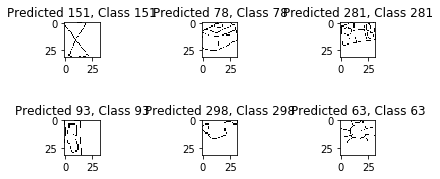

In [51]:
correct = np.where(y_pred==y_label)[0]
print ("Found {} correct labels".format(len(correct)))
for i, correct in enumerate(correct[:6]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[correct].reshape(32,32), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(y_pred[correct], y_label[correct]))
    plt.tight_layout()

Found 9474 incorrect labels


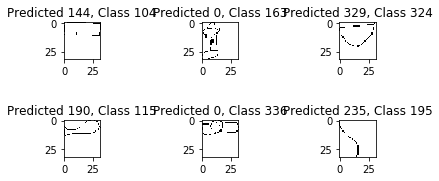

In [53]:
incorrect = np.where(y_pred!=y_label)[0]
print ("Found {} incorrect labels".format(len(incorrect)))
for i, incorrect in enumerate(incorrect[:6]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[incorrect].reshape(32,32), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(y_pred[incorrect], y_label[incorrect]))
    plt.tight_layout()

In [54]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_label, y_pred, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       0.03      0.98      0.07       241
    Class 1       1.00      0.94      0.97       223
    Class 2       0.94      0.87      0.90       223
    Class 3       1.00      0.94      0.97       212
    Class 4       0.94      0.69      0.80       215
    Class 5       0.99      0.82      0.90       239
    Class 6       0.88      0.85      0.86       240
    Class 7       0.98      0.98      0.98       210
    Class 8       0.99      0.80      0.89       226
    Class 9       0.97      0.82      0.89       224
   Class 10       0.95      0.94      0.94       215
   Class 11       0.95      0.98      0.97       227
   Class 12       0.98      0.95      0.96       230
   Class 13       0.96      0.95      0.95       229
   Class 14       0.98      0.94      0.96       234
   Class 15       0.98      0.81      0.89       224
   Class 16       0.99      0.97      0.98       243
   Class 17       0.96      0.95      0.96   

In [55]:
ttvlist = []
reader = pd.read_csv("D:/MBIT-2017-18-Master-Deep-Learning/Reto Doodle Kaggle - clasificación/test_simplified.csv", index_col=['key_id'],
    chunksize=2048,engine='python')
for chunk in tqdm(reader, total=55):
    imagebag = bag.from_sequence(chunk.drawing.values).map(draw_it)
    testarray = np.array(imagebag.compute())
    testarray = np.reshape(testarray, (testarray.shape[0], imheight, imwidth, 1))
    testpreds = full_model.predict(testarray, verbose=0)
    ttvs = np.argsort(-testpreds)[:, 0:3]  # top 3
    ttvlist.append(ttvs)
    
ttvarray = np.concatenate(ttvlist)

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [11:29<00:00, 12.53s/it]


In [56]:
preds_df = pd.DataFrame({'first': ttvarray[:,0], 'second': ttvarray[:,1], 'third': ttvarray[:,2]})
preds_df = preds_df.replace(numstonames)
preds_df['words'] = preds_df['first'] + " " + preds_df['second'] + " " + preds_df['third']

sub = pd.read_csv('D:/MBIT-2017-18-Master-Deep-Learning/Reto Doodle Kaggle - clasificación/sample_submission.csv', index_col=['key_id'], engine='python')
sub['word'] = preds_df.words.values
sub.to_csv("D:/MBIT-2017-18-Master-Deep-Learning/Reto Doodle Kaggle - clasificación/submission.csv")
sub.head(15)

,word
key_id,
9000003627287624,couch bathtub radio
9000010688666847,hamburger sandwich diving_board
9000023642890129,diving_board swing_set streetlight
9000038588854897,triangle mountain tent
9000052667981386,tent The_Eiffel_Tower kangaroo
9000057427034623,spreadsheet bridge calendar
9000065506980882,wine_glass flamingo stethoscope
9000087586309806,cruise_ship submarine flying_saucer
9000092580281382,crayon pliers paper_clip


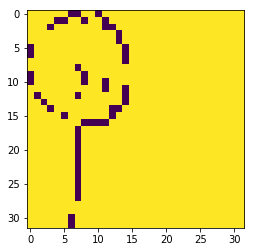

In [59]:
plt.imshow(np.reshape(testarray[1],(32,32)))